In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd
import pickle
from Net3 import Net3
from Net5 import Net5
import itertools

In [18]:
# pd.options.display.width = 0
pd.set_option('display.width', 300)

In [25]:
results_folder = '../../Results/'
sensor_specific_folder = "sensor_specific/"

In [26]:
data_folder = '../../Data/Training/wavelet_pickle_data'

In [92]:
folder_2022 = f'{data_folder}/2022'
scaled_2022 = f'{folder_2022}/Scaled'

# 2023 folders
test_scaled_2023_folder = f'{data_folder}/2023/Scaled/test_scaled.pkl'
test_2023_folder = f'{data_folder}/2023/test.pkl'

# 2023 data
test_scaled_all_sensors_2023 = pd.read_pickle(open(test_scaled_2023_folder, 'rb'))
test_all_sensors_2023 = pd.read_pickle(open(test_2023_folder, 'rb'))

# Test_2023

# test_X_scaled_2023 = test_scaled_all_sensors_2023.loc[:,~test_scaled_all_sensors_2023.columns.isin(exclude_features)]
# test_X_scaled_2023 = torch.Tensor(test_X_scaled_2023.to_numpy().astype("float32")).to(device)

In [27]:
sensor_data = dict()

# Main folders
folder_2022_sensors = f'{data_folder}/2022_sensors'
scaled_2022_sensors = f'{folder_2022_sensors}/Scaled'

sensors = np.arange(1,6)

for sensor in sensors:
    # 2022 sensors folder
    X_train_scaled_2022_sensor_folder = f'{scaled_2022_sensors}/X_train_scaled_sensor_{sensor}.pkl'
    X_test_scaled_2022_sensor_folder = f'{scaled_2022_sensors}/X_test_scaled_sensor_{sensor}.pkl'
    X_test_2022_sensor_folder = f'{folder_2022_sensors}/X_test_sensor_{sensor}.pkl'
    y_train_2022_sensor_folder = f'{folder_2022_sensors}/y_train_sensor_{sensor}.pkl'
    y_test_2022_sensor_folder = f'{folder_2022_sensors}/y_test_sensor_{sensor}.pkl'

    # 2022 sensors data
    X_train_scaled_2022_sensor = pd.read_pickle(open(X_train_scaled_2022_sensor_folder, 'rb'))
    X_test_scaled_2022_sensor = pd.read_pickle(open(X_test_scaled_2022_sensor_folder, 'rb'))
    X_test_2022_sensor = pd.read_pickle(open(X_test_2022_sensor_folder, 'rb'))
    y_train_2022_sensor = pd.read_pickle(open(y_train_2022_sensor_folder, 'rb'))
    y_test_2022_sensor = pd.read_pickle(open(y_test_2022_sensor_folder, 'rb'))

    # 2023 sensors folders
    test_scaled_2023_sensor_folder = f'{data_folder}/2023_sensors/Scaled/test_scaled_sensor_{sensor}.pkl'
    test_2023_sensor_folder = f'{data_folder}/2023_sensors/test_sensor_{sensor}.pkl'

    # 2023 sensors data
    test_scaled_2023_sensor = pd.read_pickle(open(test_scaled_2023_sensor_folder, 'rb'))
    test_2023_sensor = pd.read_pickle(open(test_2023_sensor_folder, 'rb'))

    sensor_data[f'sensor_{sensor}'] = {
        "X_train_scaled": X_train_scaled_2022_sensor,
        "X_test_scaled": X_test_scaled_2022_sensor,
        "X_test": X_test_2022_sensor,
        "y_train": y_train_2022_sensor,
        "y_test": y_test_2022_sensor,
        "test_scaled_2023": test_scaled_2023_sensor,
        "test_2023": test_2023_sensor
    }

In [24]:
def plot_predicted_2023(predicted, test_X_2023, sensor = None):

    if sensor == None: 
        for i in np.arange(1,6):
            fig = plt.figure(figsize = (40,15))
            ax = plt.gca()
            for j in np.arange(1,5):
                ax.scatter(test_X_2023.loc[test_X_2023["pit_number"] == j, "TIMESTAMP"], test_X_2023.loc[test_X_2023["pit_number"] == j, ["Redox_Avg("+ str(i)+ ")"]], color = "green", alpha = 0.05, s = 1)
                ax.scatter(test_X_2023.loc[predicted & (test_X_2023["pit_number"] == j), ["TIMESTAMP"]], test_X_2023.loc[predicted & (test_X_2023["pit_number"] == j), ["Redox_Avg("+ str(i)+ ")"]], color = "red", alpha = 1, s = 1)
            plt.show(block = False)
  
    if sensor != None: 
        
        for j in np.arange(1,5):
            fig, ax = plt.subplots(figsize = (40,15))
            ax.set_title(f"2023 data with the errors predicted by the neural network model")    
            ax.scatter(test_X_2023.loc[test_X_2023["pit_number"] == j, "TIMESTAMP"], test_X_2023.loc[test_X_2023["pit_number"] == j, ["Redox_Avg("+ str(sensor)+ ")"]], color = "green", alpha = 0.5, s = 1)
            x = test_X_2023.loc[predicted & (test_X_2023["pit_number"] == j), ["TIMESTAMP"]]
            y = test_X_2023.loc[predicted & (test_X_2023["pit_number"] == j), ["Redox_Avg("+ str(sensor)+ ")"]]
            ax.scatter(x = x, y = y, color = "red", s = 1)
            plt.show(block = False)

### All sensors trained with SGD, alpha = 0.001 and epochs = 25 

In [108]:
models_all_sensors_dict = pickle.load(open(results_folder + "all_sensors_SGD_0.001_models_dict", 'rb'))

In [109]:
all_sensor_train_test_results_final_table_df = pickle.load(open(results_folder + "all_sensors_SGD_0.001_results_df", 'rb'))

In [110]:
all_sensor_train_test_results_final_table_df

architecture  weight_normal  weight_anomaly  number_of_units  ...  train_recall  test_log_likelihood  test_accuracy  test_recall
0             3            2.0             2.0                3  ...      0.000000             0.000274       0.923685     0.000000
1             3            2.0             2.0                5  ...      0.999182             0.000202       0.908504     0.999683
2             3            2.0             2.0                7  ...      0.999864             0.000062       0.979501     0.999683
3             3            2.0             2.0                9  ...      0.999591             0.000001       0.999613     0.999050
4             3            2.0             2.0               11  ...      0.999727             0.000027       0.990621     0.877099
5             3            2.0             2.0               13  ...      0.999591             0.000229       0.940921     0.701932
6             3            2.0             2.0               15  ...      0.999864             0.000029       0.989460     0.861894
0             3            2.0             4.0                3  ...      0.998364             0.000790       0.853389     0.997466
1             3            2.0             4.0                5  ...      0.999864             0.000135       0.941622     0.999683
2             3            2.0             4.0                7  ...      0.998364             0.000010       0.998114     0.987013
3             3            2.0             4.0                9  ...      0.999318             0.000291       0.970291     0.654736
4             3            2.0             4.0               11  ...      0.999864             0.000001       0.999952     0.999683
5             3            2.0             4.0               13  ...      0.999591             0.000022       0.995310     0.939500
6             3            2.0             4.0               15  ...      0.999318             0.000022       0.995335     0.969591
0             5            2.0             2.0                3  ...      0.999455             0.000305       0.877345     0.999683
1             5            2.0             2.0                5  ...      0.000000             0.000275       0.923685     0.000000
2             5            2.0             2.0                7  ...      0.000000             0.000274       0.923685     0.000000
3             5            2.0             2.0                9  ...      0.999864             0.000009       0.997607     0.999683
4             5            2.0             2.0               11  ...      0.999318             0.000191       0.916409     0.999683
5             5            2.0             2.0               13  ...      0.999864             0.000201       0.920083     0.999683
6             5            2.0             2.0               15  ...      0.000000             0.000274       0.923685     0.000000
0             5            2.0             4.0                3  ...      0.000000             0.000415       0.923685     0.000000
1             5            2.0             4.0                5  ...      0.000000             0.000415       0.923685     0.000000
2             5            2.0             4.0                7  ...      0.999455             0.000069       0.976842     0.999683
3             5            2.0             4.0                9  ...      0.999864             0.000007       0.998622     0.981945
4             5            2.0             4.0               11  ...      0.999864             0.000593       0.862309     0.999683
5             5            2.0             4.0               13  ...      0.999864             0.000046       0.989485     0.862528
6             5            2.0             4.0               15  ...      0.999727             0.000022       0.993449     0.999683

[28 rows x 10 columns]

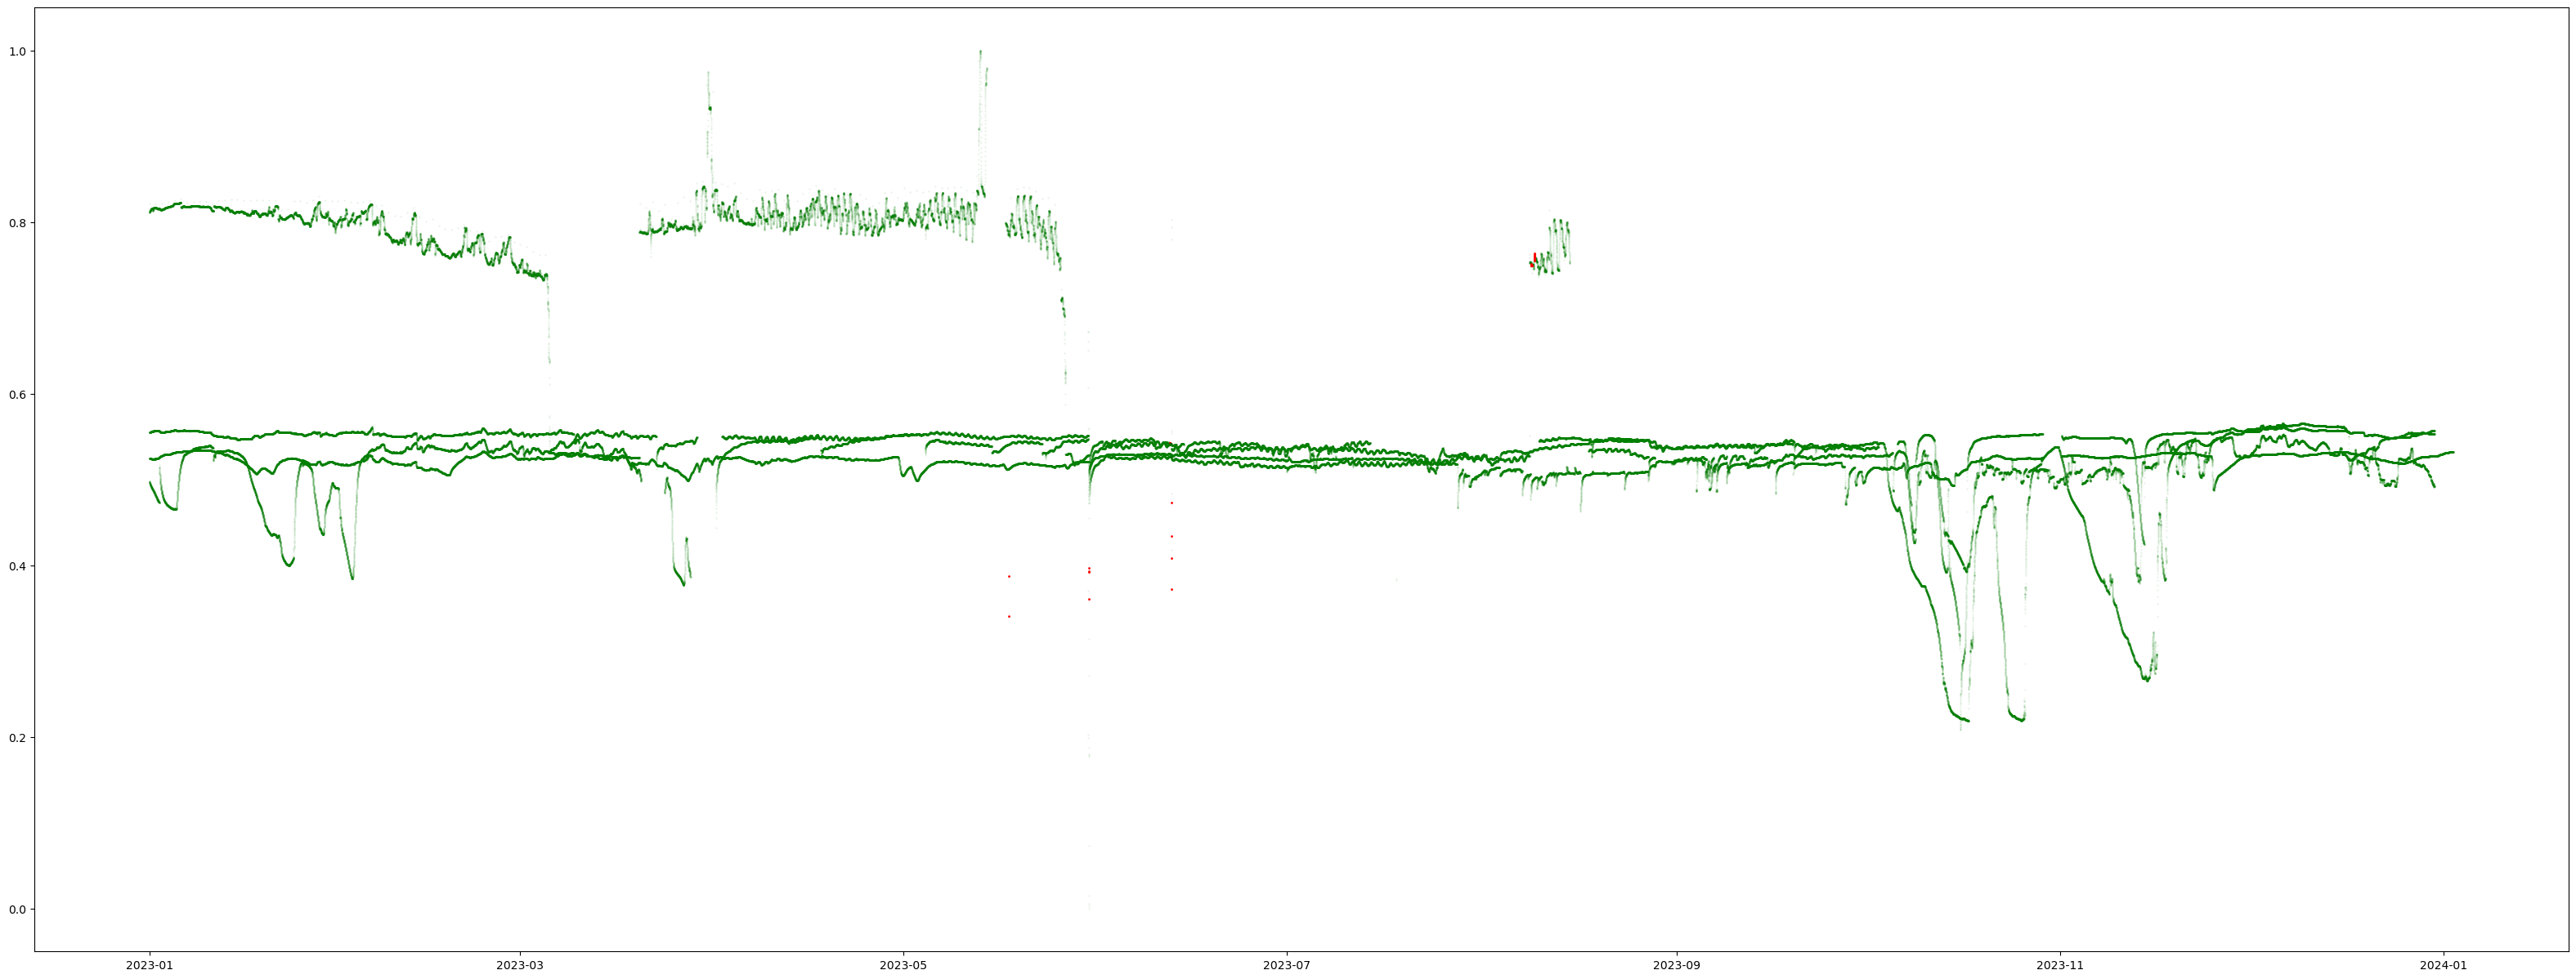

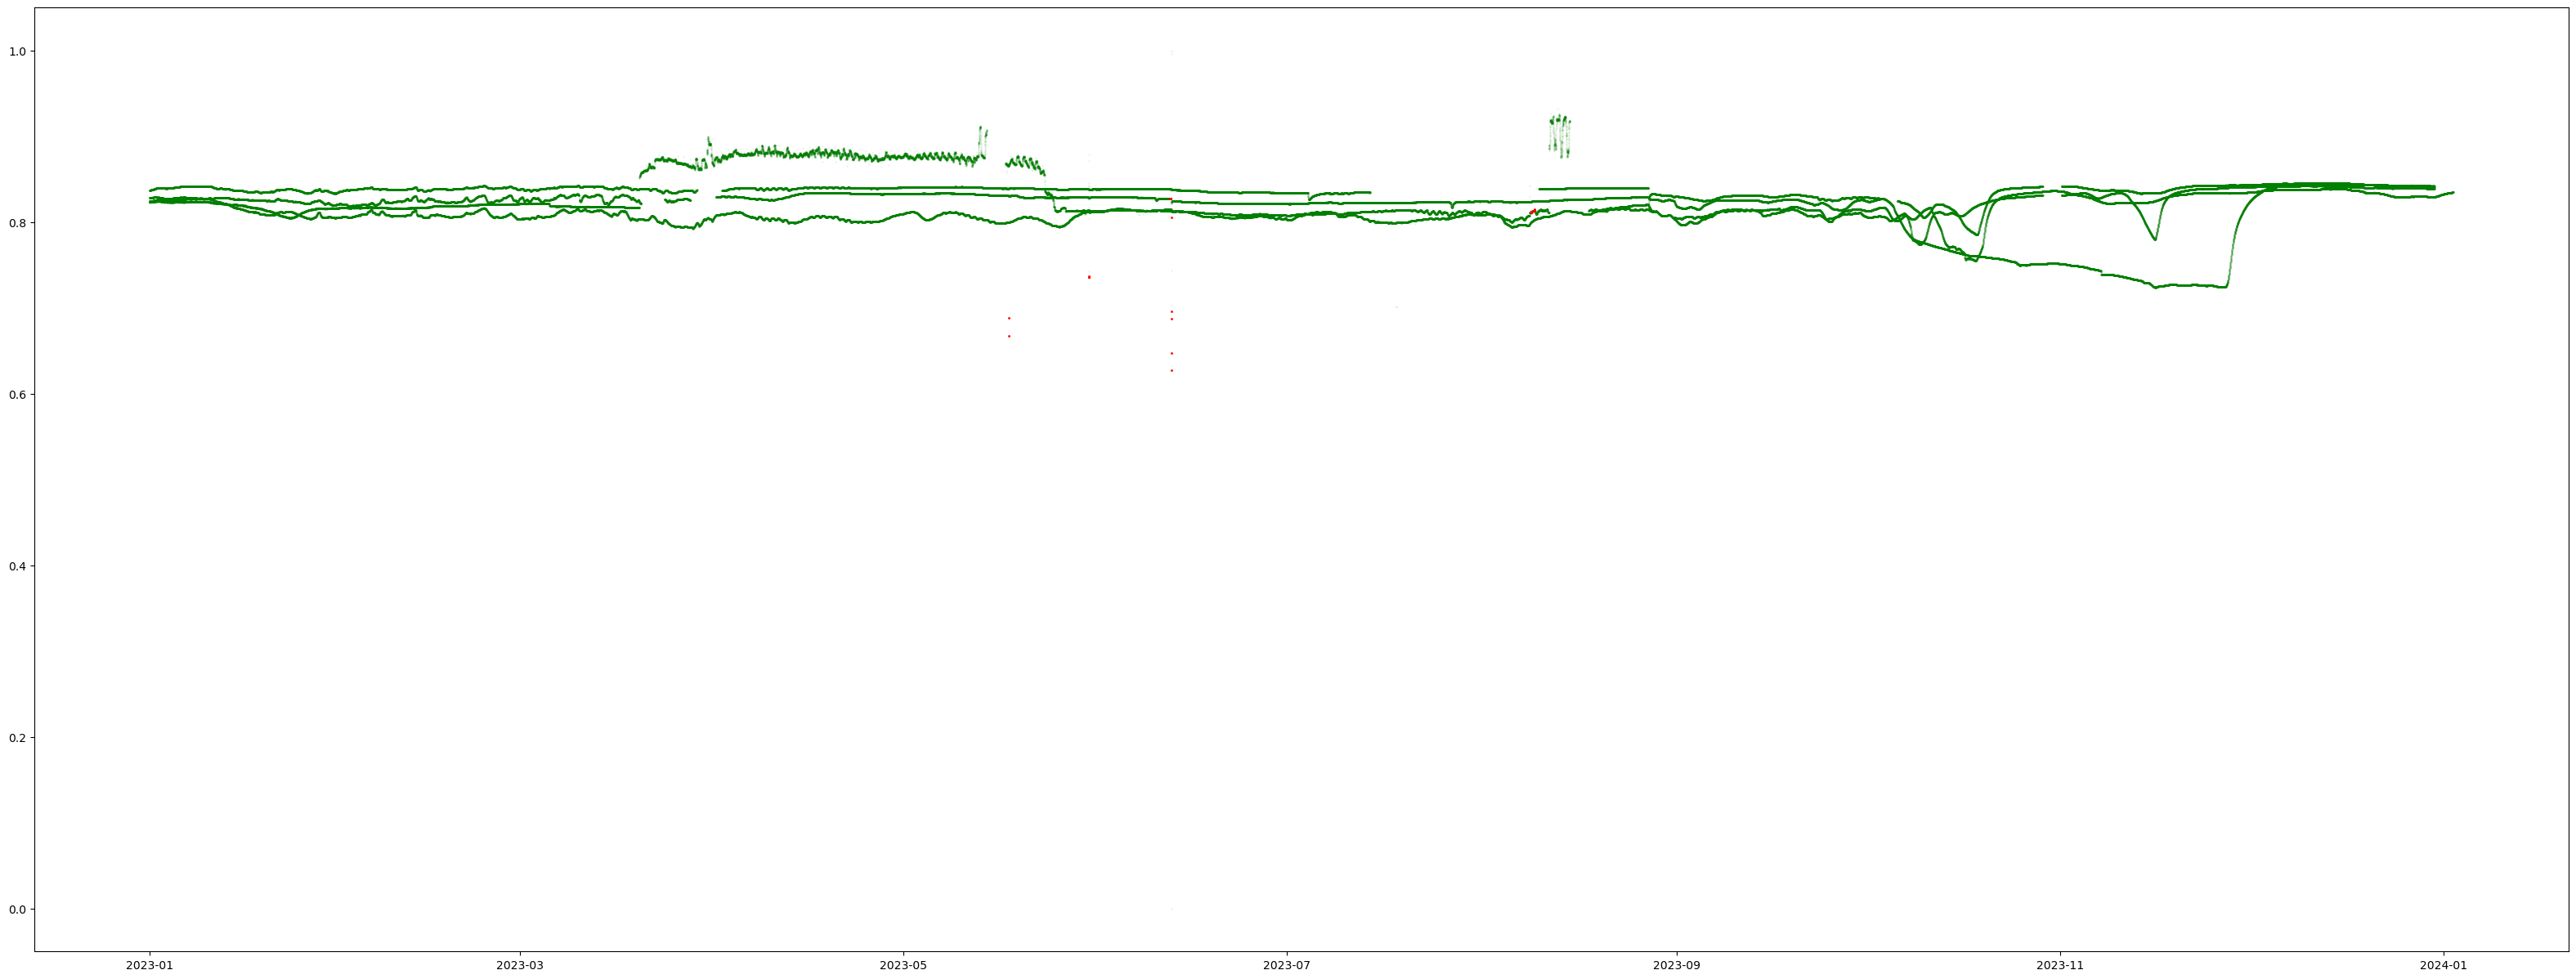

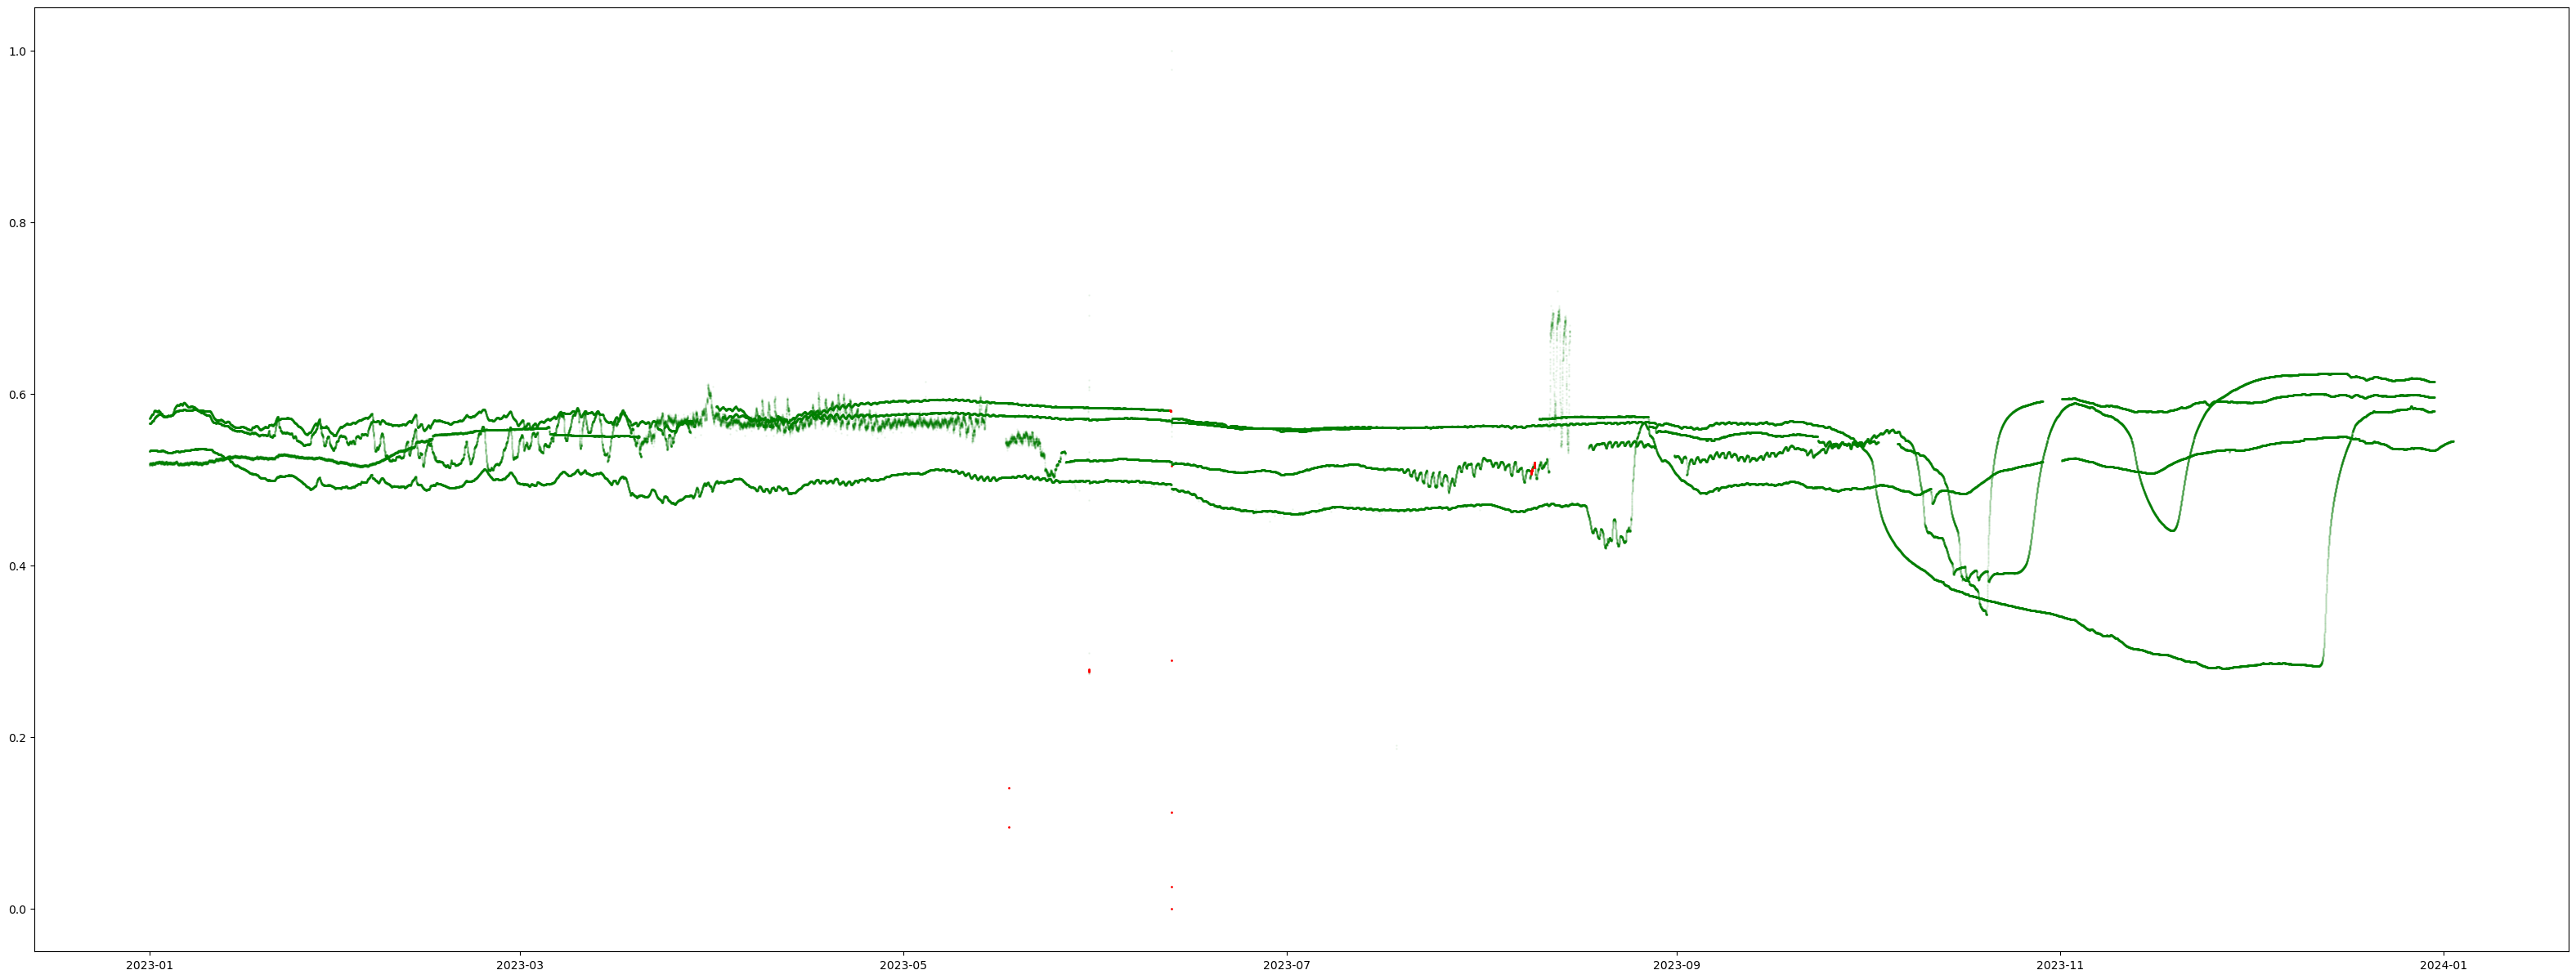

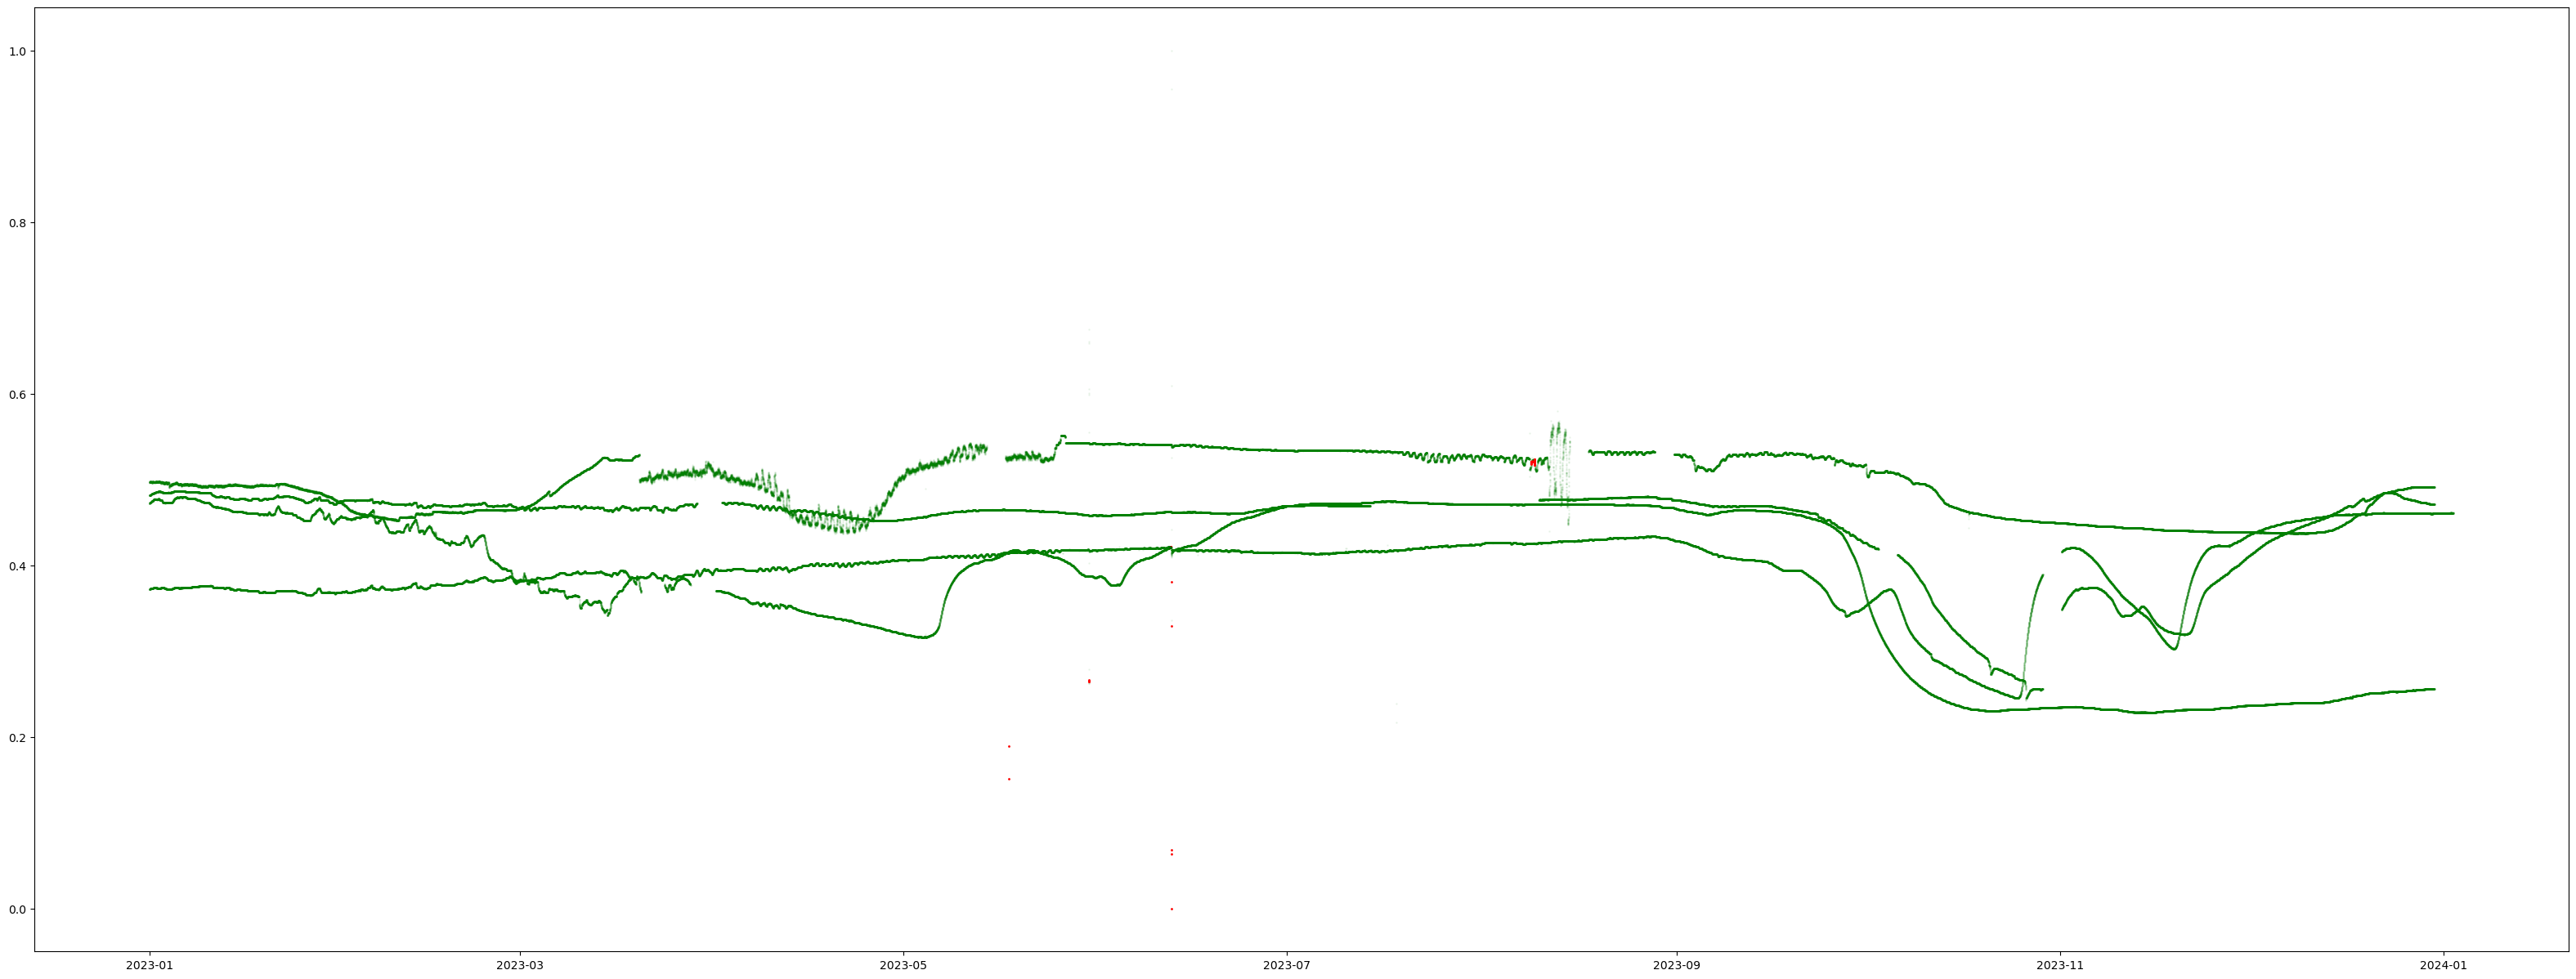

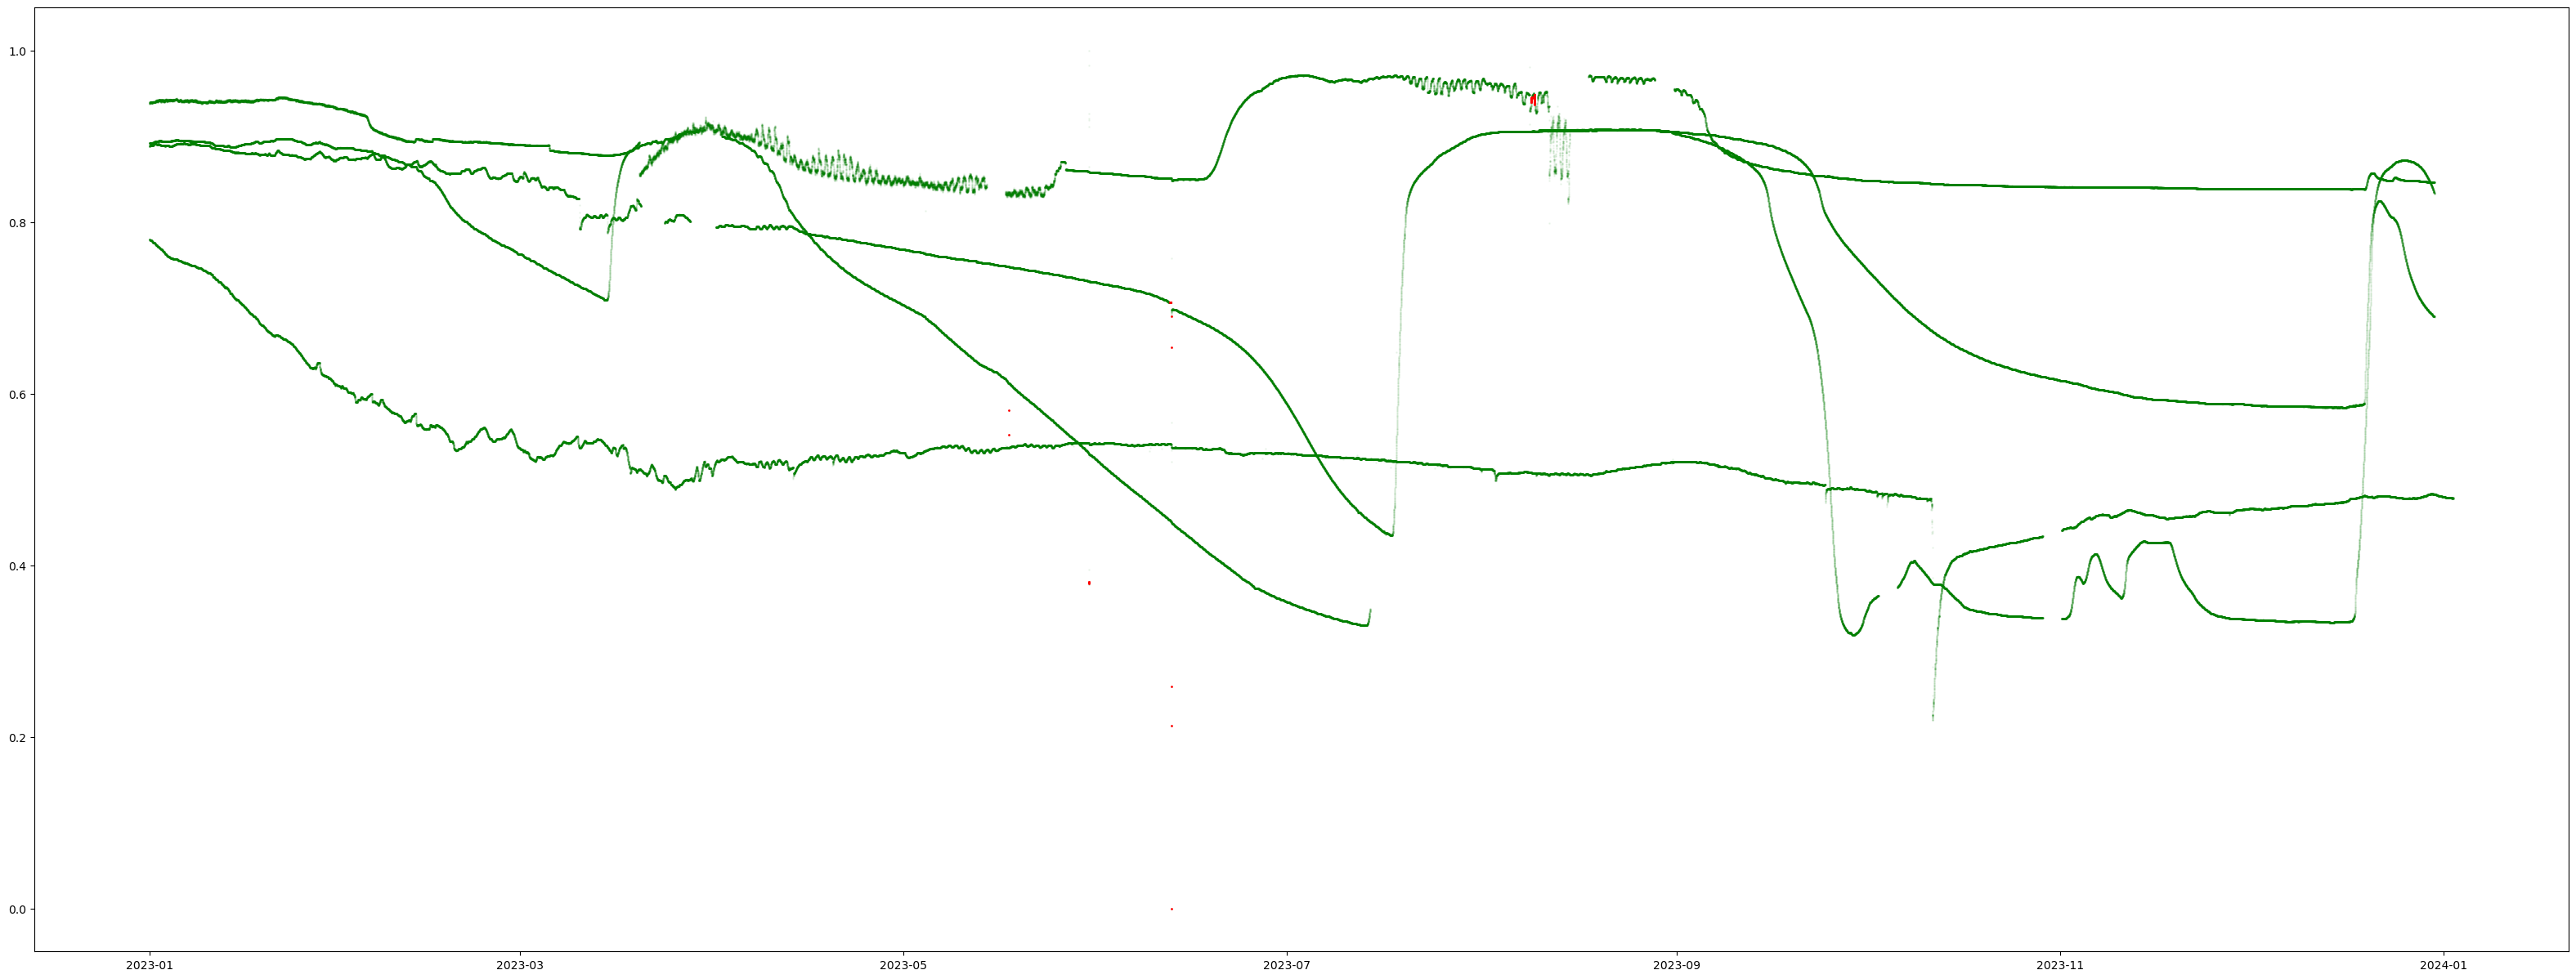

In [121]:
model_opt = models_all_sensors_dict[Net3, 2.0, 4.0][11]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_all_sensors_2023, sensor = None)

### Sensor specific models trained with SGD, alpha = 0.001 and epochs = 25 

In [112]:
df = pickle.load(open(results_folder + sensor_specific_folder + "SGD_0.001_results_df_dict", 'rb'))
df

{1:    architecture  weight_normal  weight_anomaly  number_of_units  ...  train_recall  test_log_likelihood  test_accuracy  test_recall
 0             3            2.0             2.0                3  ...      0.000000             0.000120       0.974757     0.000000
 1             3            2.0             2.0                5  ...      0.984362             0.000020       0.993577     0.785781
 2             3            2.0             2.0                7  ...      0.999198             0.000053       0.984817     0.587465
 3             3            2.0             2.0                9  ...      0.999198             0.000022       0.994781     0.796071
 4             3            2.0             2.0               11  ...      0.994787             0.000061       0.986918     0.490178
 5             3            2.0             2.0               13  ...      0.998797             0.000037       0.990389     0.619270
 6             3            2.0             2.0               15  

In [113]:
models = pickle.load(open(results_folder + sensor_specific_folder + "all_models_SGD_0.001", 'rb'))

### Sensor 1

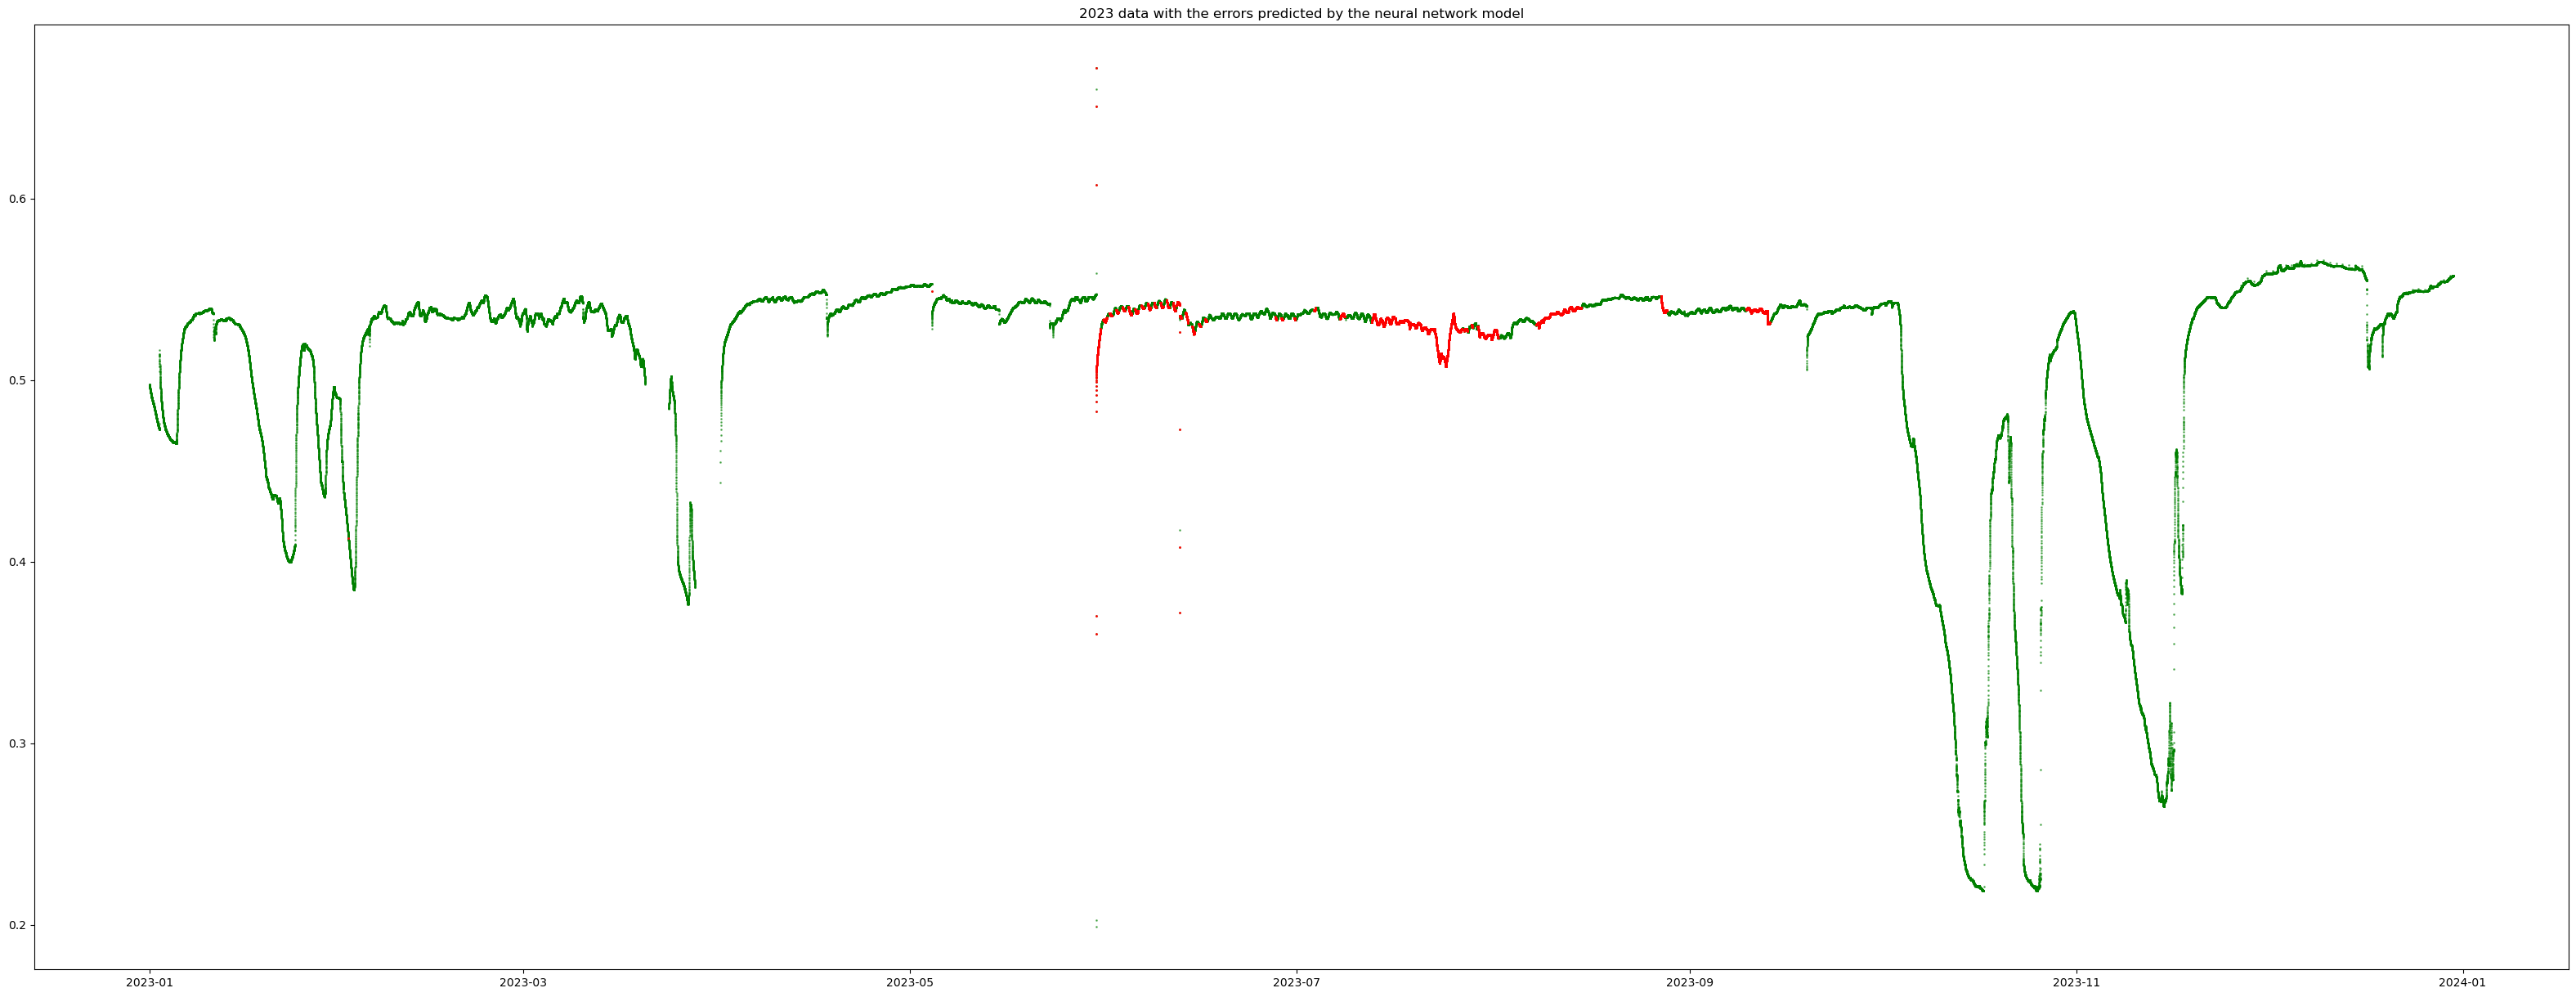

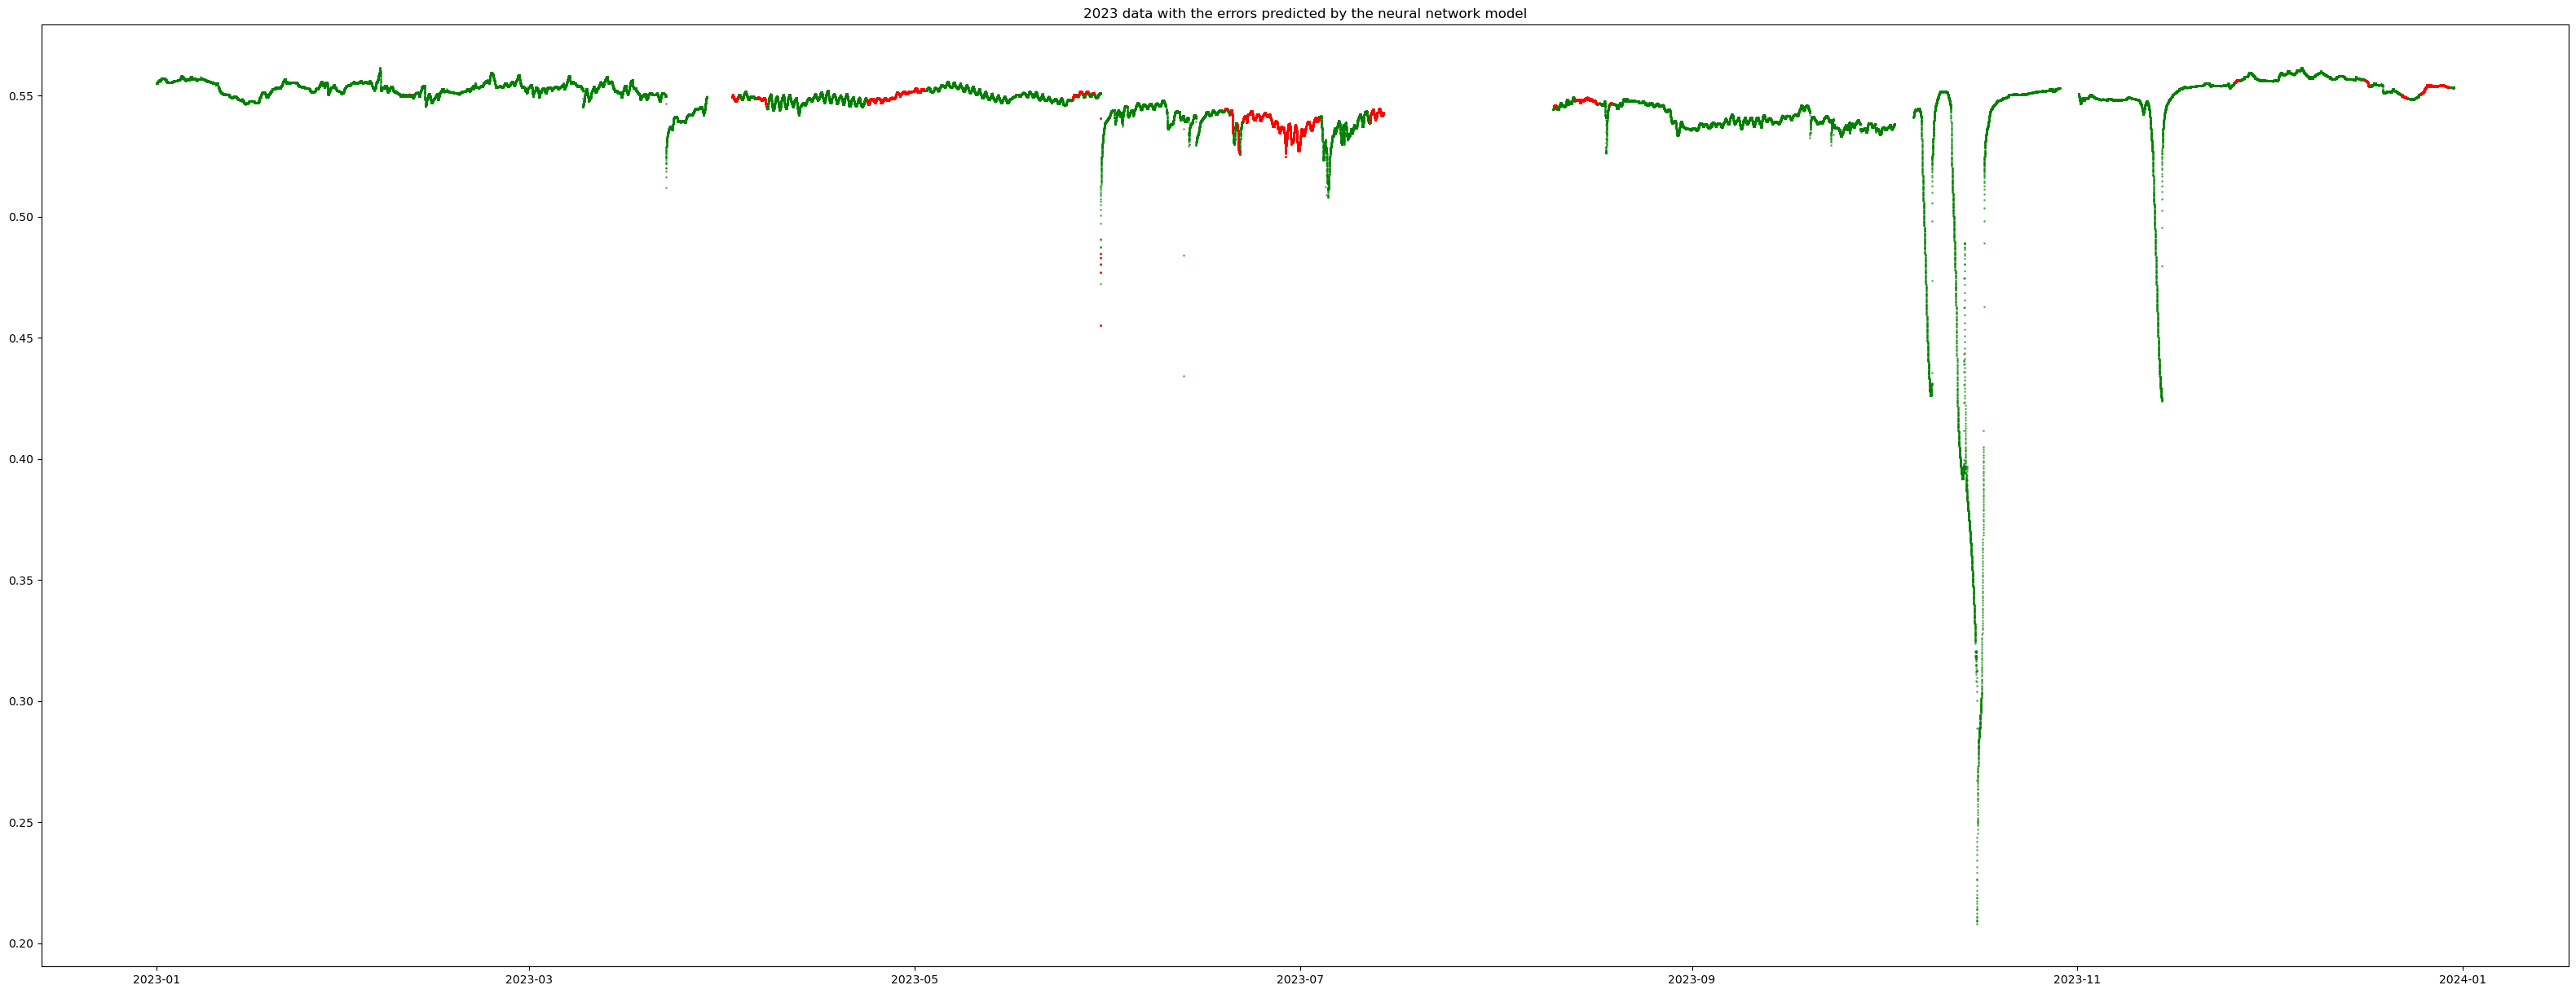

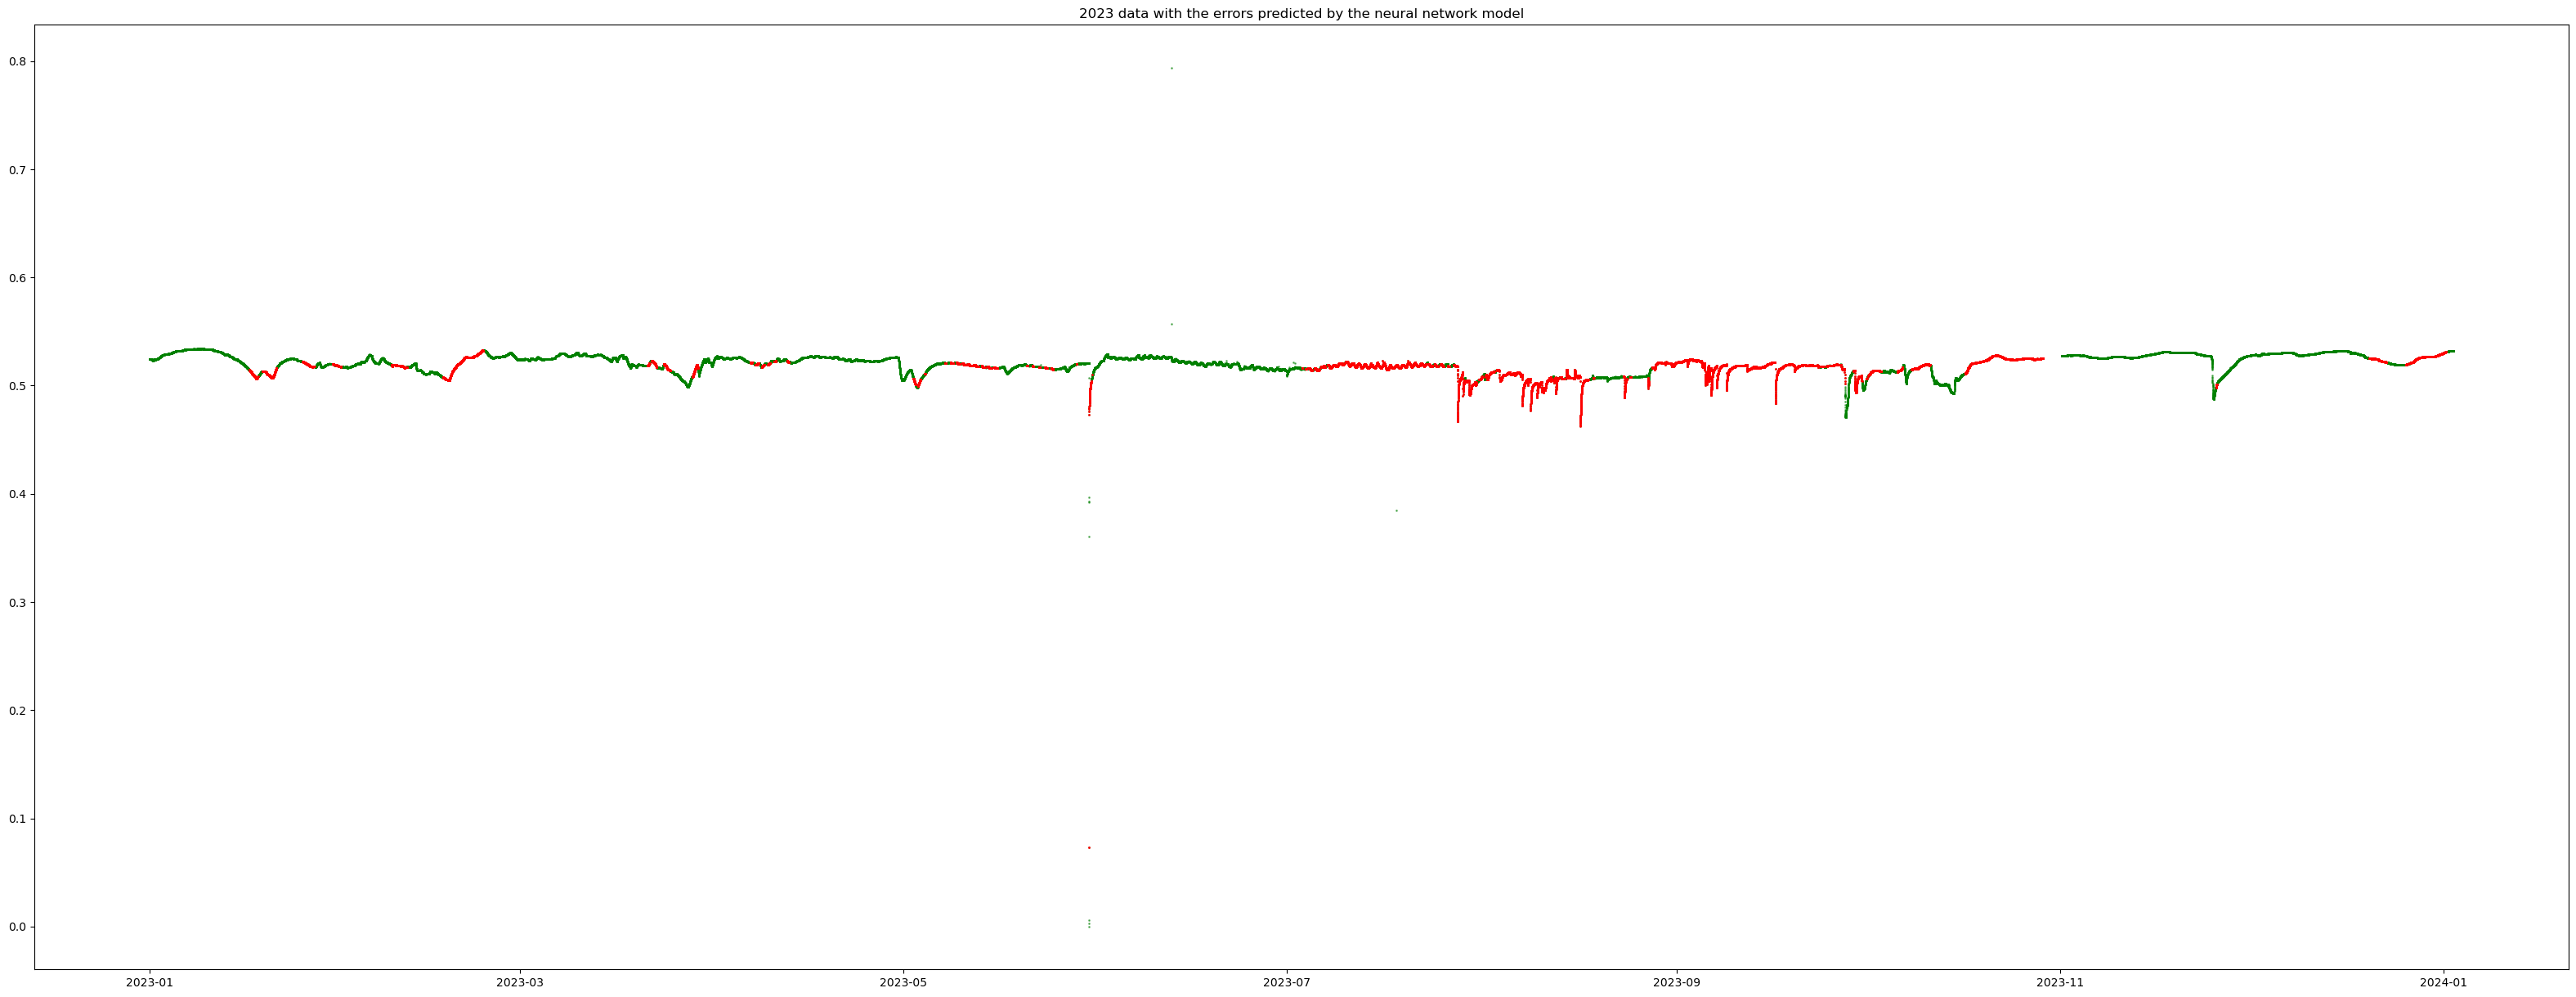

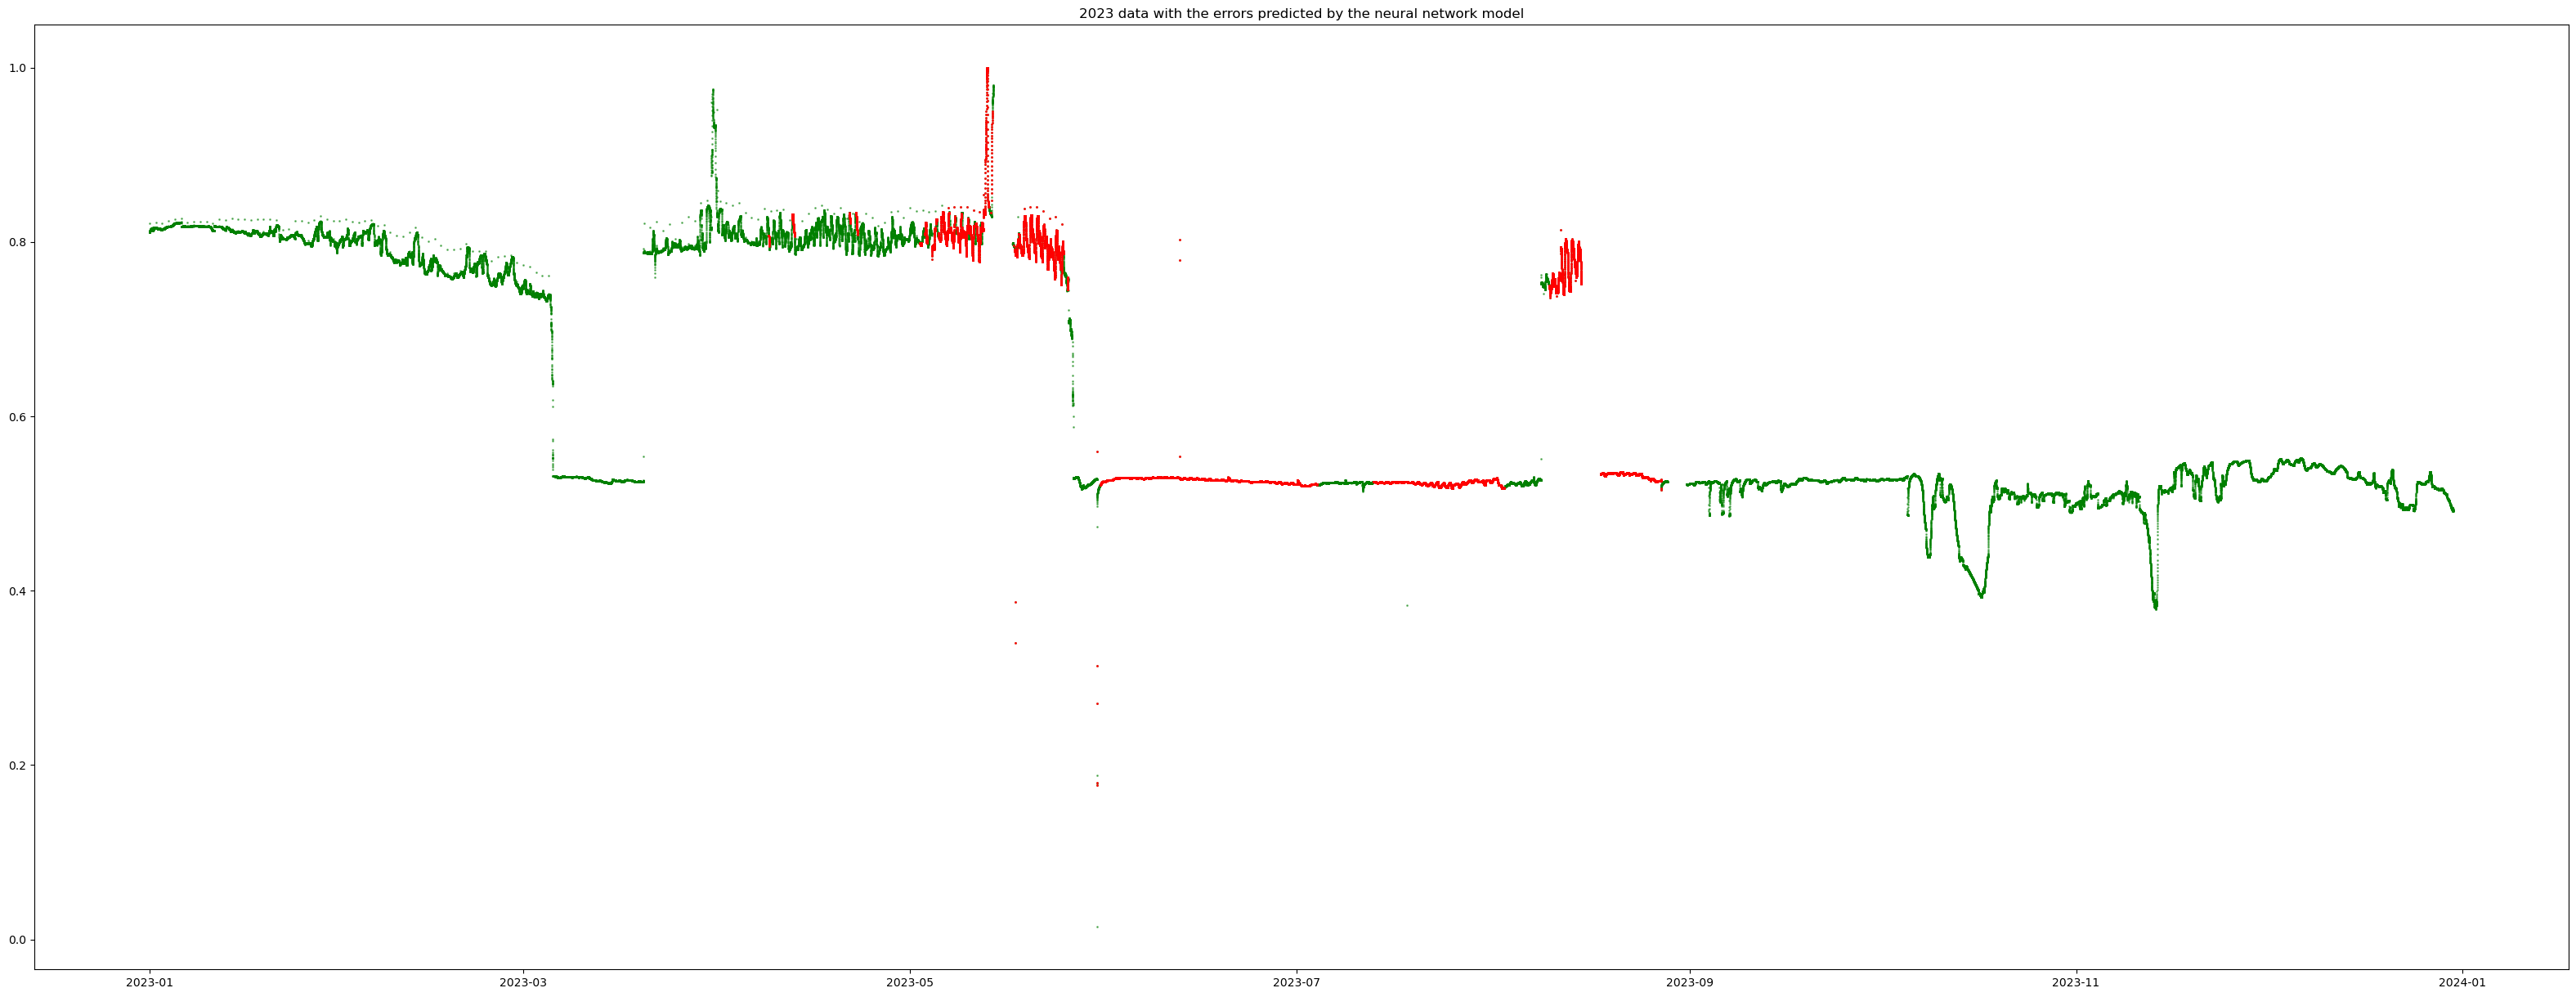

In [118]:
test_scaled_2023 = sensor_data[f'sensor_{1}']["test_scaled_2023"]
model_opt = models[1, Net3, 2.0, 4.0][13]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 1)

In [119]:
pickle.dump(model_opt, open(results_folder + sensor_specific_folder + "sensor1_final_model_SGD_0.001_hidden_3_units_13_weight_ratio_2", 'wb'))

## Sensor 2

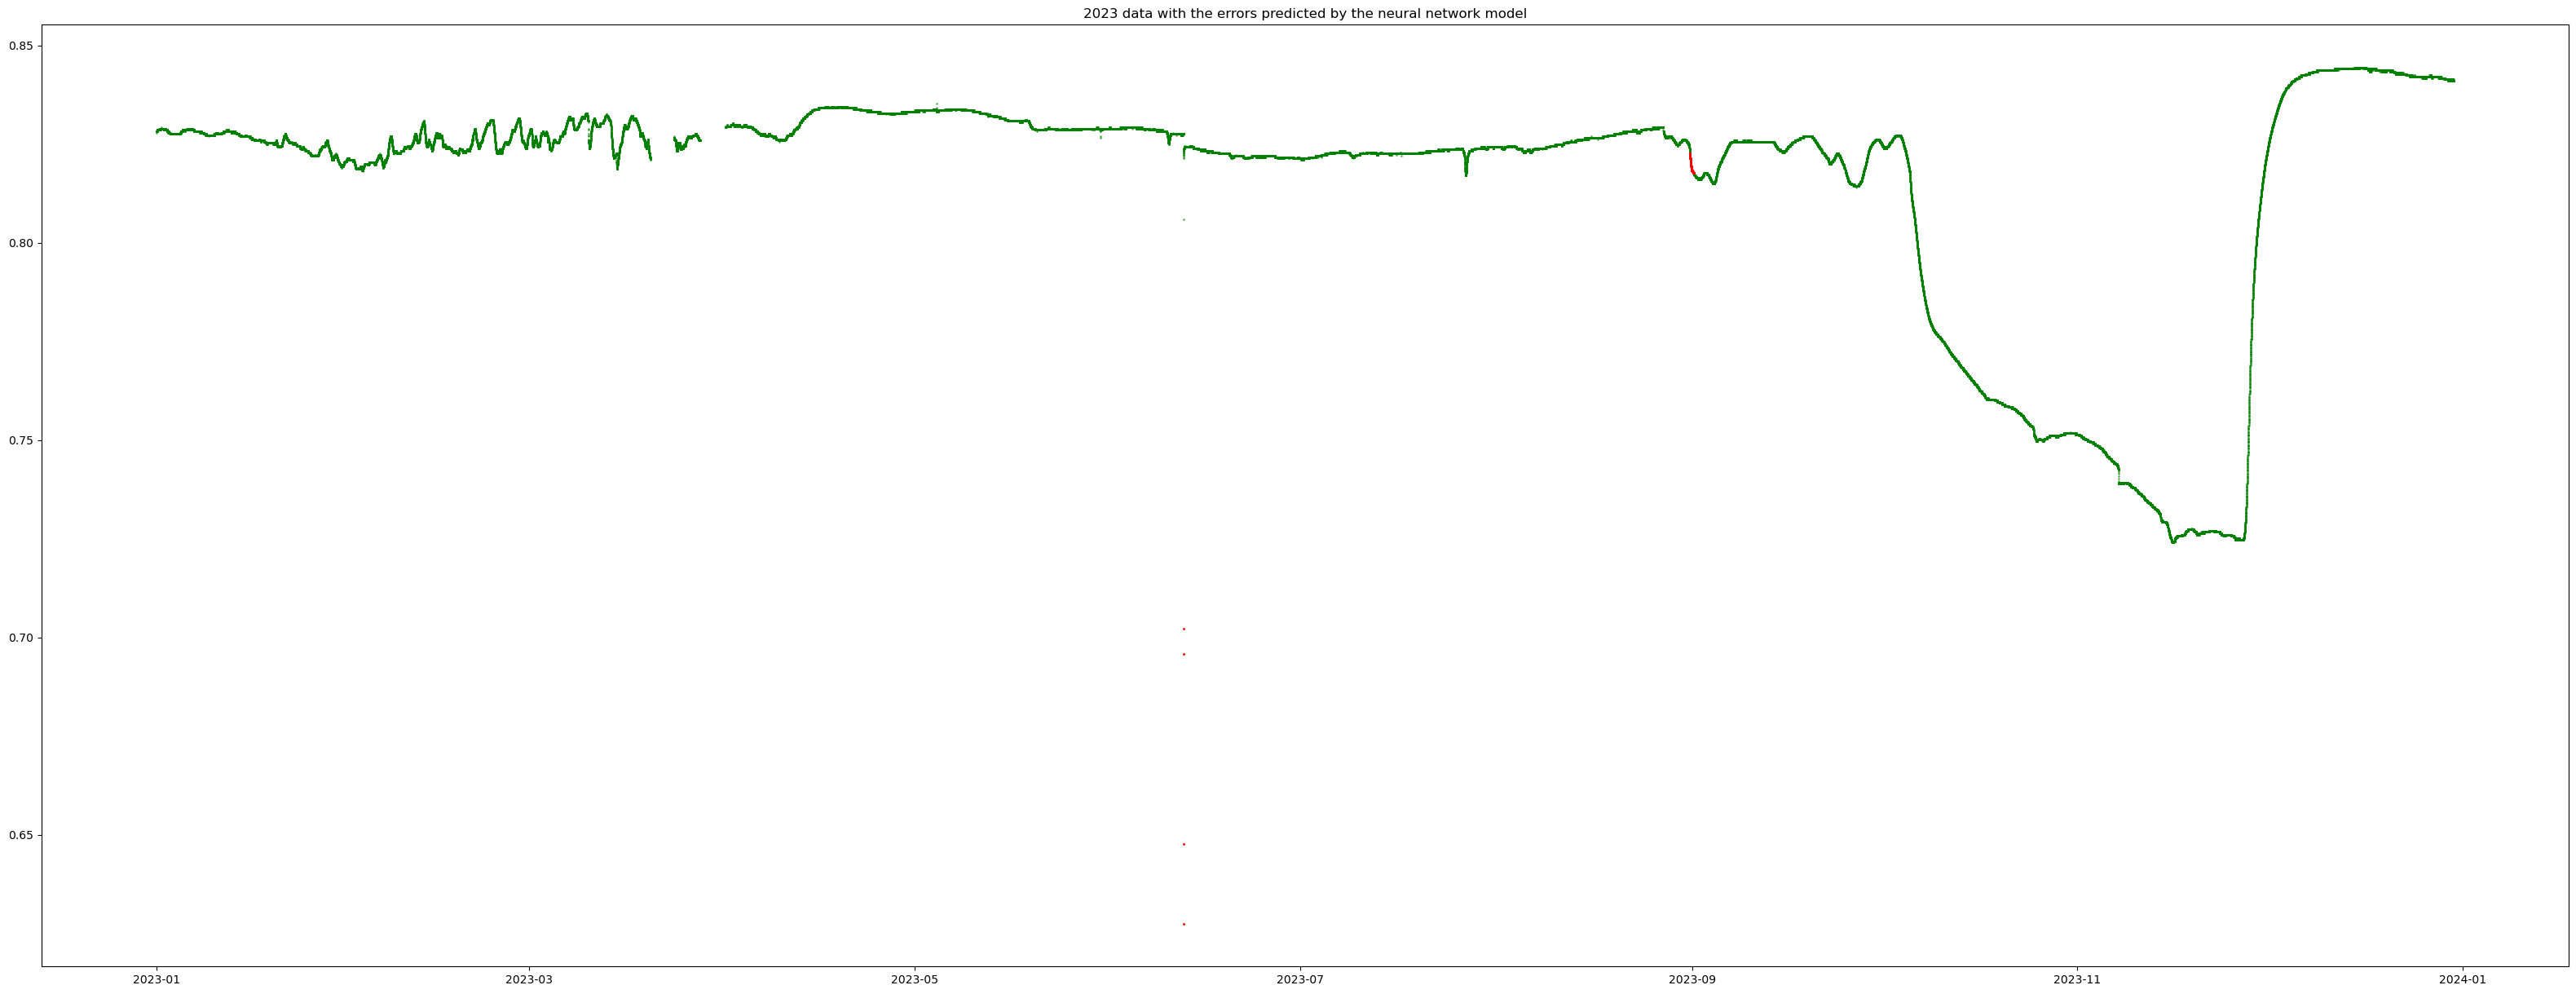

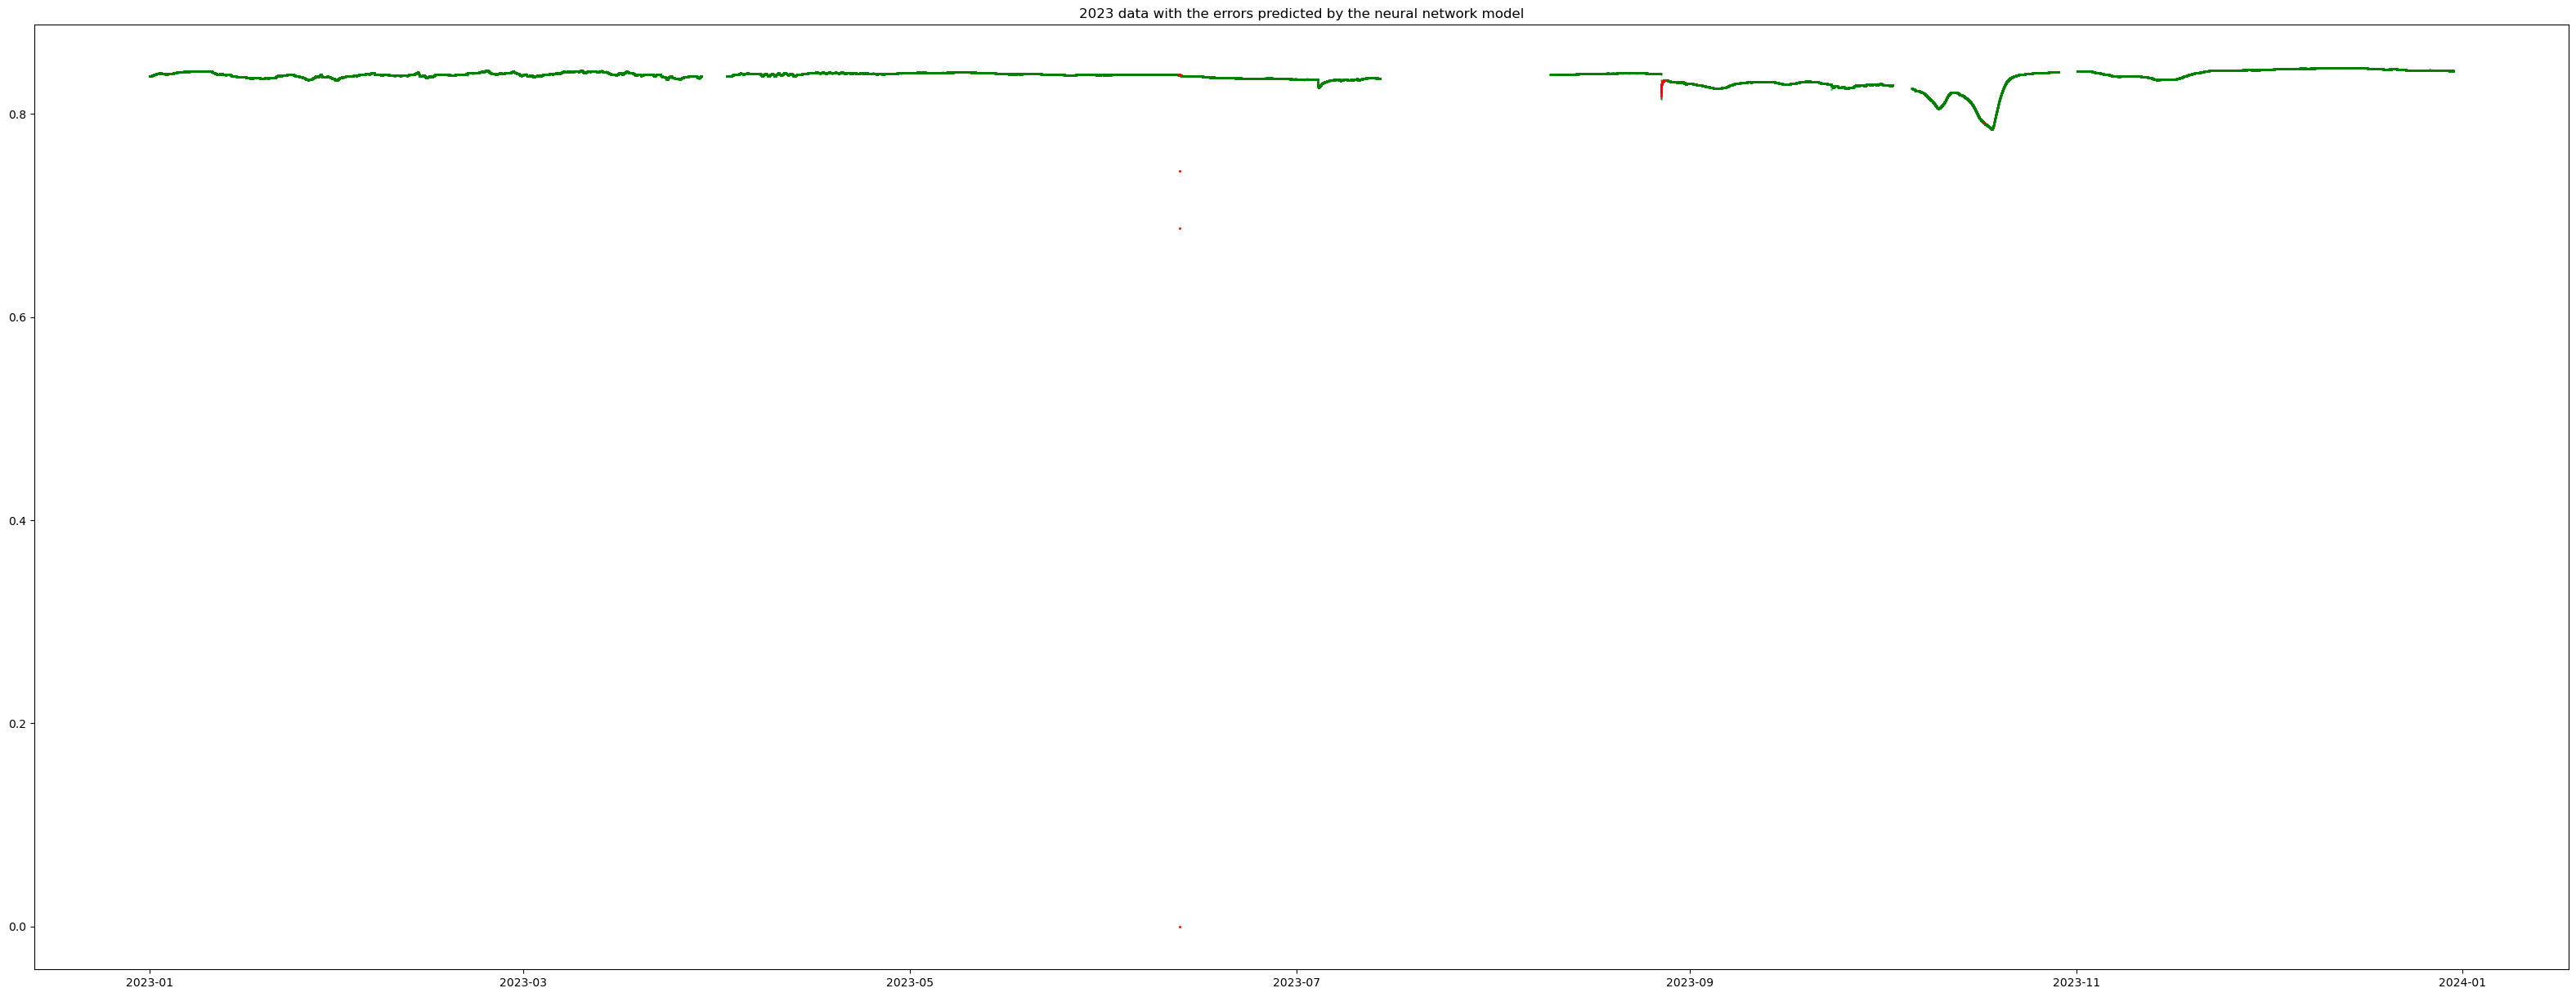

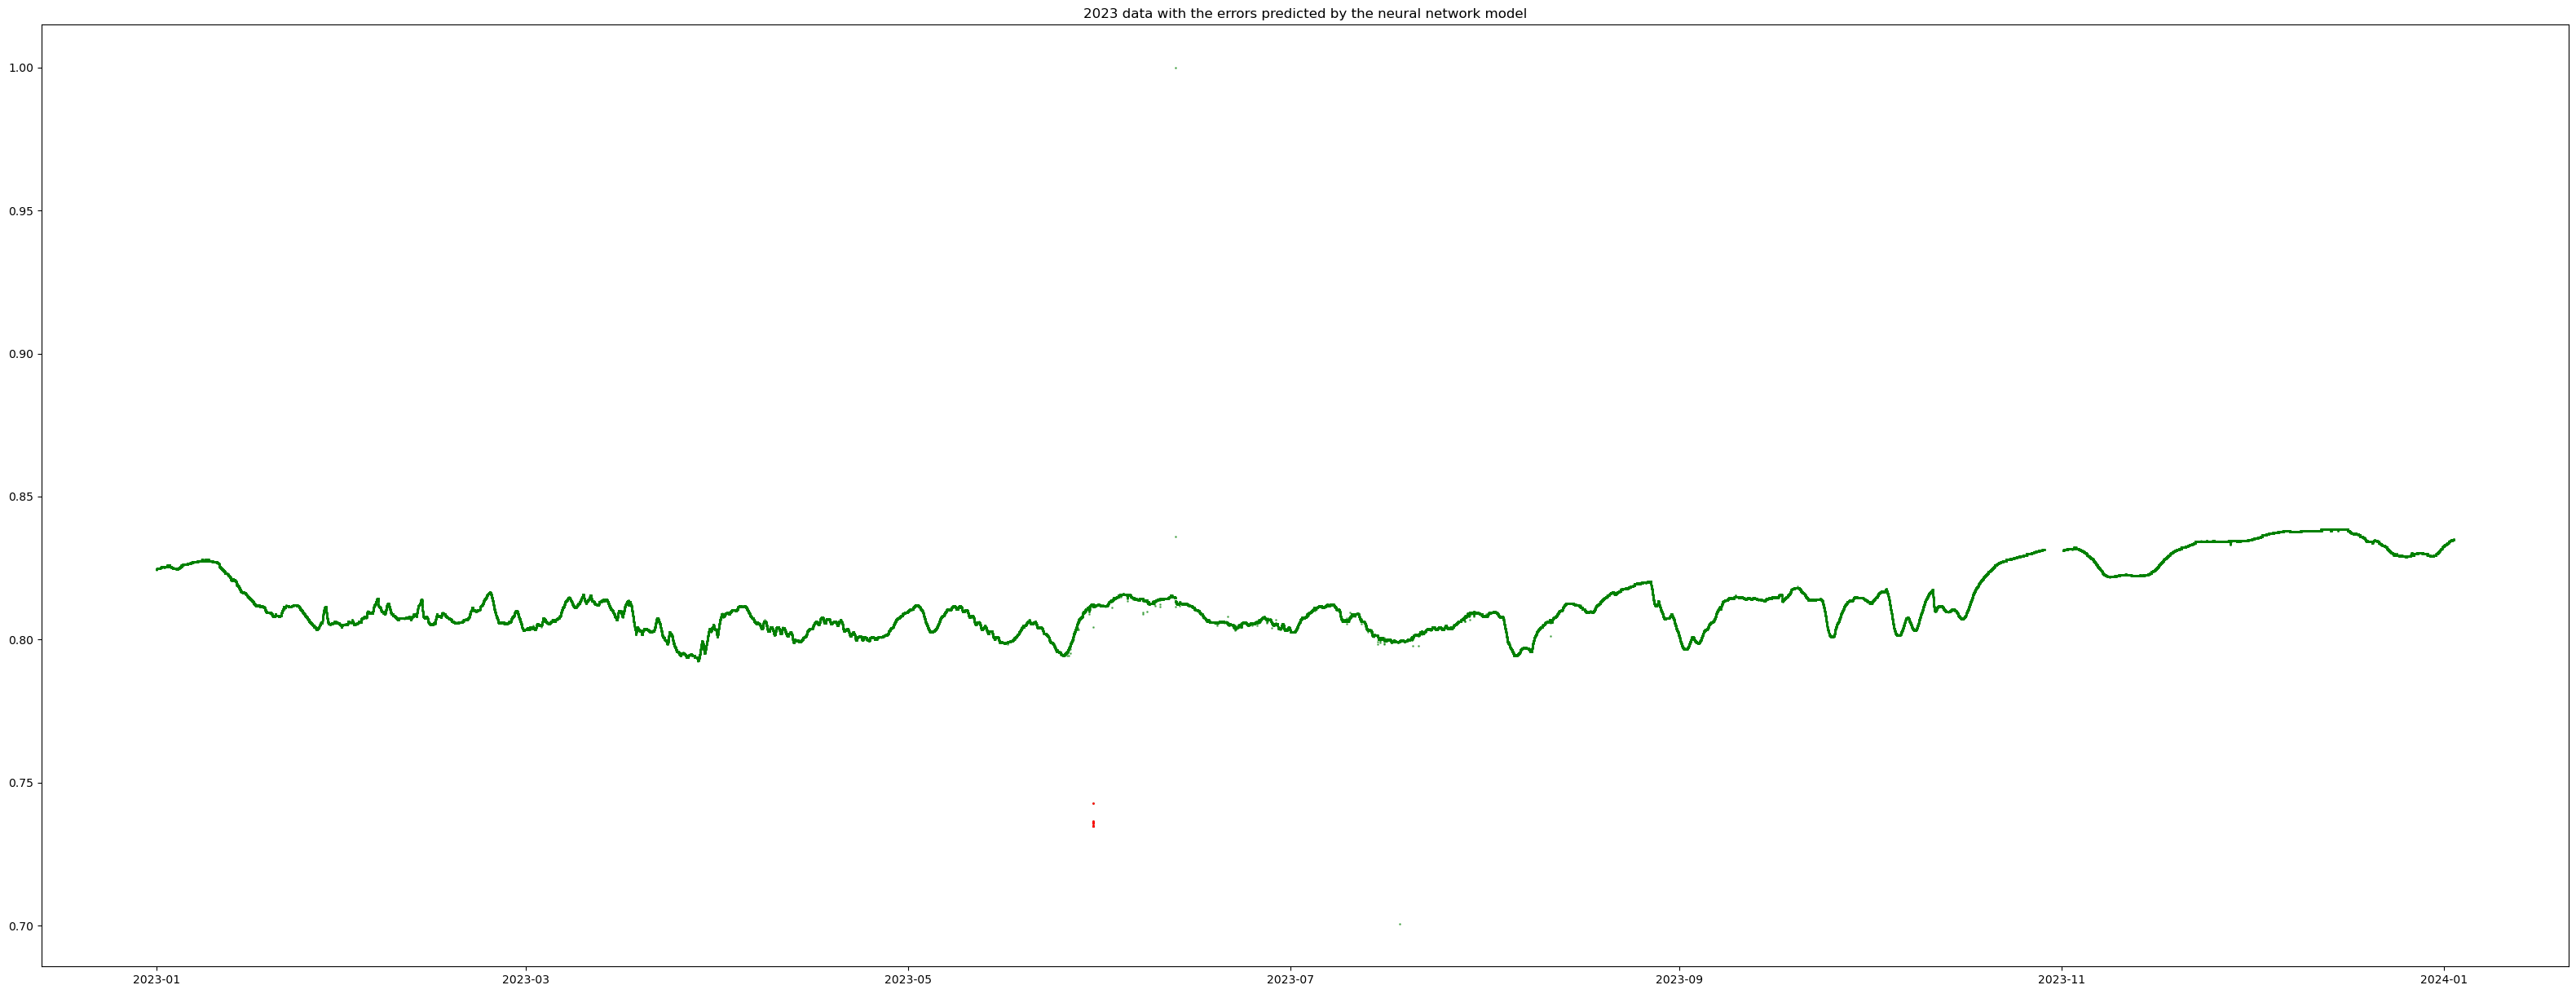

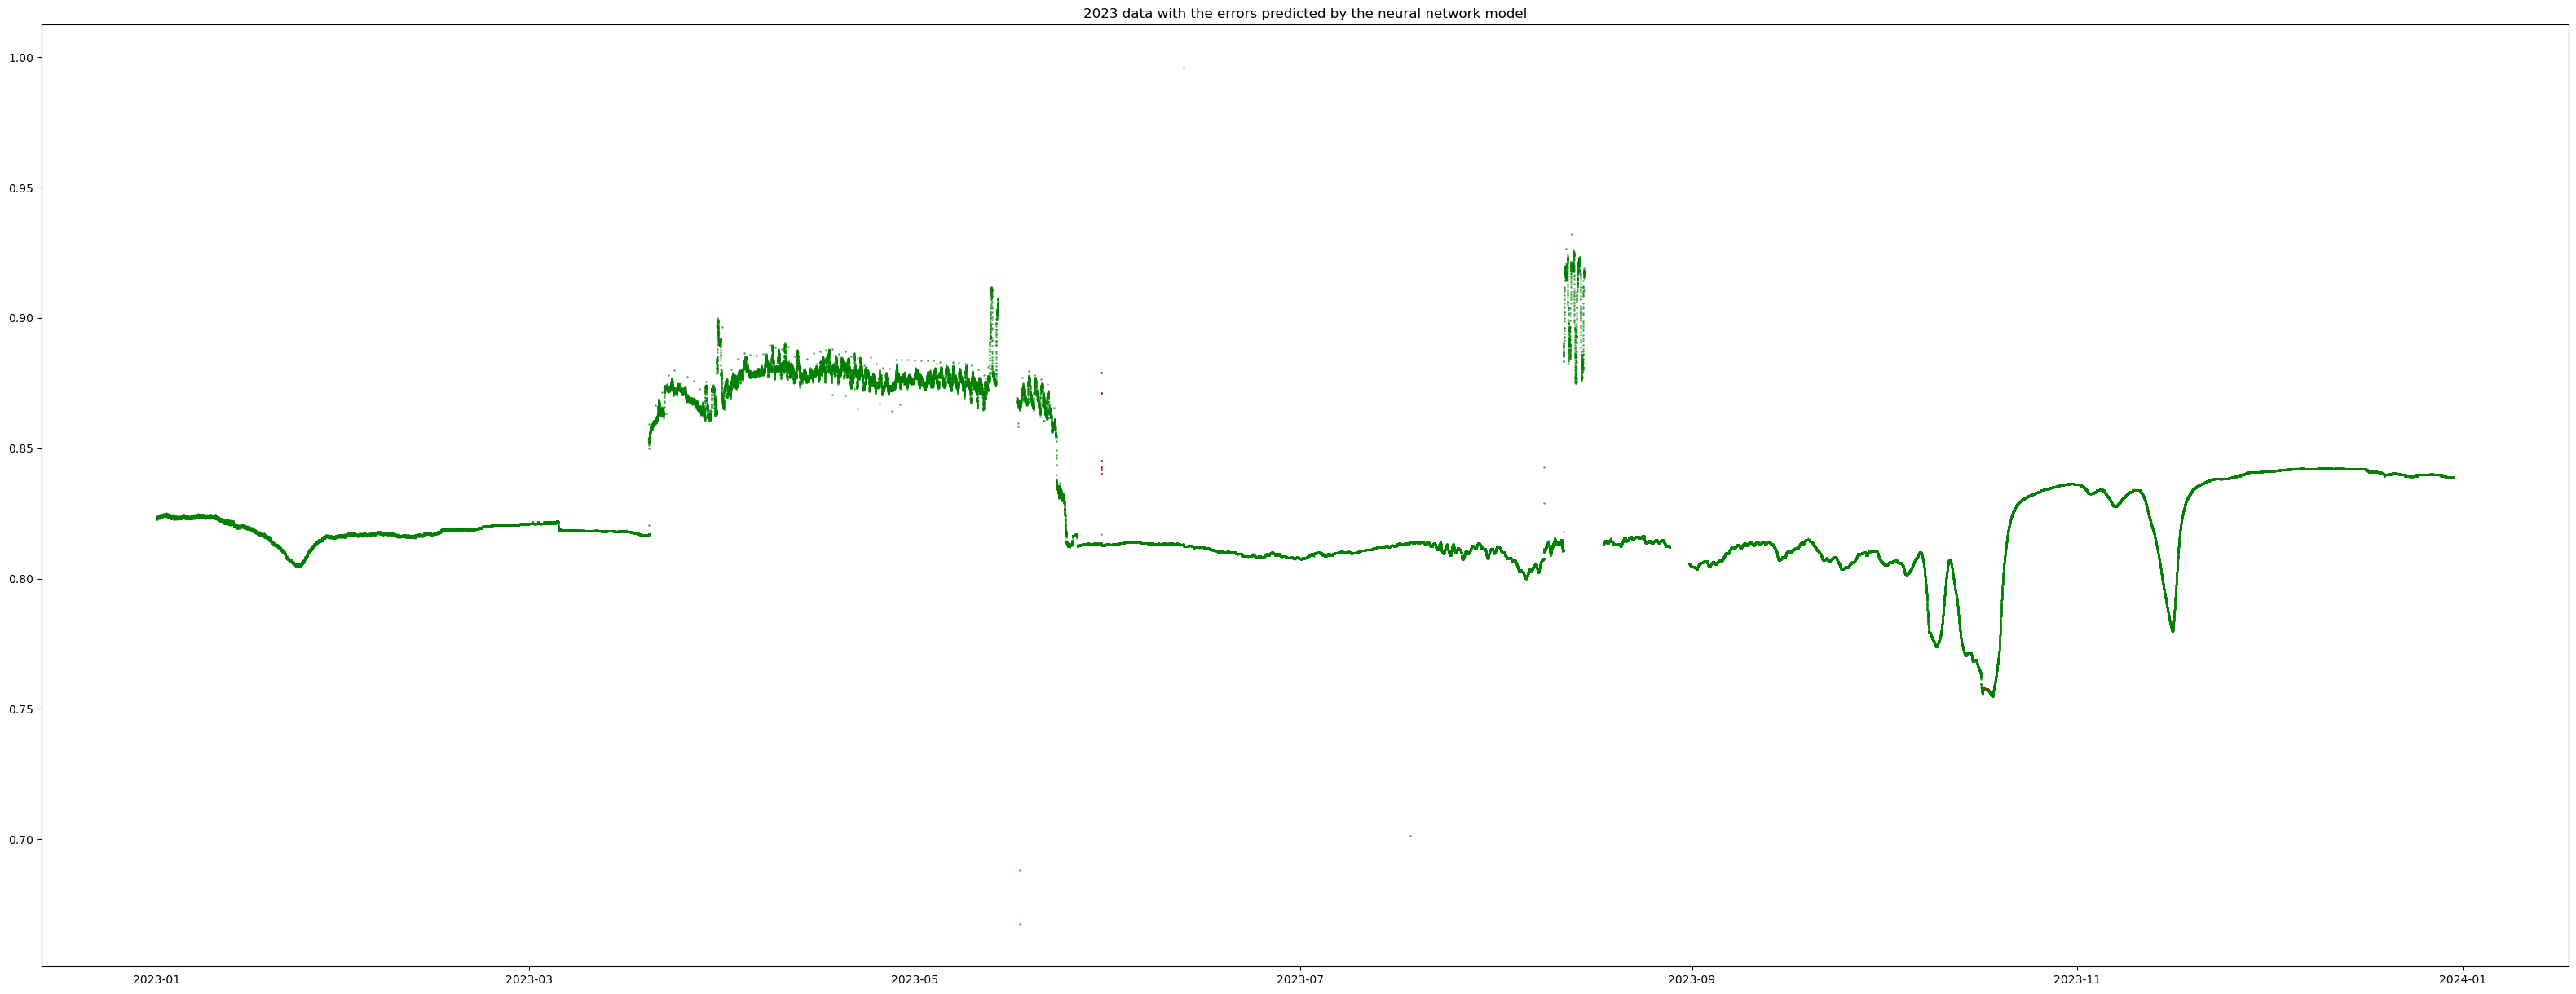

In [125]:
test_scaled_2023 = sensor_data[f'sensor_{2}']["test_scaled_2023"]
model_opt = models[2, Net5, 2.0, 4.0][15]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 2)

In [126]:
pickle.dump(model_opt, open(results_folder + sensor_specific_folder + "sensor2_final_model_SGD_0.001_hidden_5_units_15_weight_ratio_2", 'wb'))

## Sensor 3

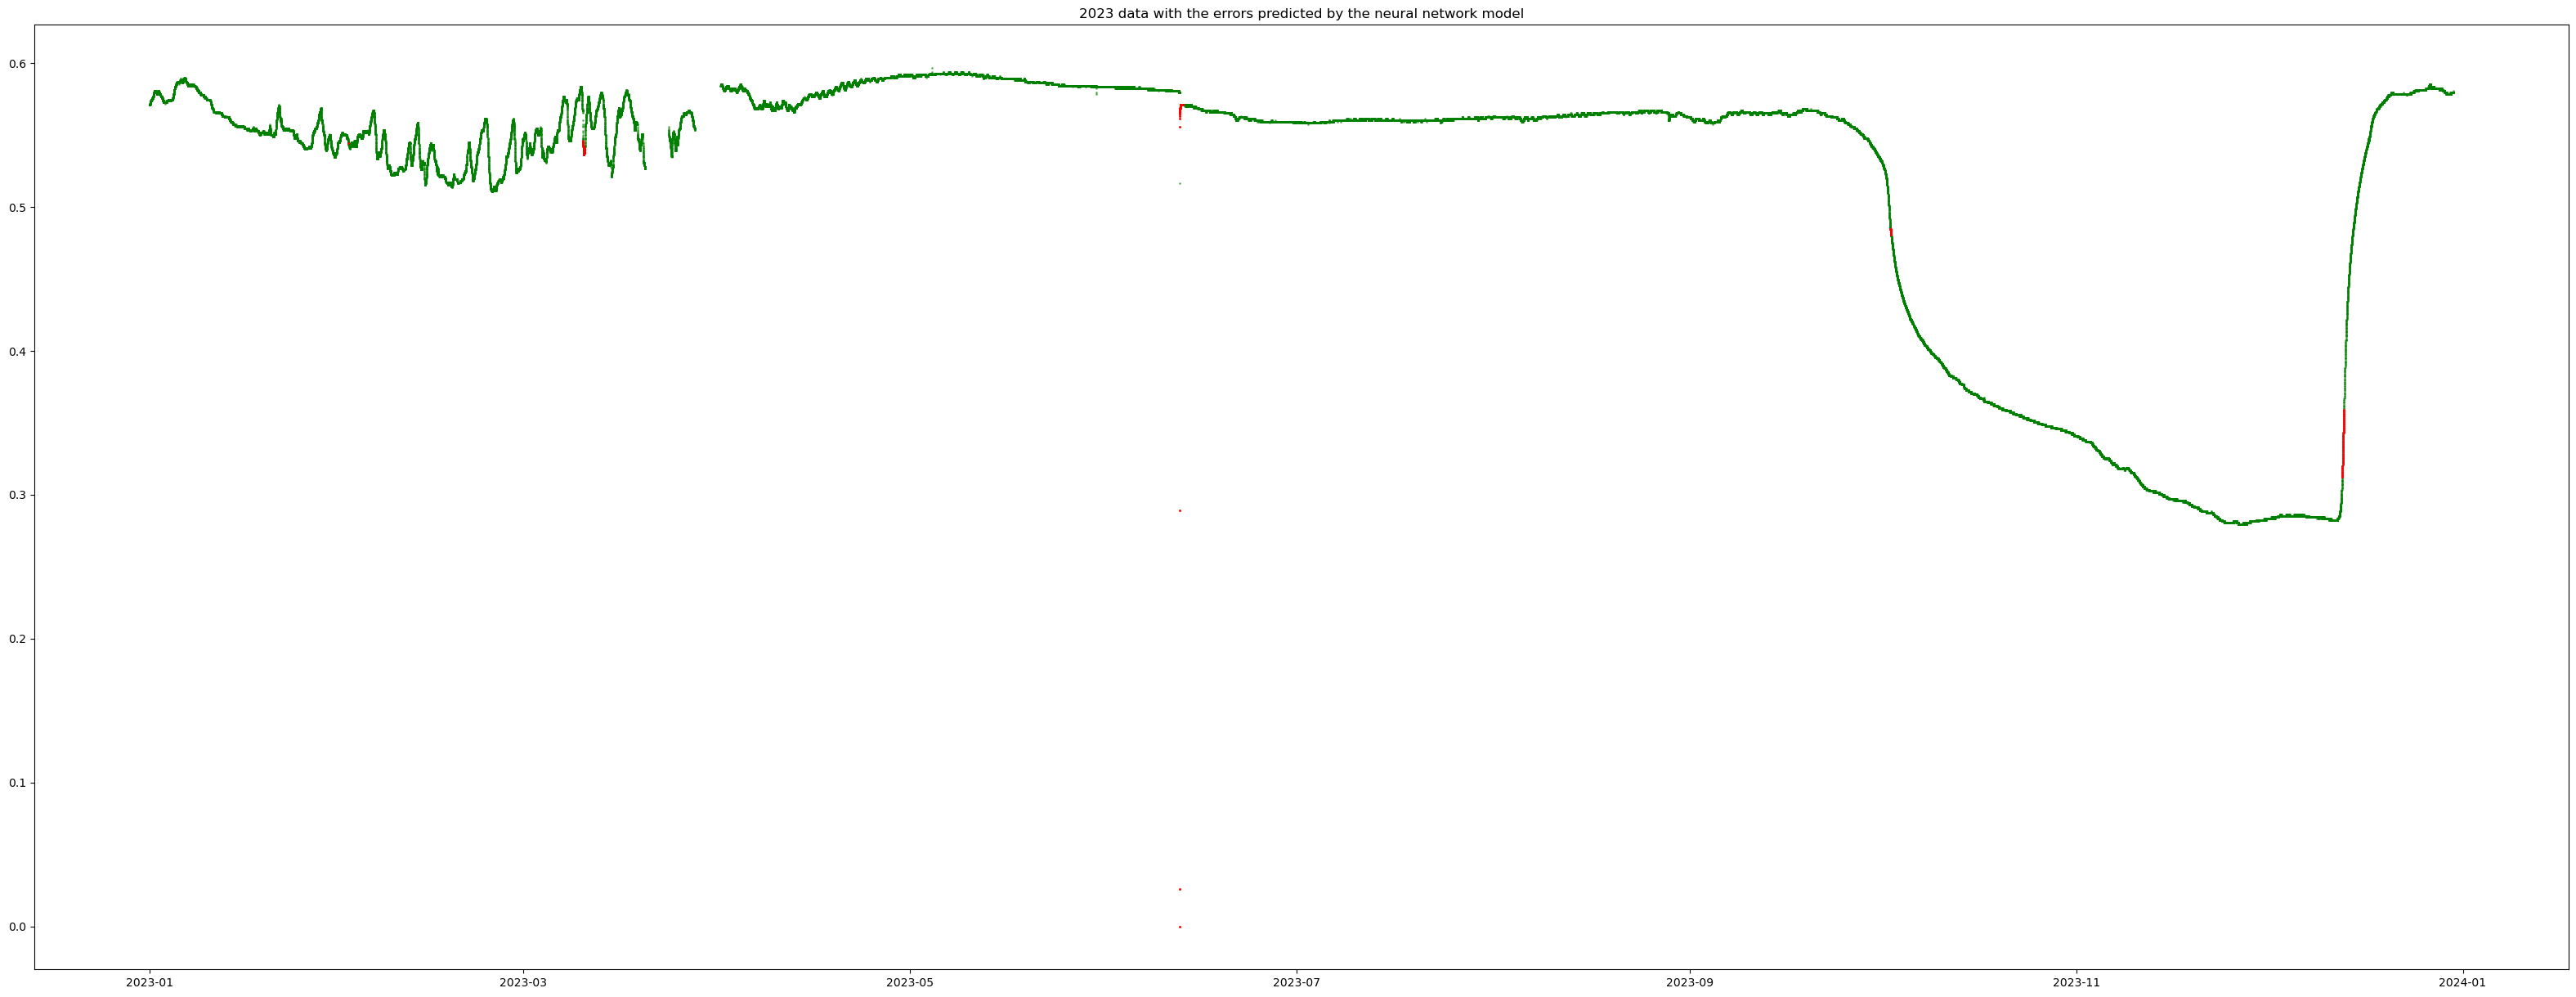

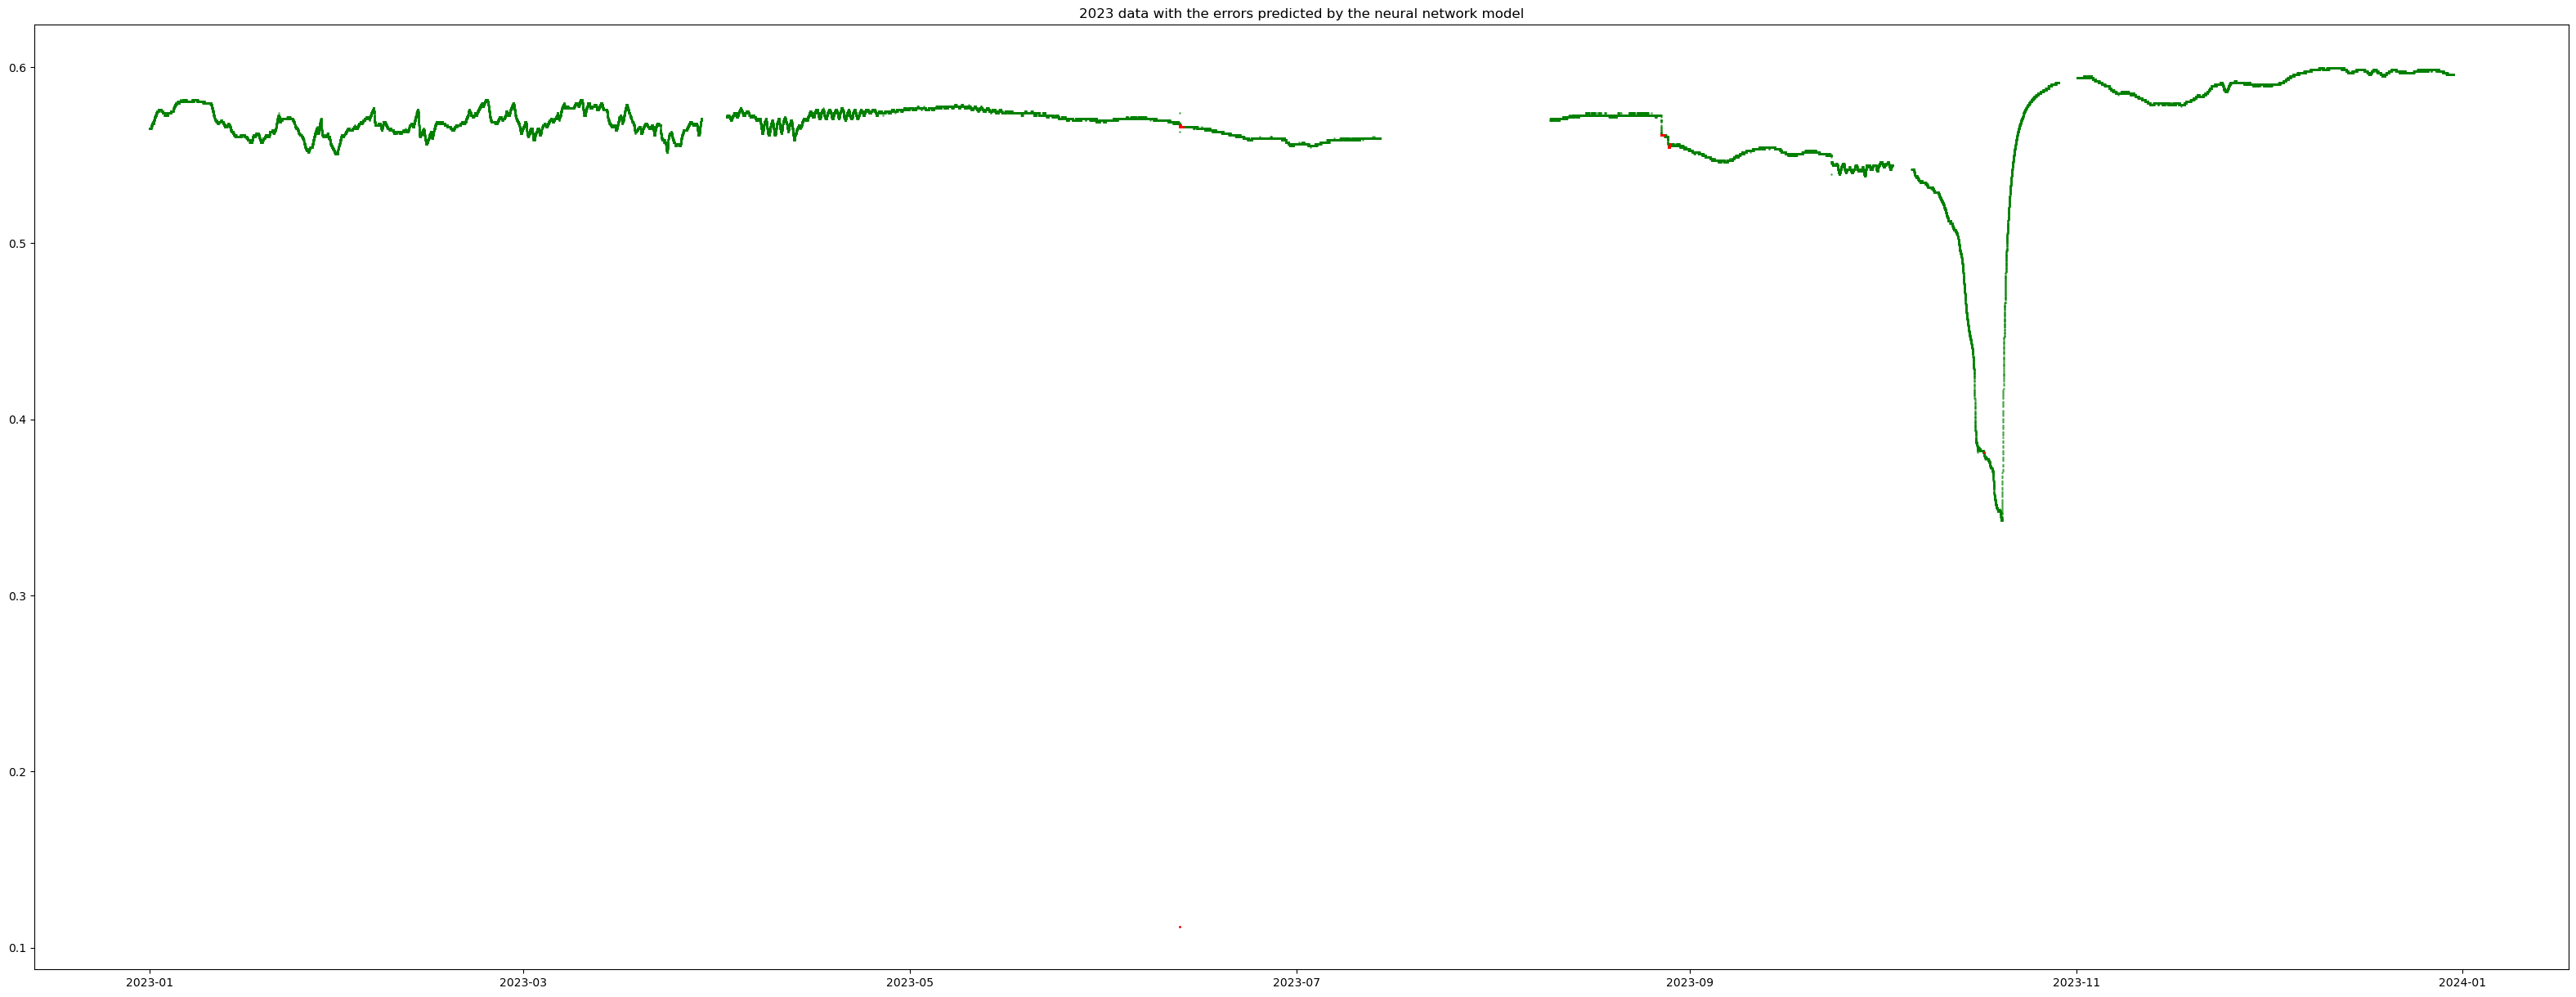

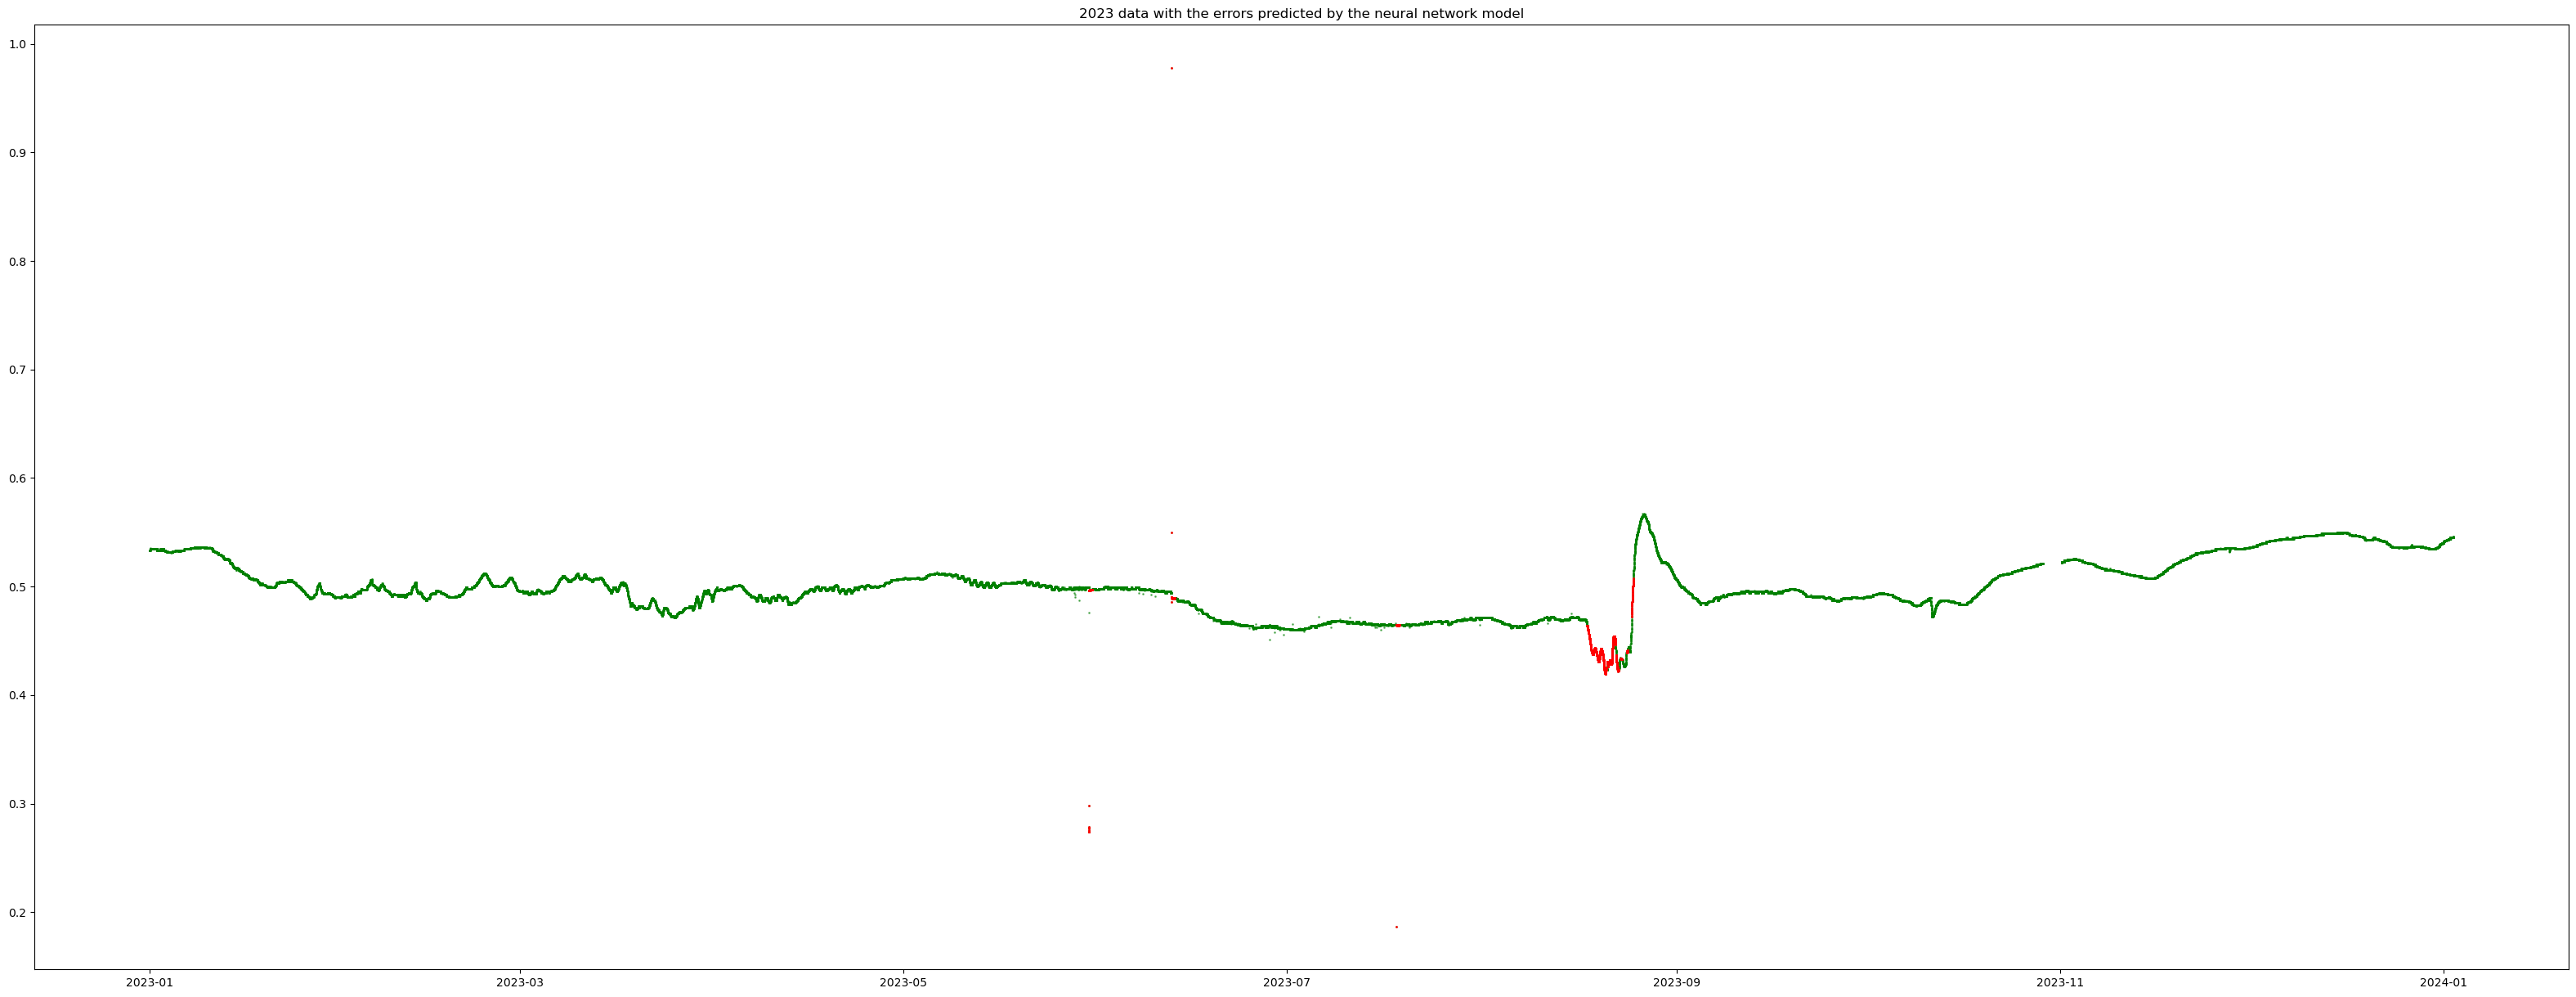

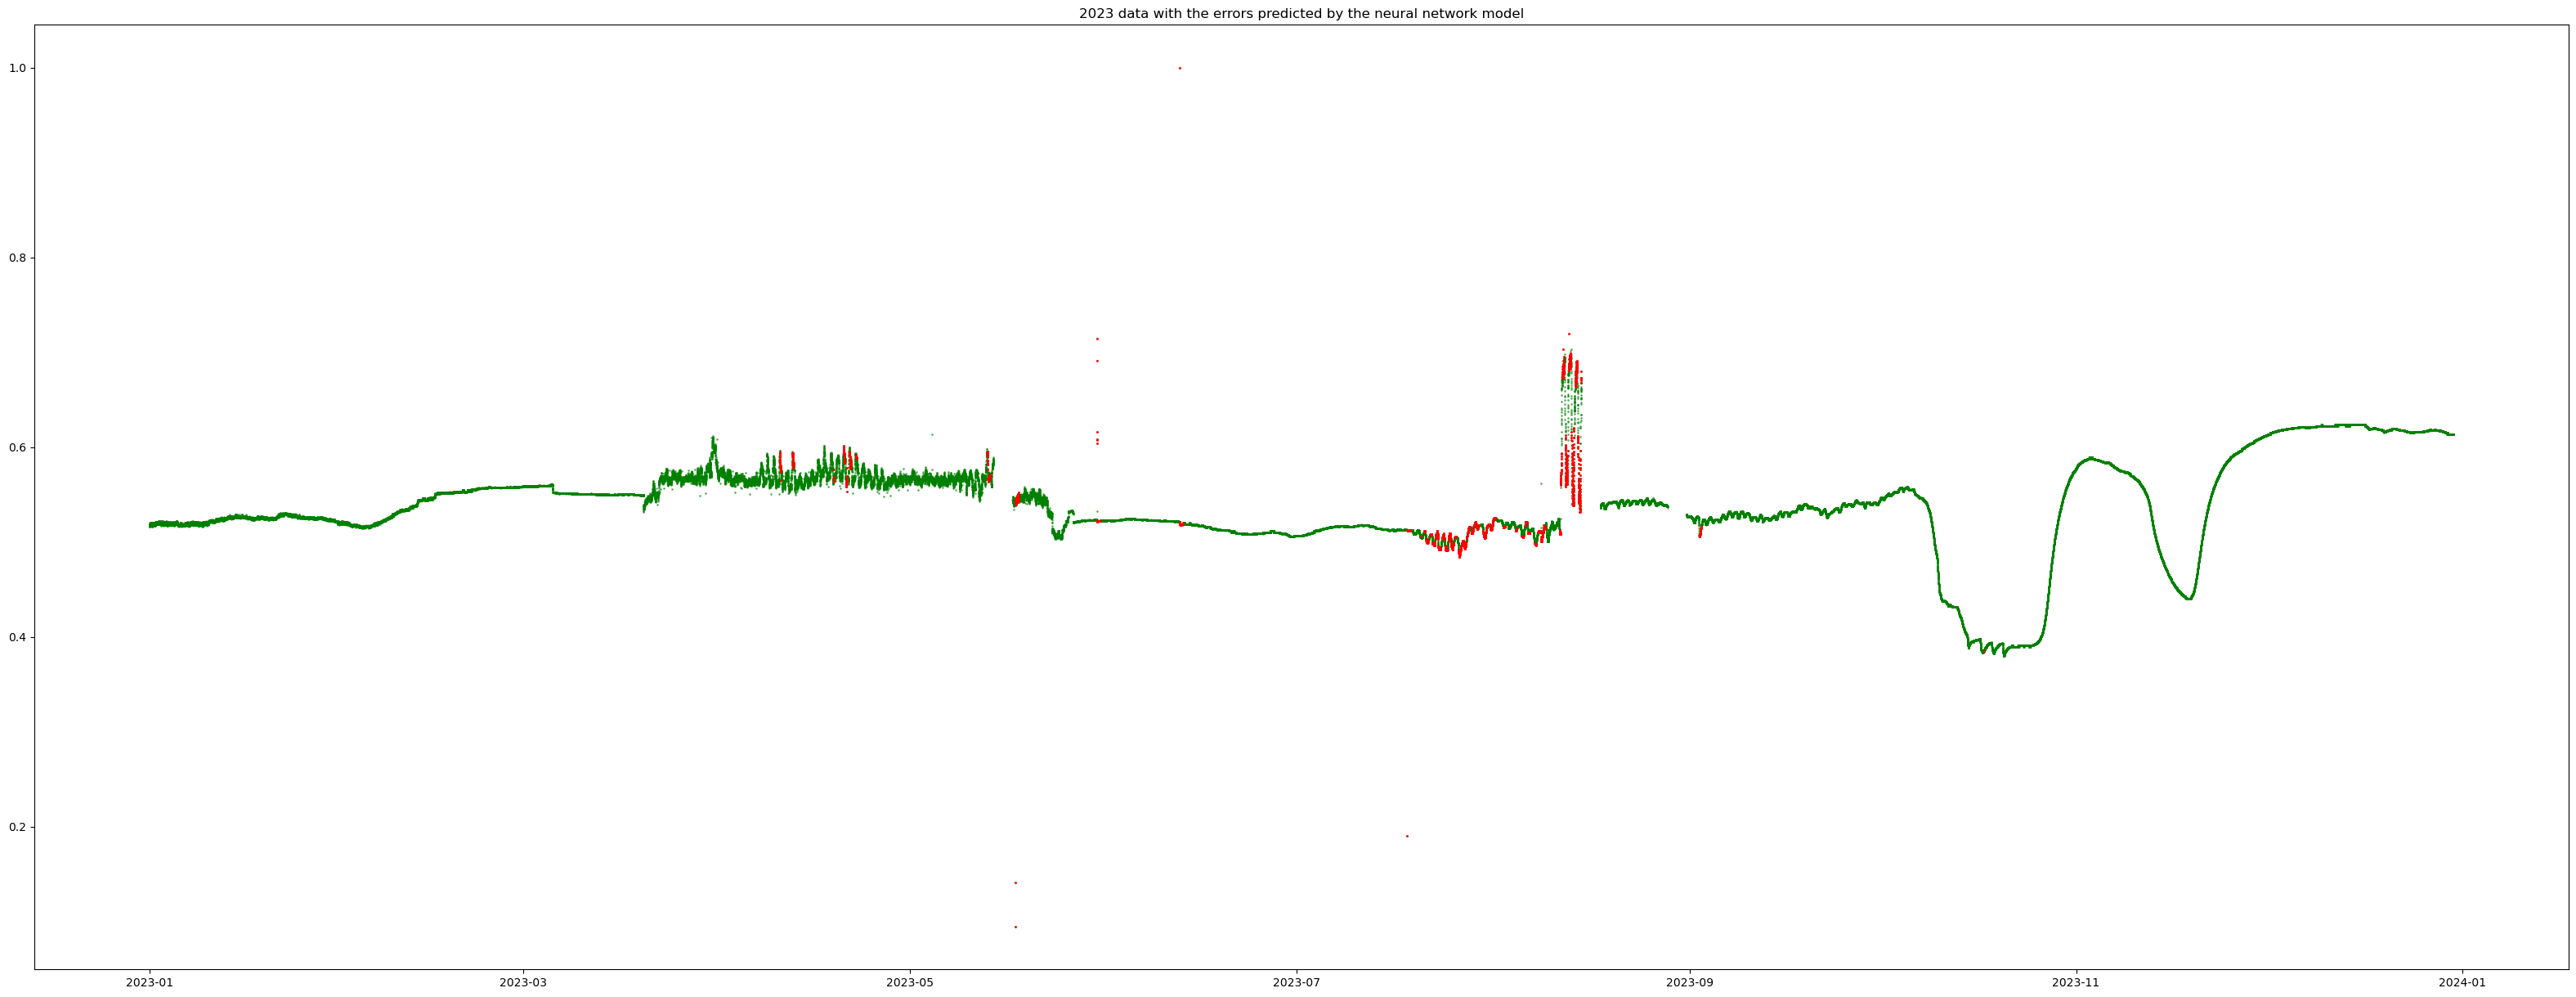

In [127]:
test_scaled_2023 = sensor_data[f'sensor_{3}']["test_scaled_2023"]
model_opt = models[3, Net5, 2.0, 4.0][9]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 3)

In [129]:
pickle.dump(model_opt, open(results_folder + sensor_specific_folder + "sensor3_final_model_SGD_0.001_hidden_5_units_9_weight_ratio_2", 'wb'))

## Sensor 4

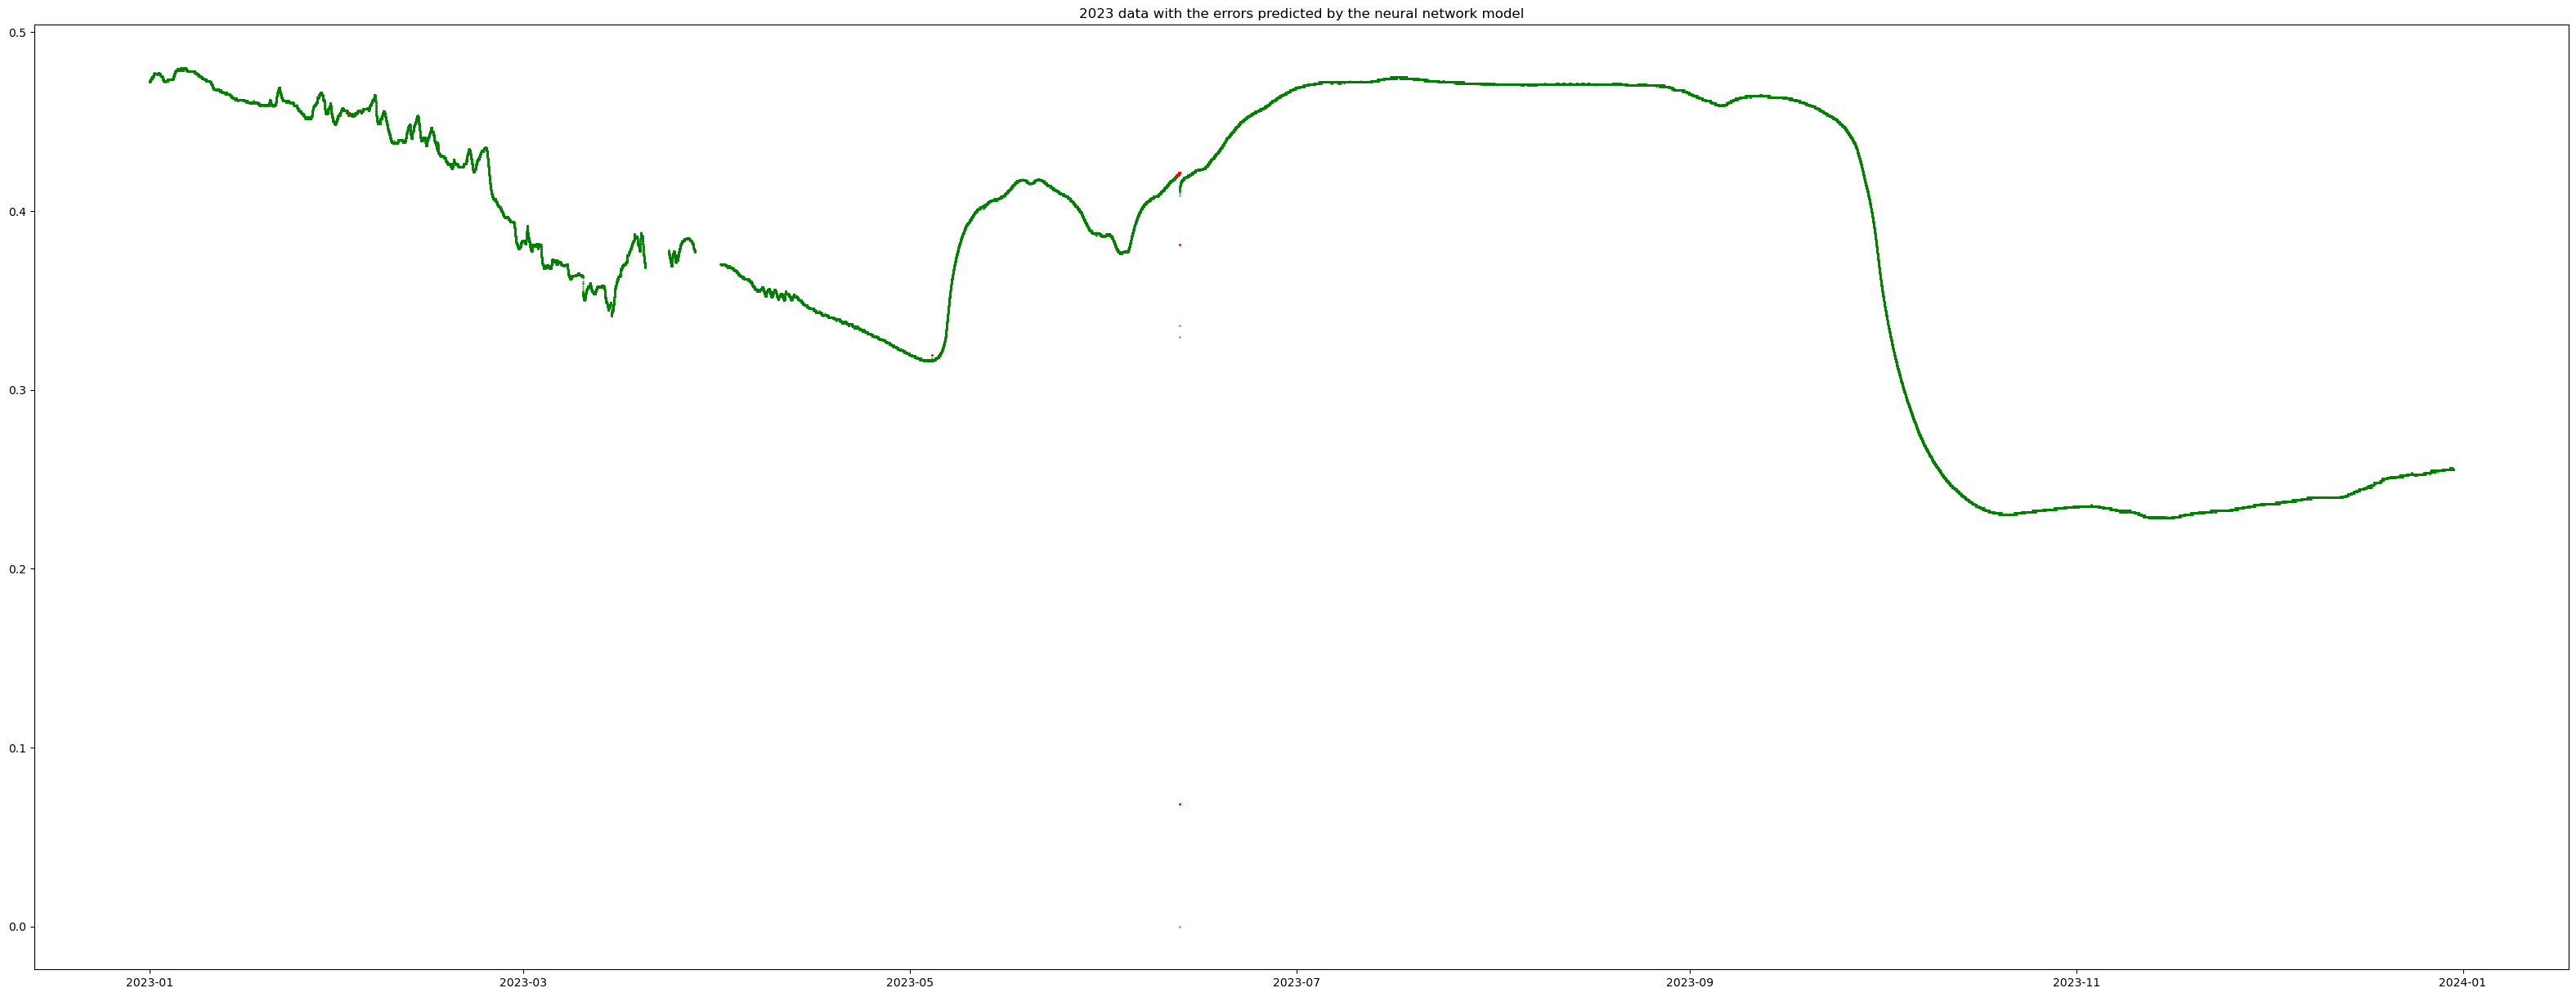

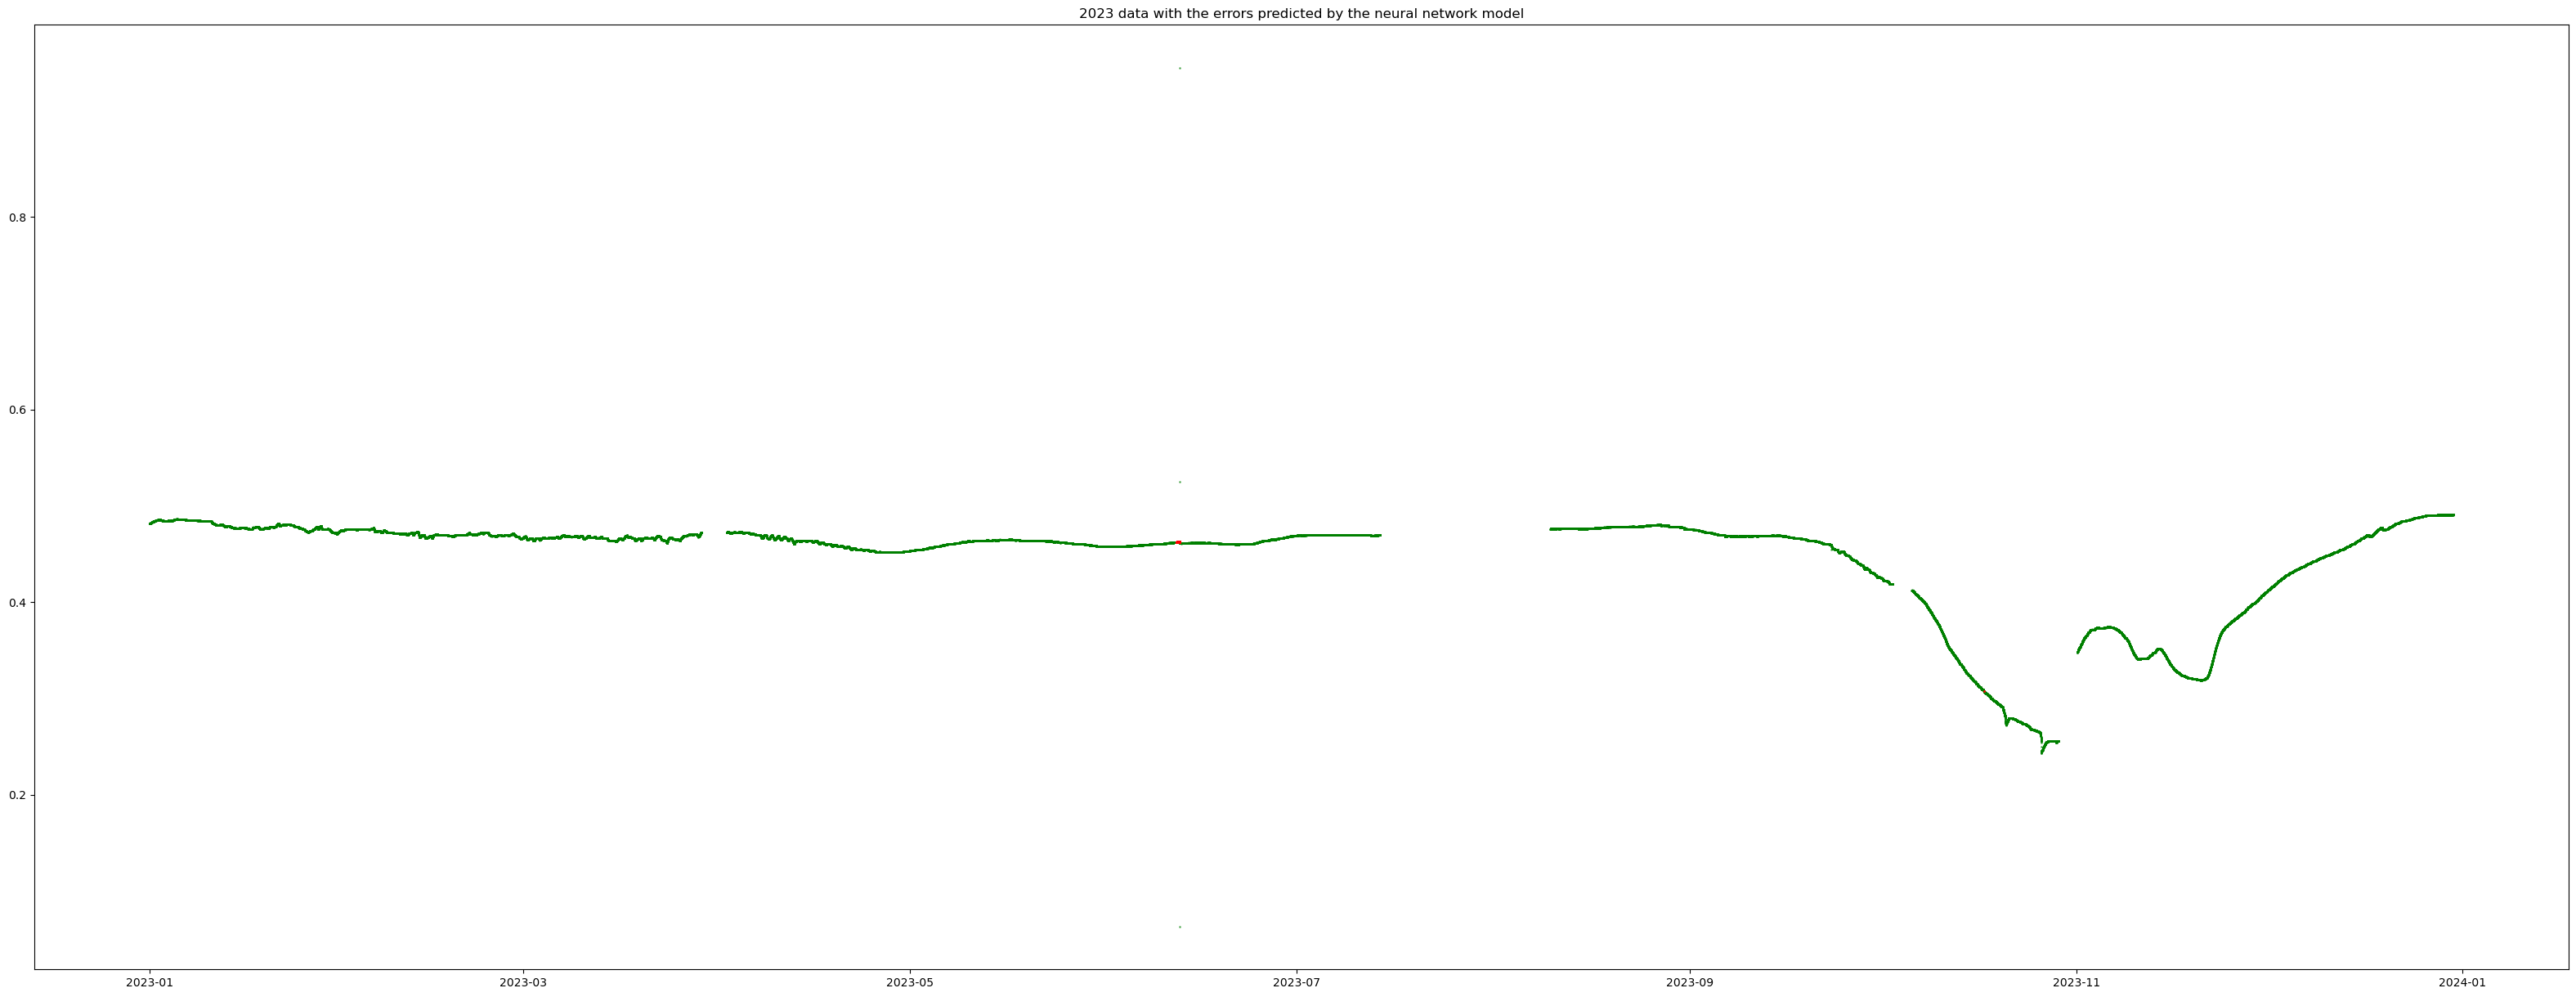

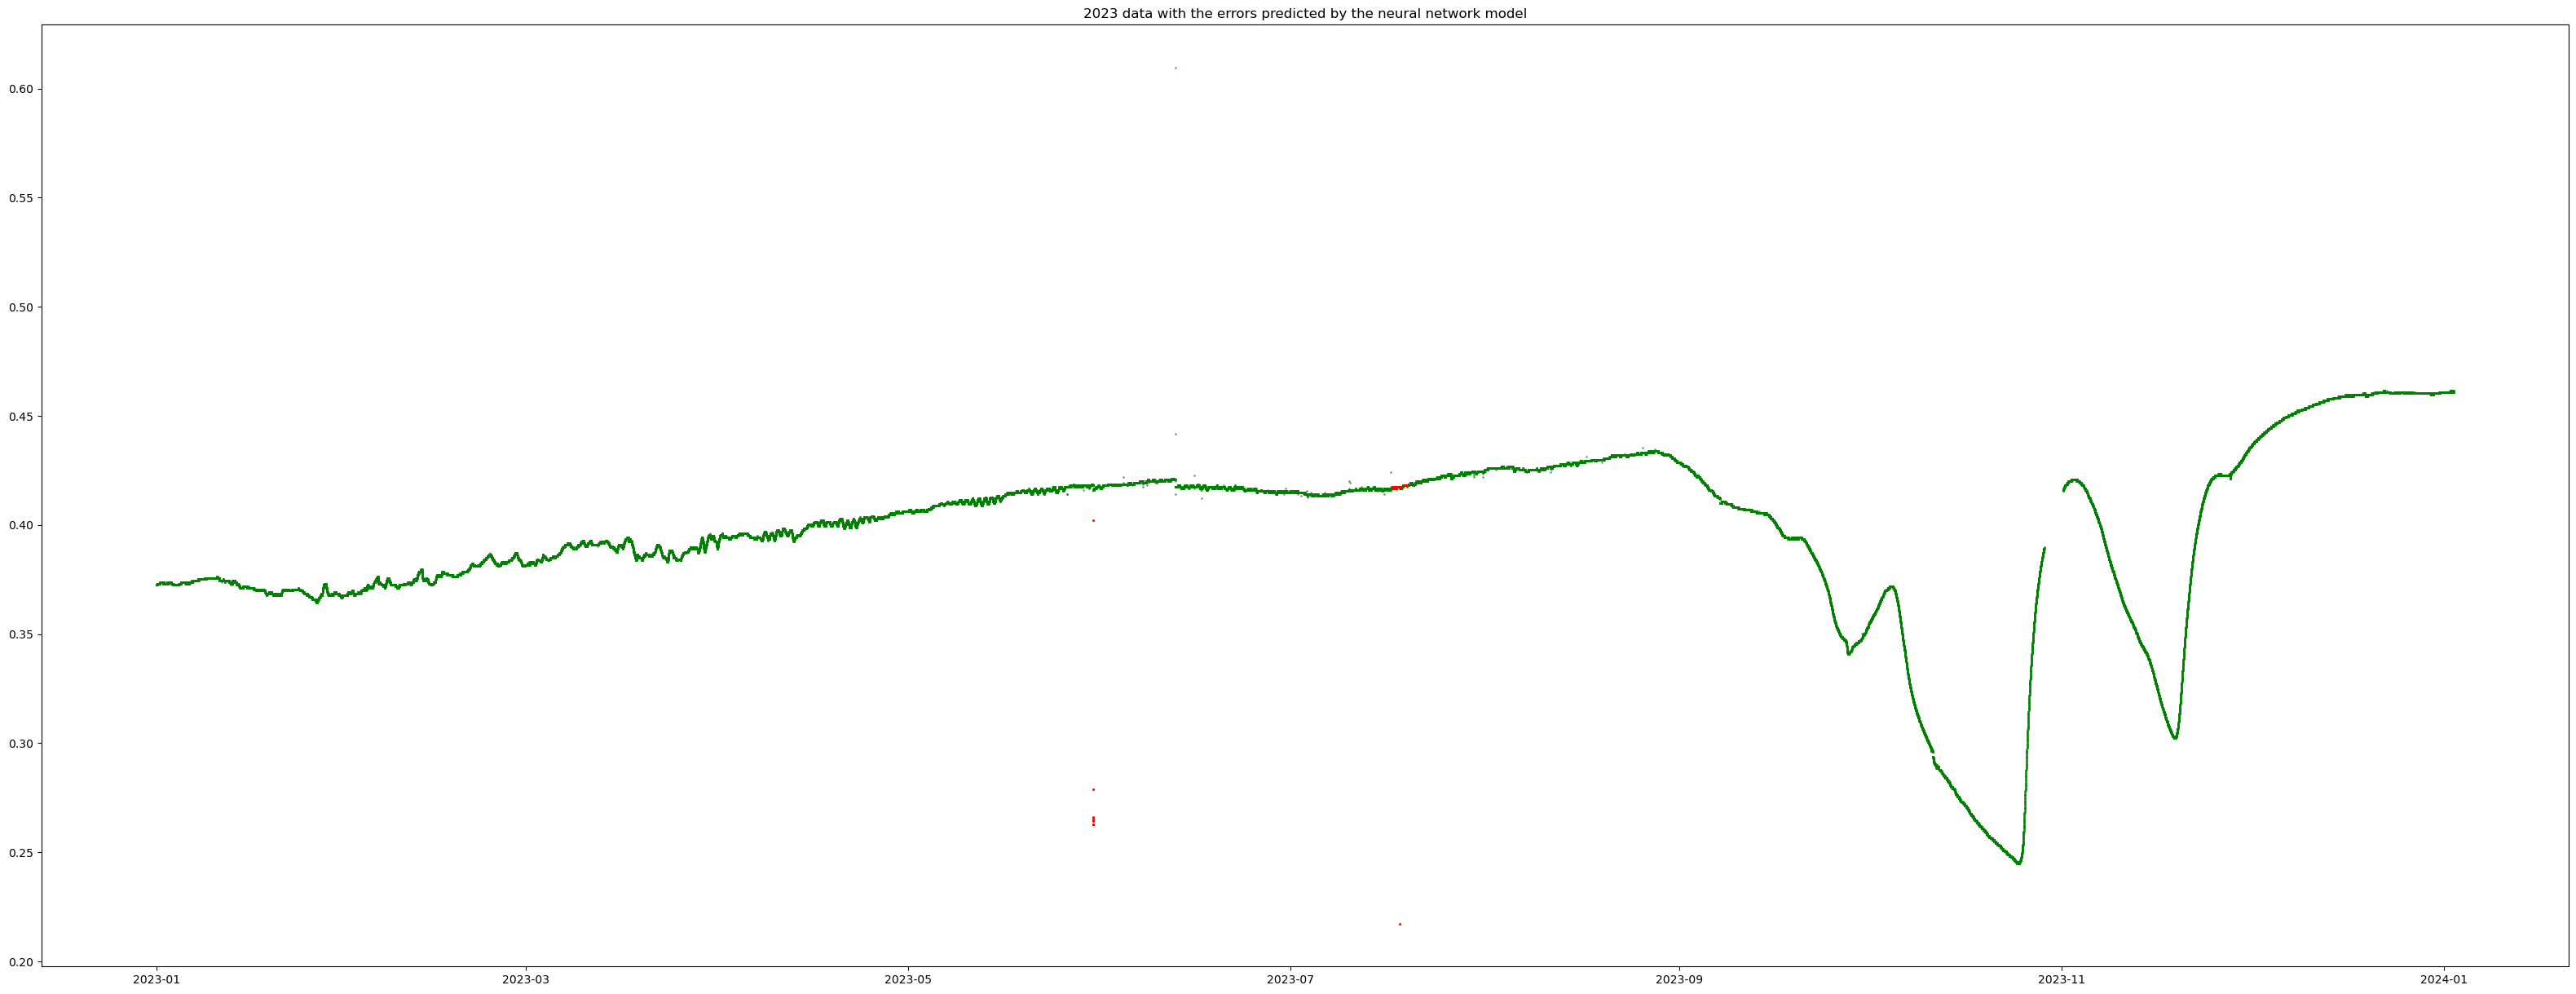

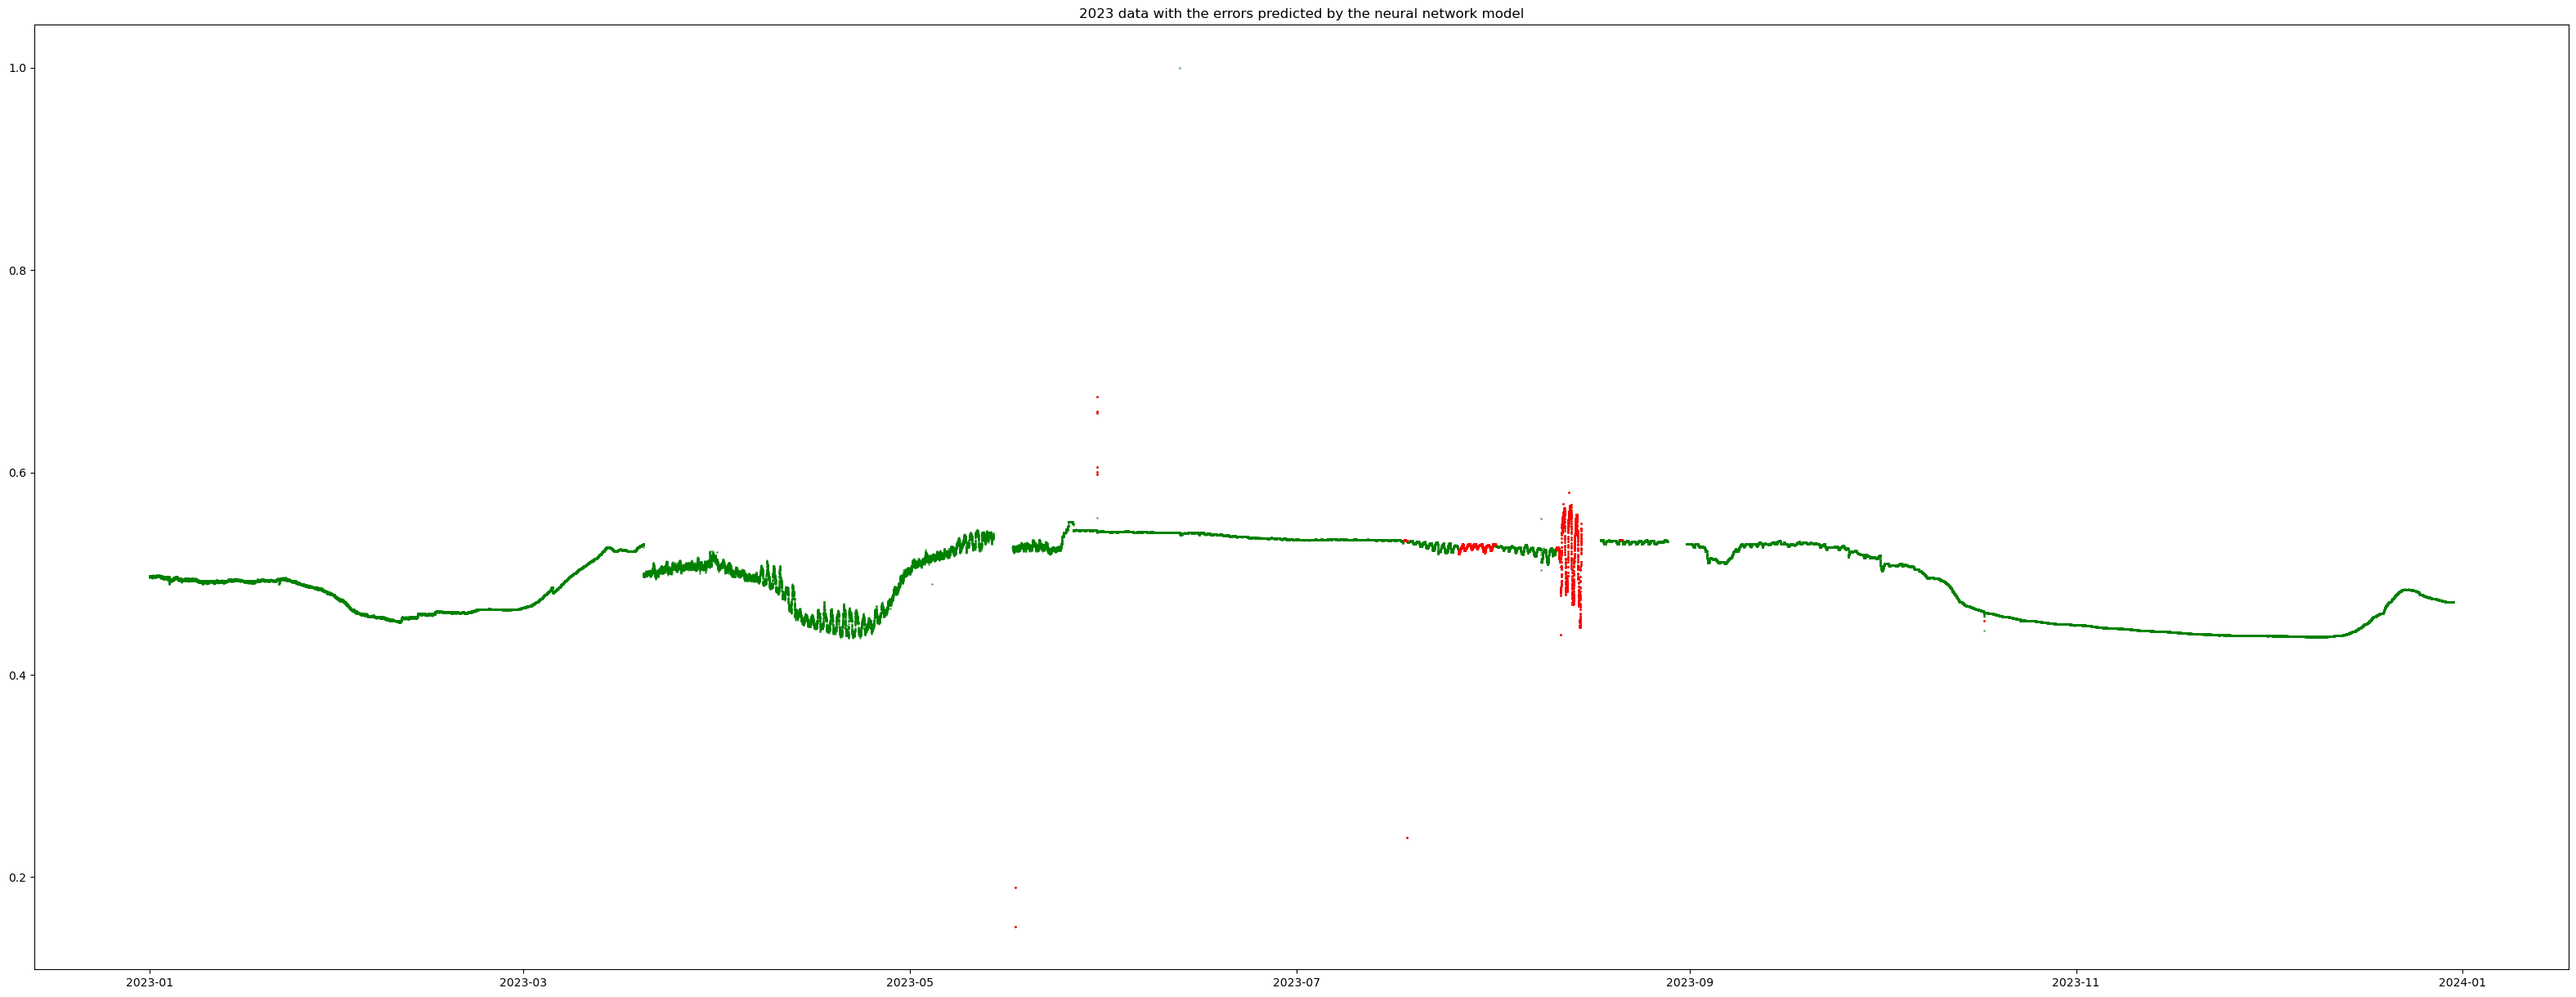

In [130]:
test_scaled_2023 = sensor_data[f'sensor_{4}']["test_scaled_2023"]
model_opt = models[4, Net5, 2.0, 4.0][11]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 4)

In [131]:
pickle.dump(model_opt, open(results_folder + sensor_specific_folder + "sensor4_final_model_SGD_0.001_hidden_5_units_11_weight_ratio_2", 'wb'))

## Sensor 5

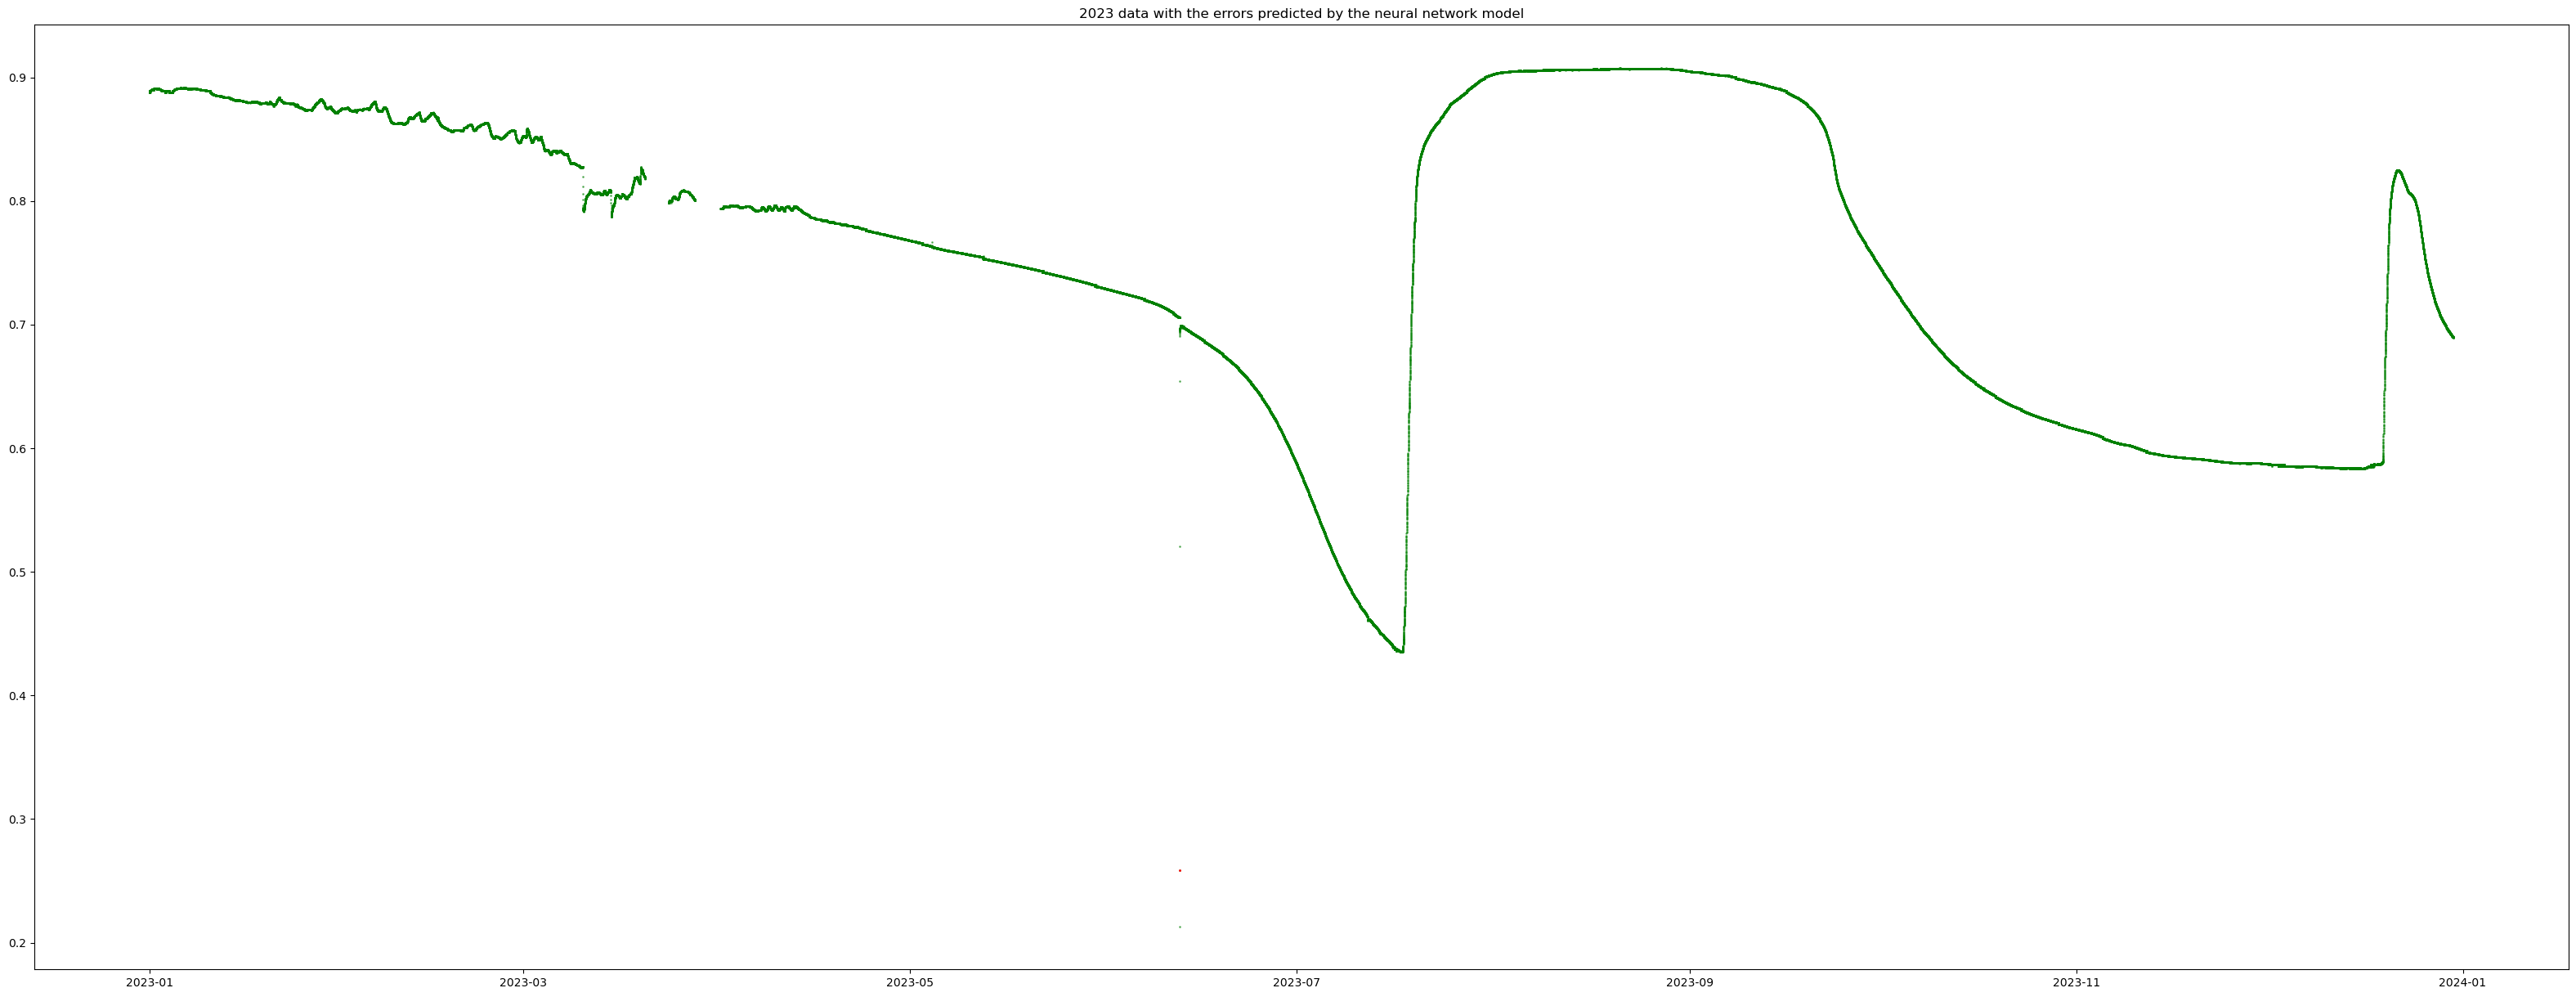

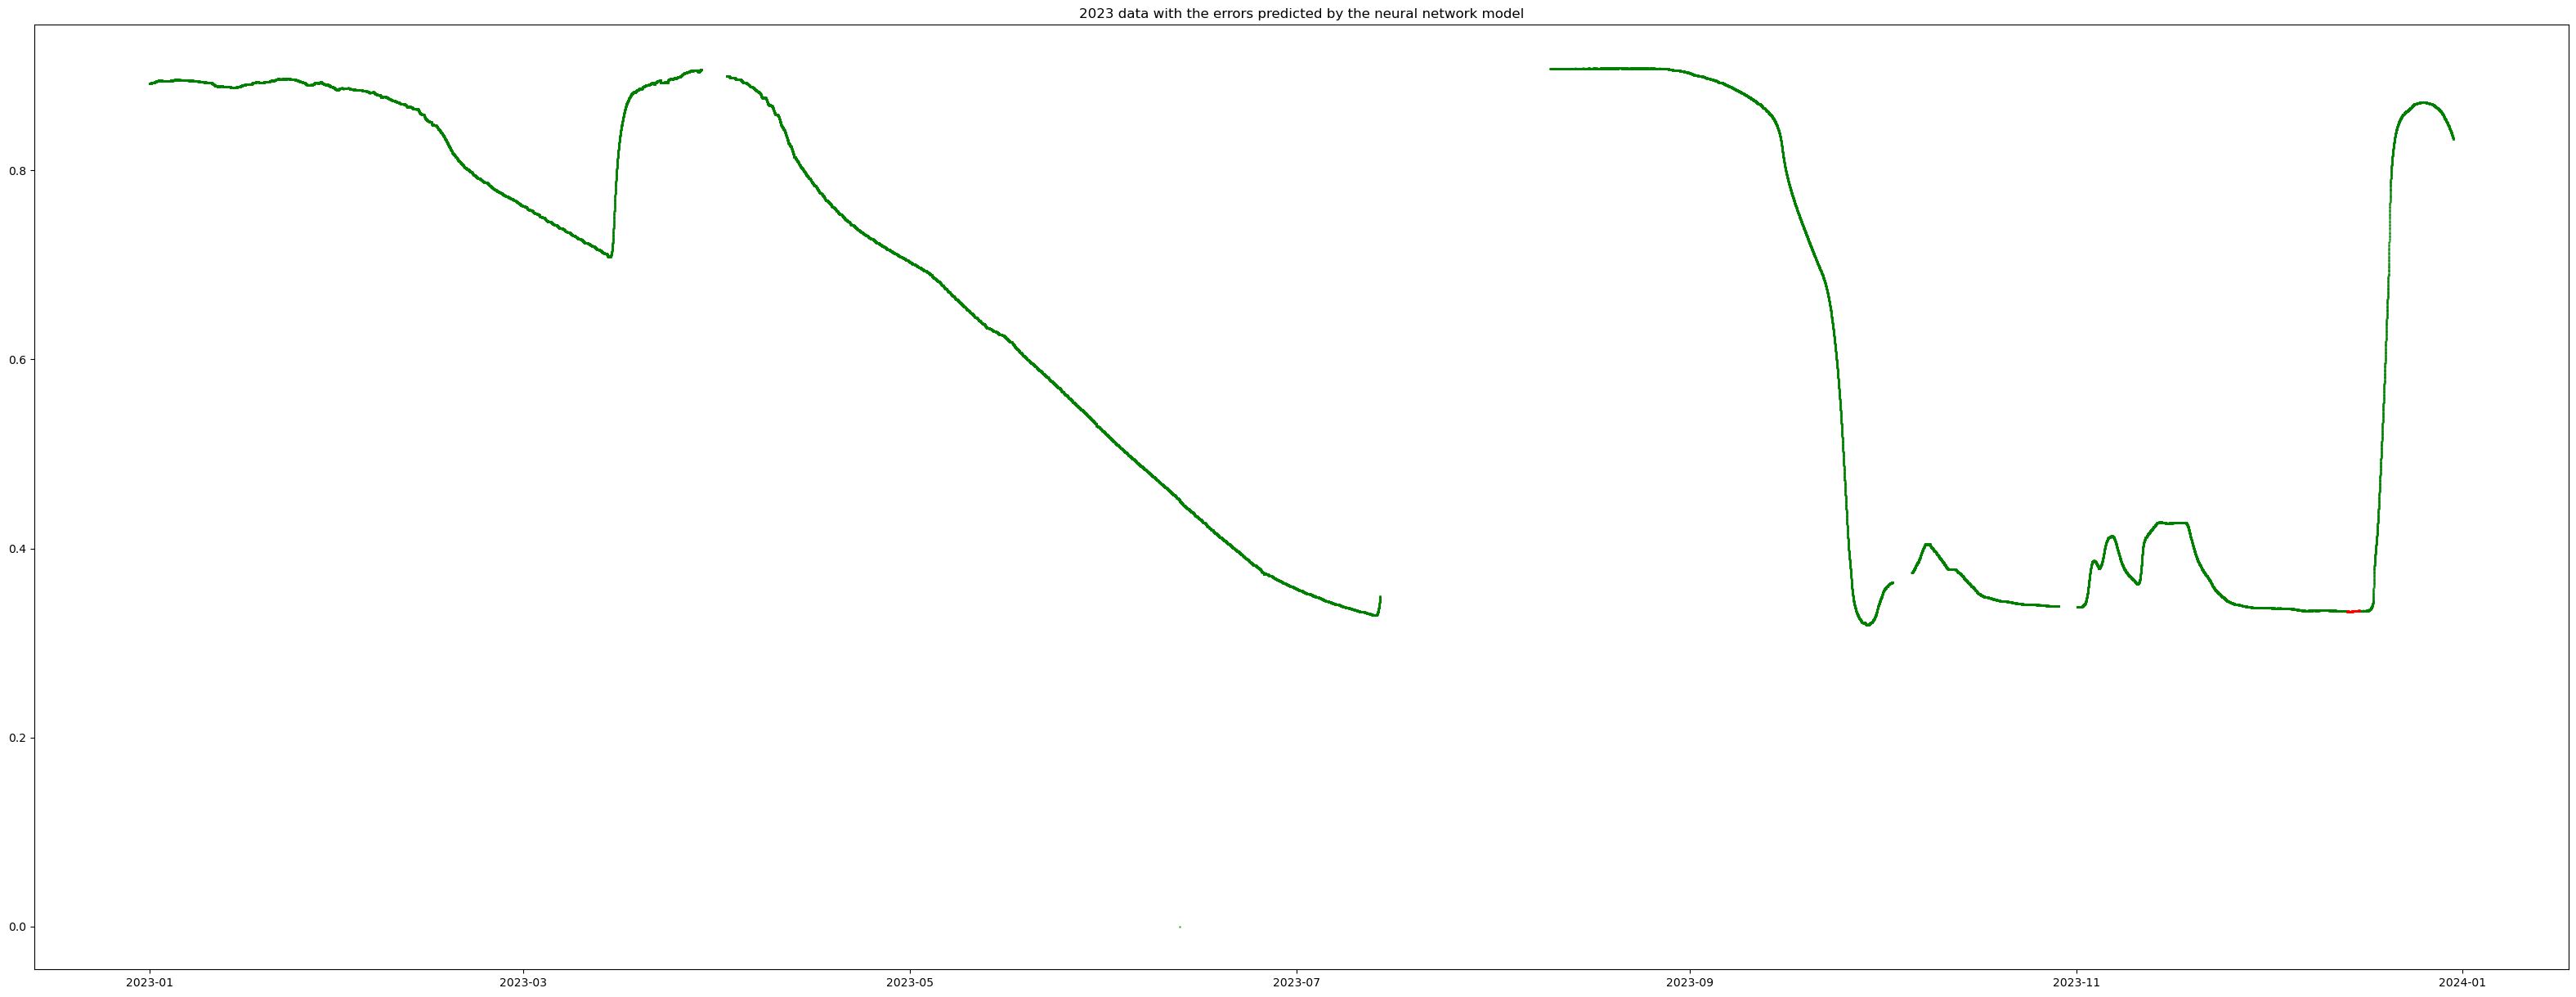

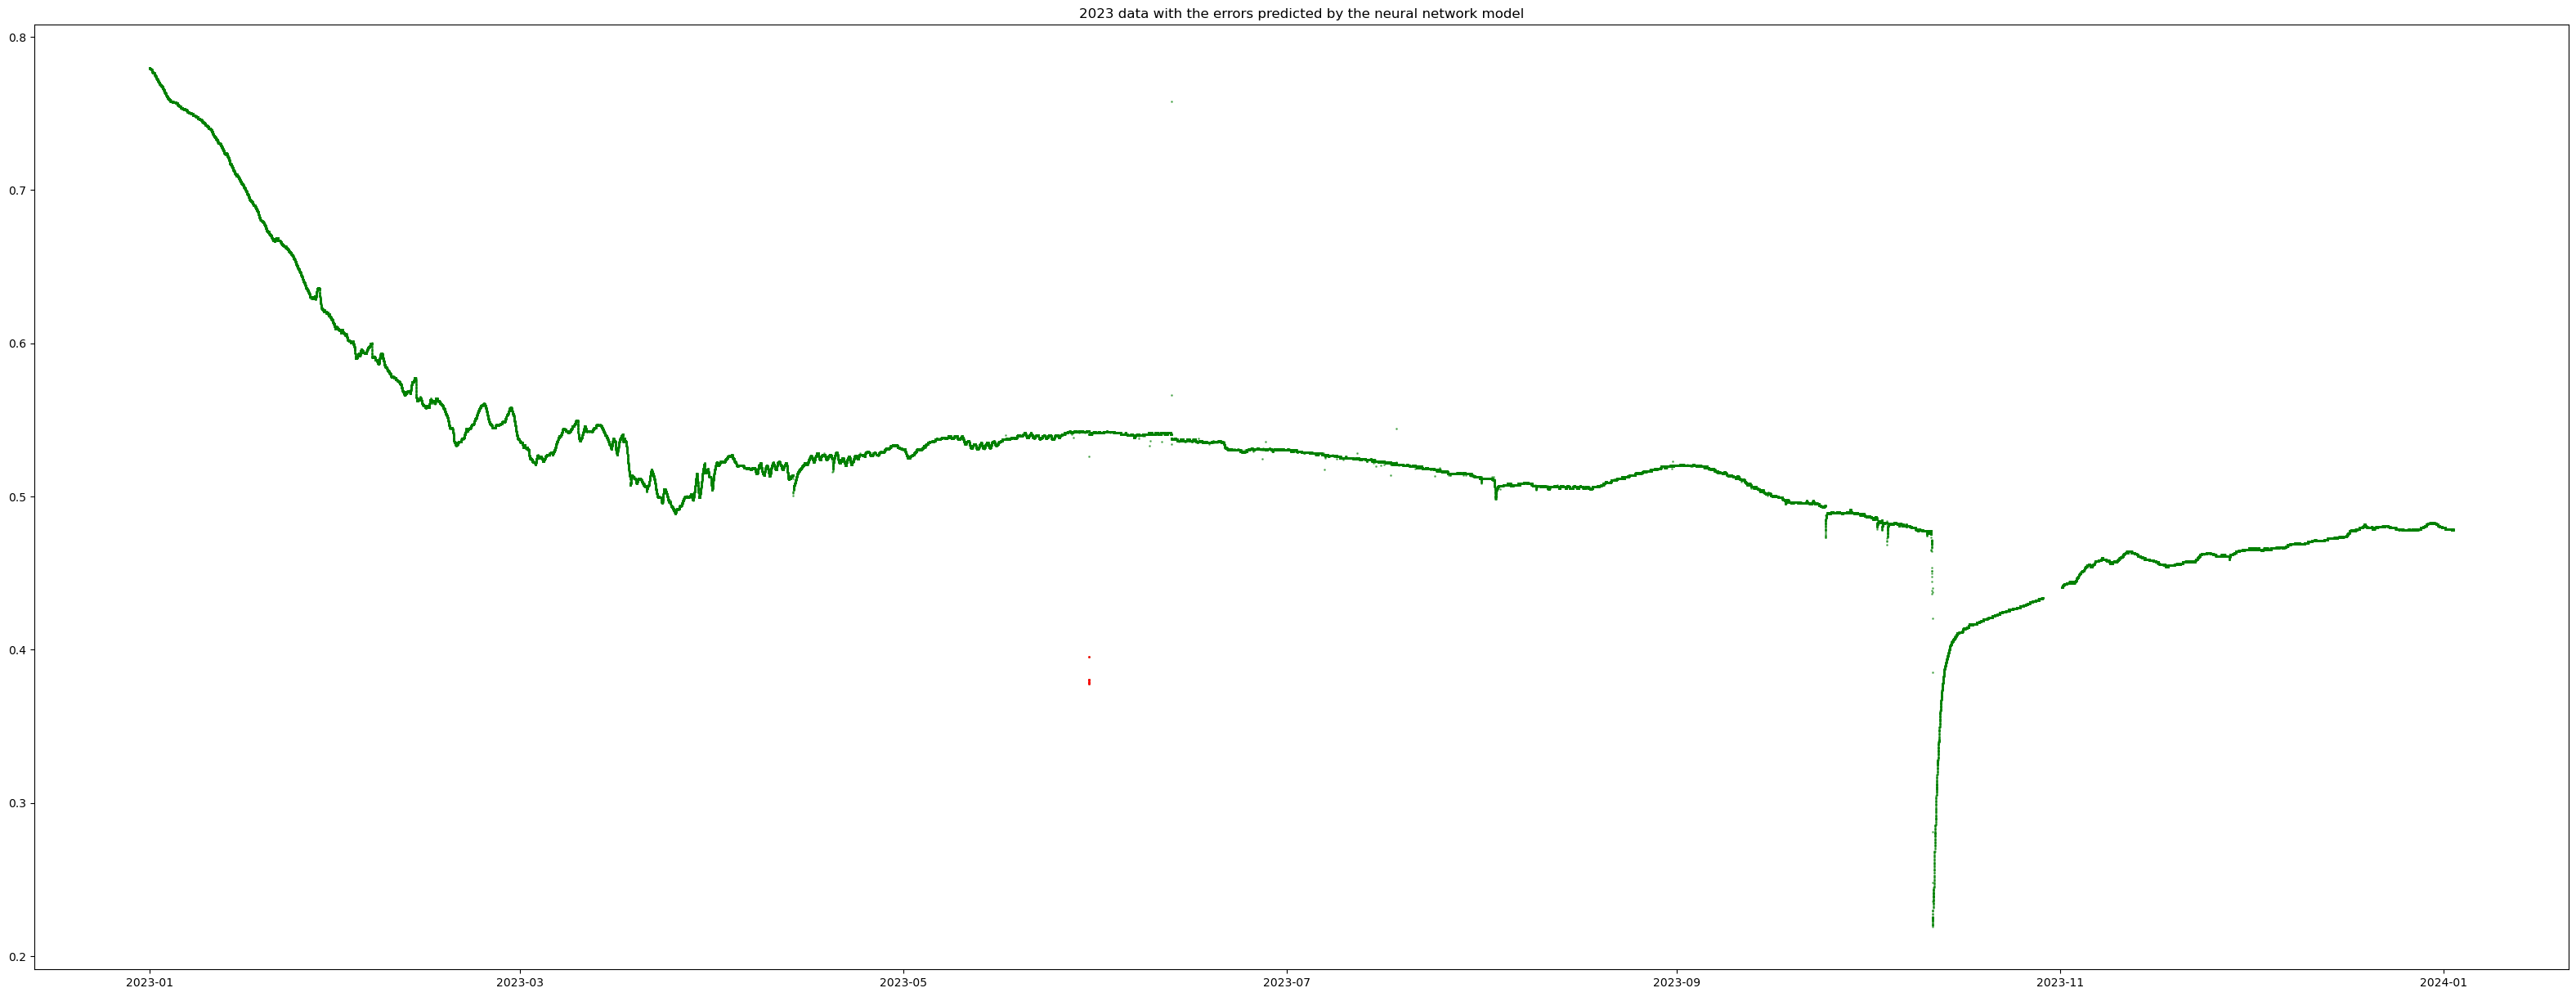

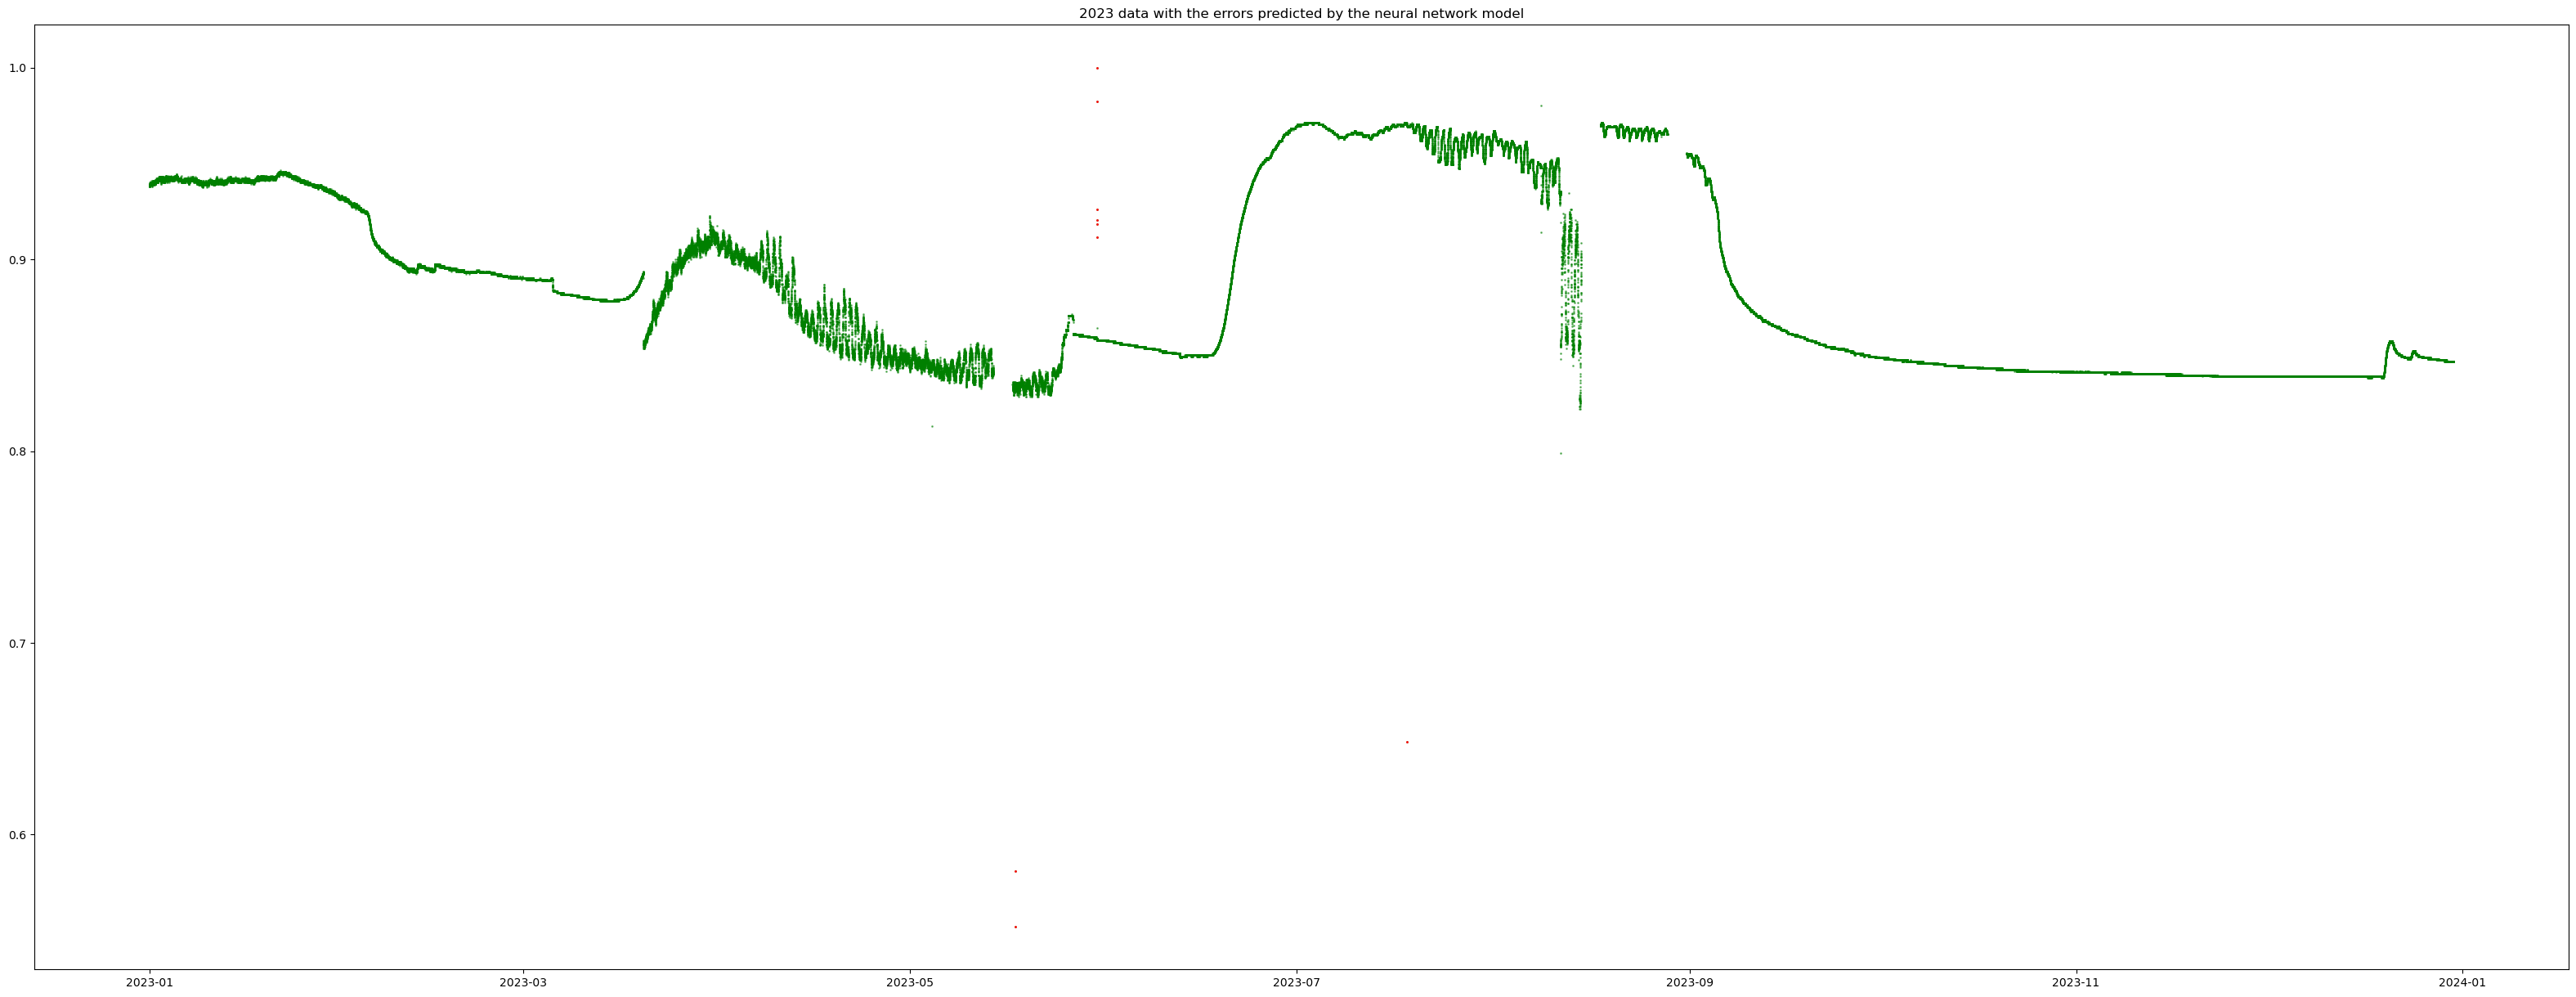

In [132]:
test_scaled_2023 = sensor_data[f'sensor_{5}']["test_scaled_2023"]
model_opt = models[5, Net3, 2.0, 4.0][5]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 5)

In [133]:
pickle.dump(model_opt, open(results_folder + sensor_specific_folder + "sensor5_final_model_SGD_0.001_hidden_3_units_5_weight_ratio_2", 'wb'))

### All sensors trained with Adam, alpha = 0.01 and epochs = 25 

In [95]:
models_all_sensors_dict_Adam = pickle.load(open(results_folder + "all_sensors_Adam_0.01_models_dict", 'rb'))

In [96]:
all_sensor_train_test_results_final_table_df_Adam = pickle.load(open(results_folder + "all_sensors_Adam_0.01_results_df", 'rb'))

In [97]:
all_sensor_train_test_results_final_table_df_Adam

architecture  weight_normal  weight_anomaly  number_of_units  ...  train_recall  test_log_likelihood  test_accuracy  test_recall
0             3            2.0             2.0                3  ...      0.999727         2.763904e-05       0.992555     0.999050
1             3            2.0             2.0                5  ...      0.000000         2.742177e-04       0.923685     0.000000
2             3            2.0             2.0                7  ...      0.998501         1.617238e-04       0.951049     0.995882
3             3            2.0             2.0                9  ...      0.997137         3.874578e-05       0.993231     0.911625
4             3            2.0             2.0               11  ...      0.999046         1.914633e-06       0.999710     0.998416
5             3            2.0             2.0               13  ...      0.999591         1.042005e-05       0.997317     0.973709
6             3            2.0             2.0               15  ...      1.000000         7.709906e-07       0.999927     0.999683
0             3            2.0             4.0                3  ...      0.000000         4.147159e-04       0.923685     0.000000
1             3            2.0             4.0                5  ...      0.999727         3.276381e-05       0.994126     0.993348
2             3            2.0             4.0                7  ...      0.985414         3.739528e-04       0.909133     0.986696
3             3            2.0             4.0                9  ...      0.999455         4.900496e-06       0.998816     0.984479
4             3            2.0             4.0               11  ...      0.999864         1.763590e-05       0.994488     0.956288
5             3            2.0             4.0               13  ...      0.994275         1.124283e-05       0.998501     0.997149
6             3            2.0             4.0               15  ...      0.999455         1.553219e-05       0.997341     0.965790
0             5            2.0             2.0                3  ...      0.000000         2.742050e-04       0.923685     0.000000
1             5            2.0             2.0                5  ...      0.999727         1.445877e-04       0.941356     0.999683
2             5            2.0             2.0                7  ...      0.000000         2.742085e-04       0.923685     0.000000
3             5            2.0             2.0                9  ...      0.000000         2.742014e-04       0.923685     0.000000
4             5            2.0             2.0               11  ...      0.000000         2.742947e-04       0.923685     0.000000
5             5            2.0             2.0               13  ...      0.999864         1.750632e-04       0.929777     0.999683
6             5            2.0             2.0               15  ...      0.993593         3.518615e-05       0.987962     0.842572
0             5            2.0             4.0                3  ...      0.000000         4.148606e-04       0.923685     0.000000
1             5            2.0             4.0                5  ...      0.999182         4.775176e-04       0.772602     0.999683
2             5            2.0             4.0                7  ...      0.999864         3.308855e-04       0.861681     0.999683
3             5            2.0             4.0                9  ...      0.999864         1.726382e-06       0.999831     0.999050
4             5            2.0             4.0               11  ...      0.999864         3.517922e-04       0.858731     0.999683
5             5            2.0             4.0               13  ...      0.000000         4.148738e-04       0.923685     0.000000
6             5            2.0             4.0               15  ...      0.998773         2.405250e-05       0.997583     0.968958

[28 rows x 10 columns]

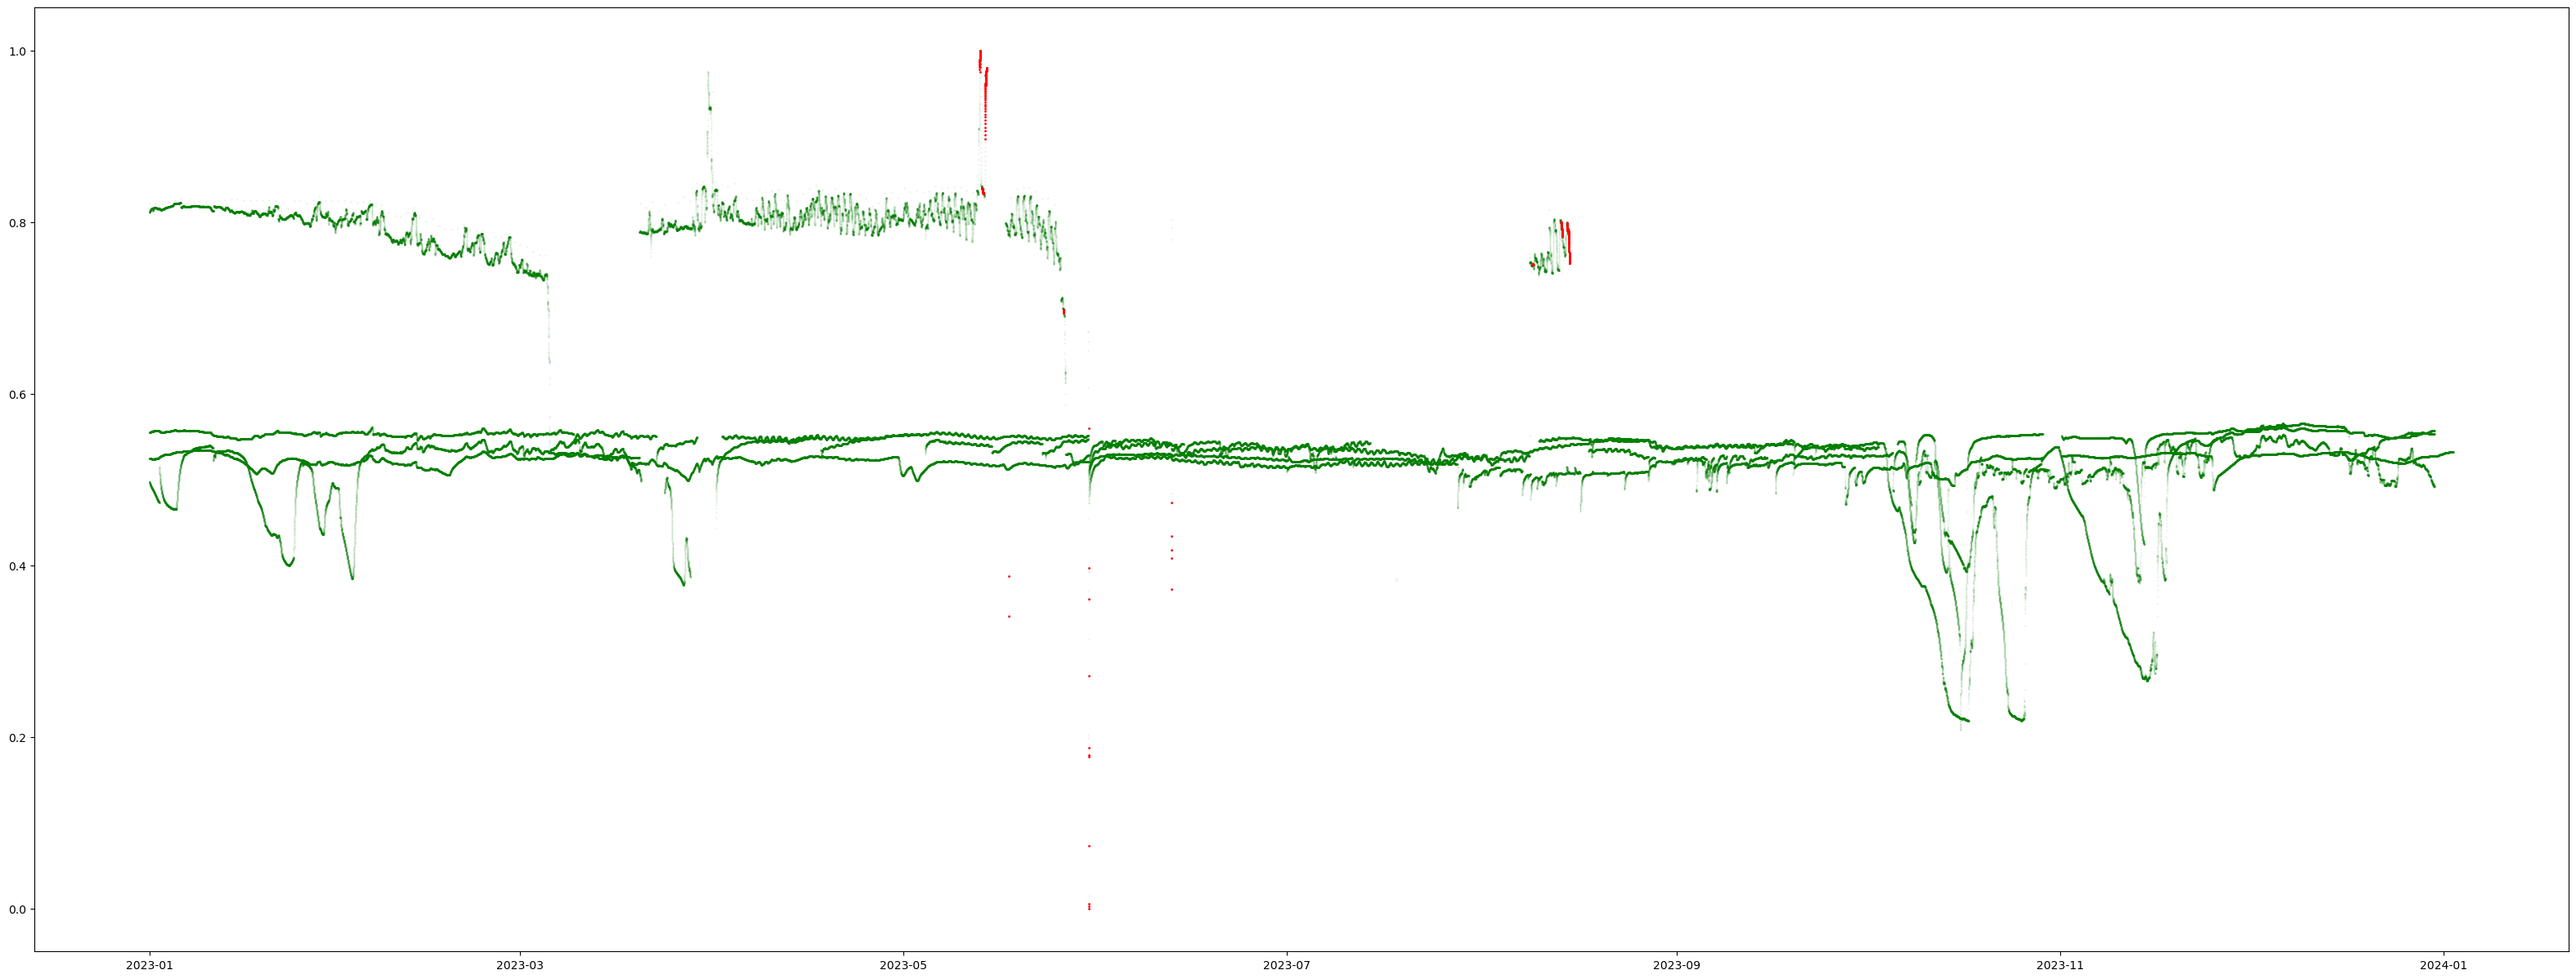

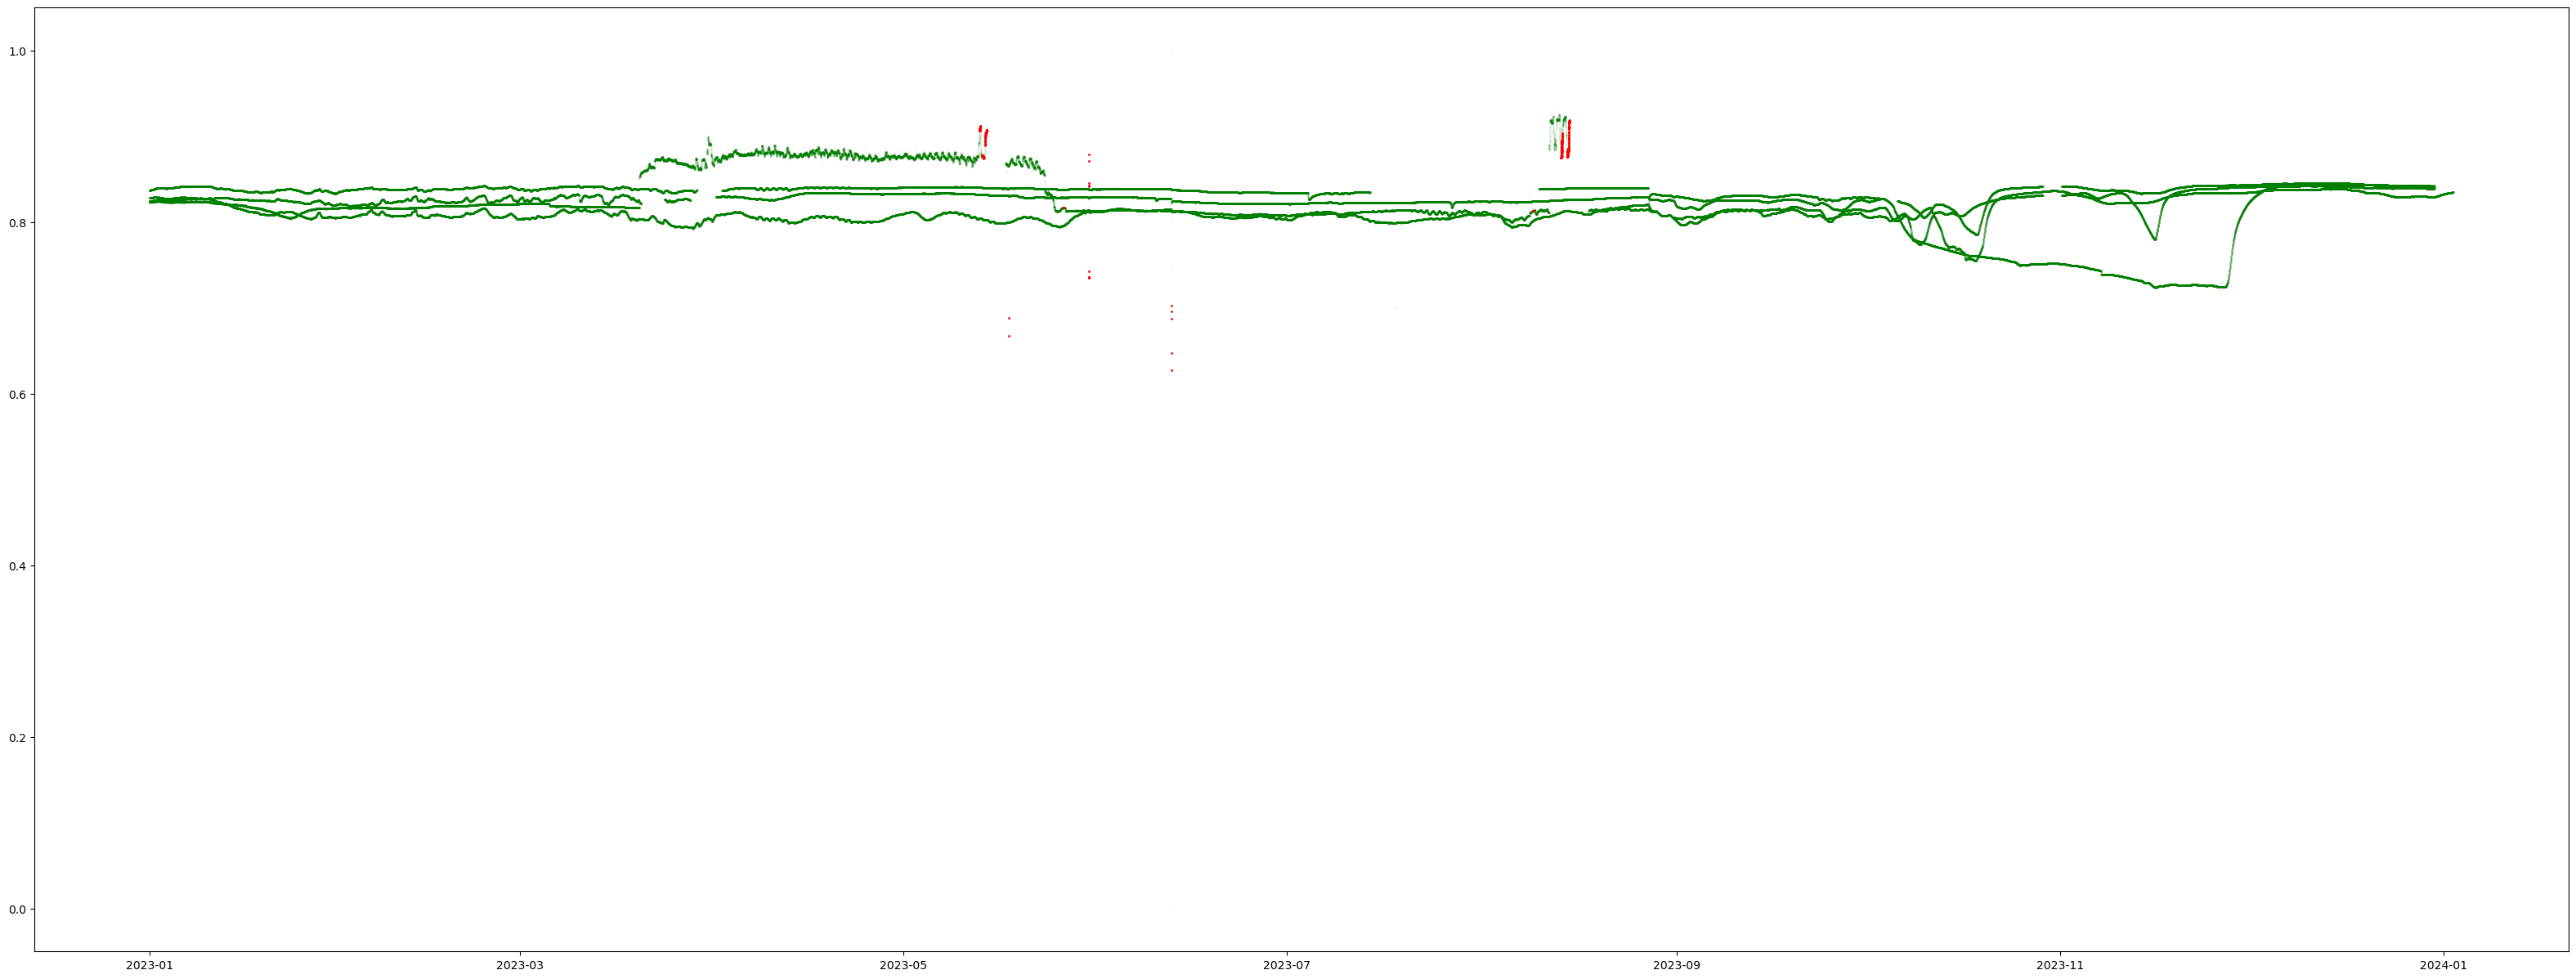

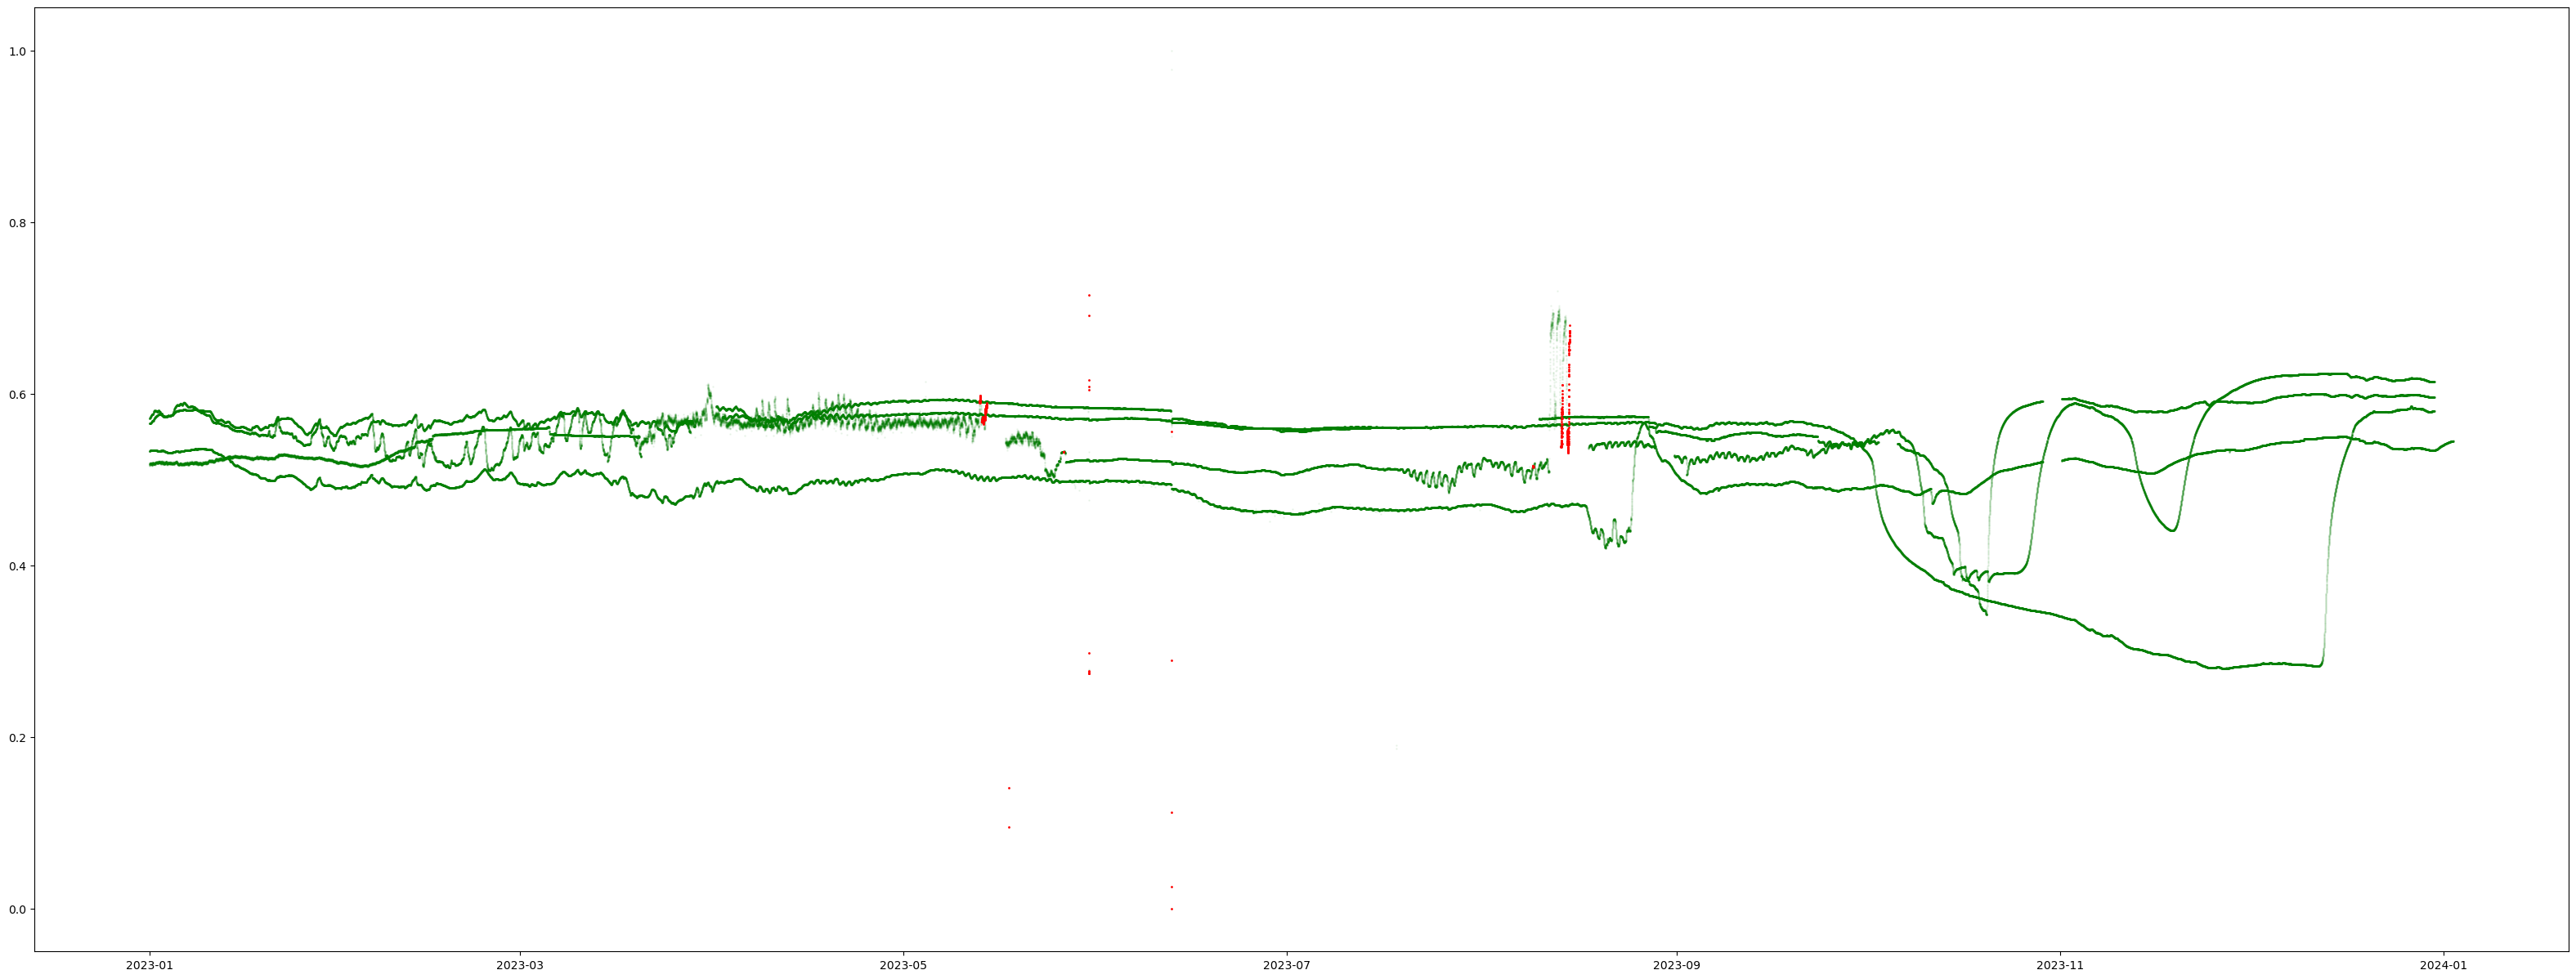

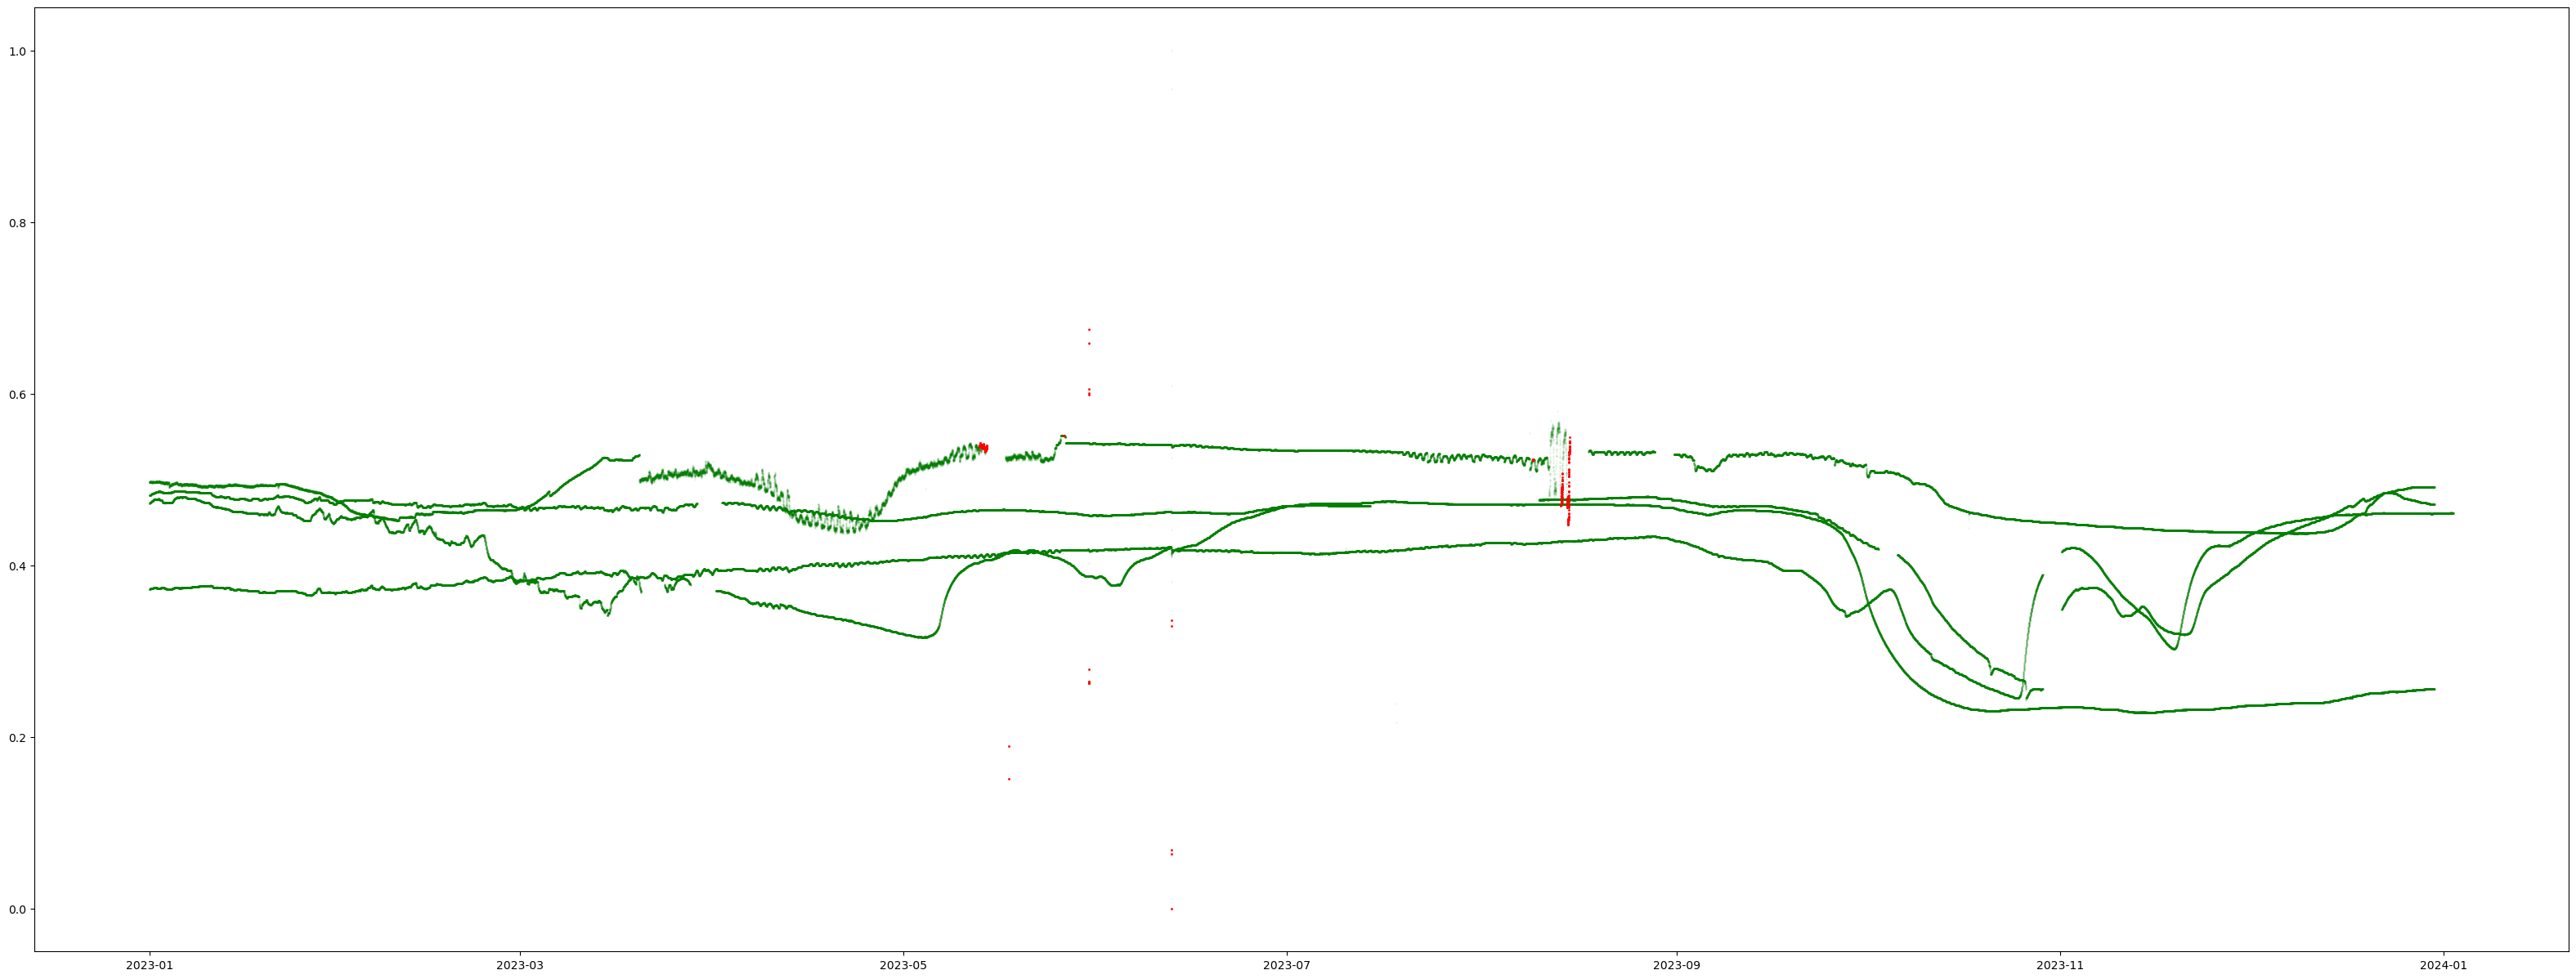

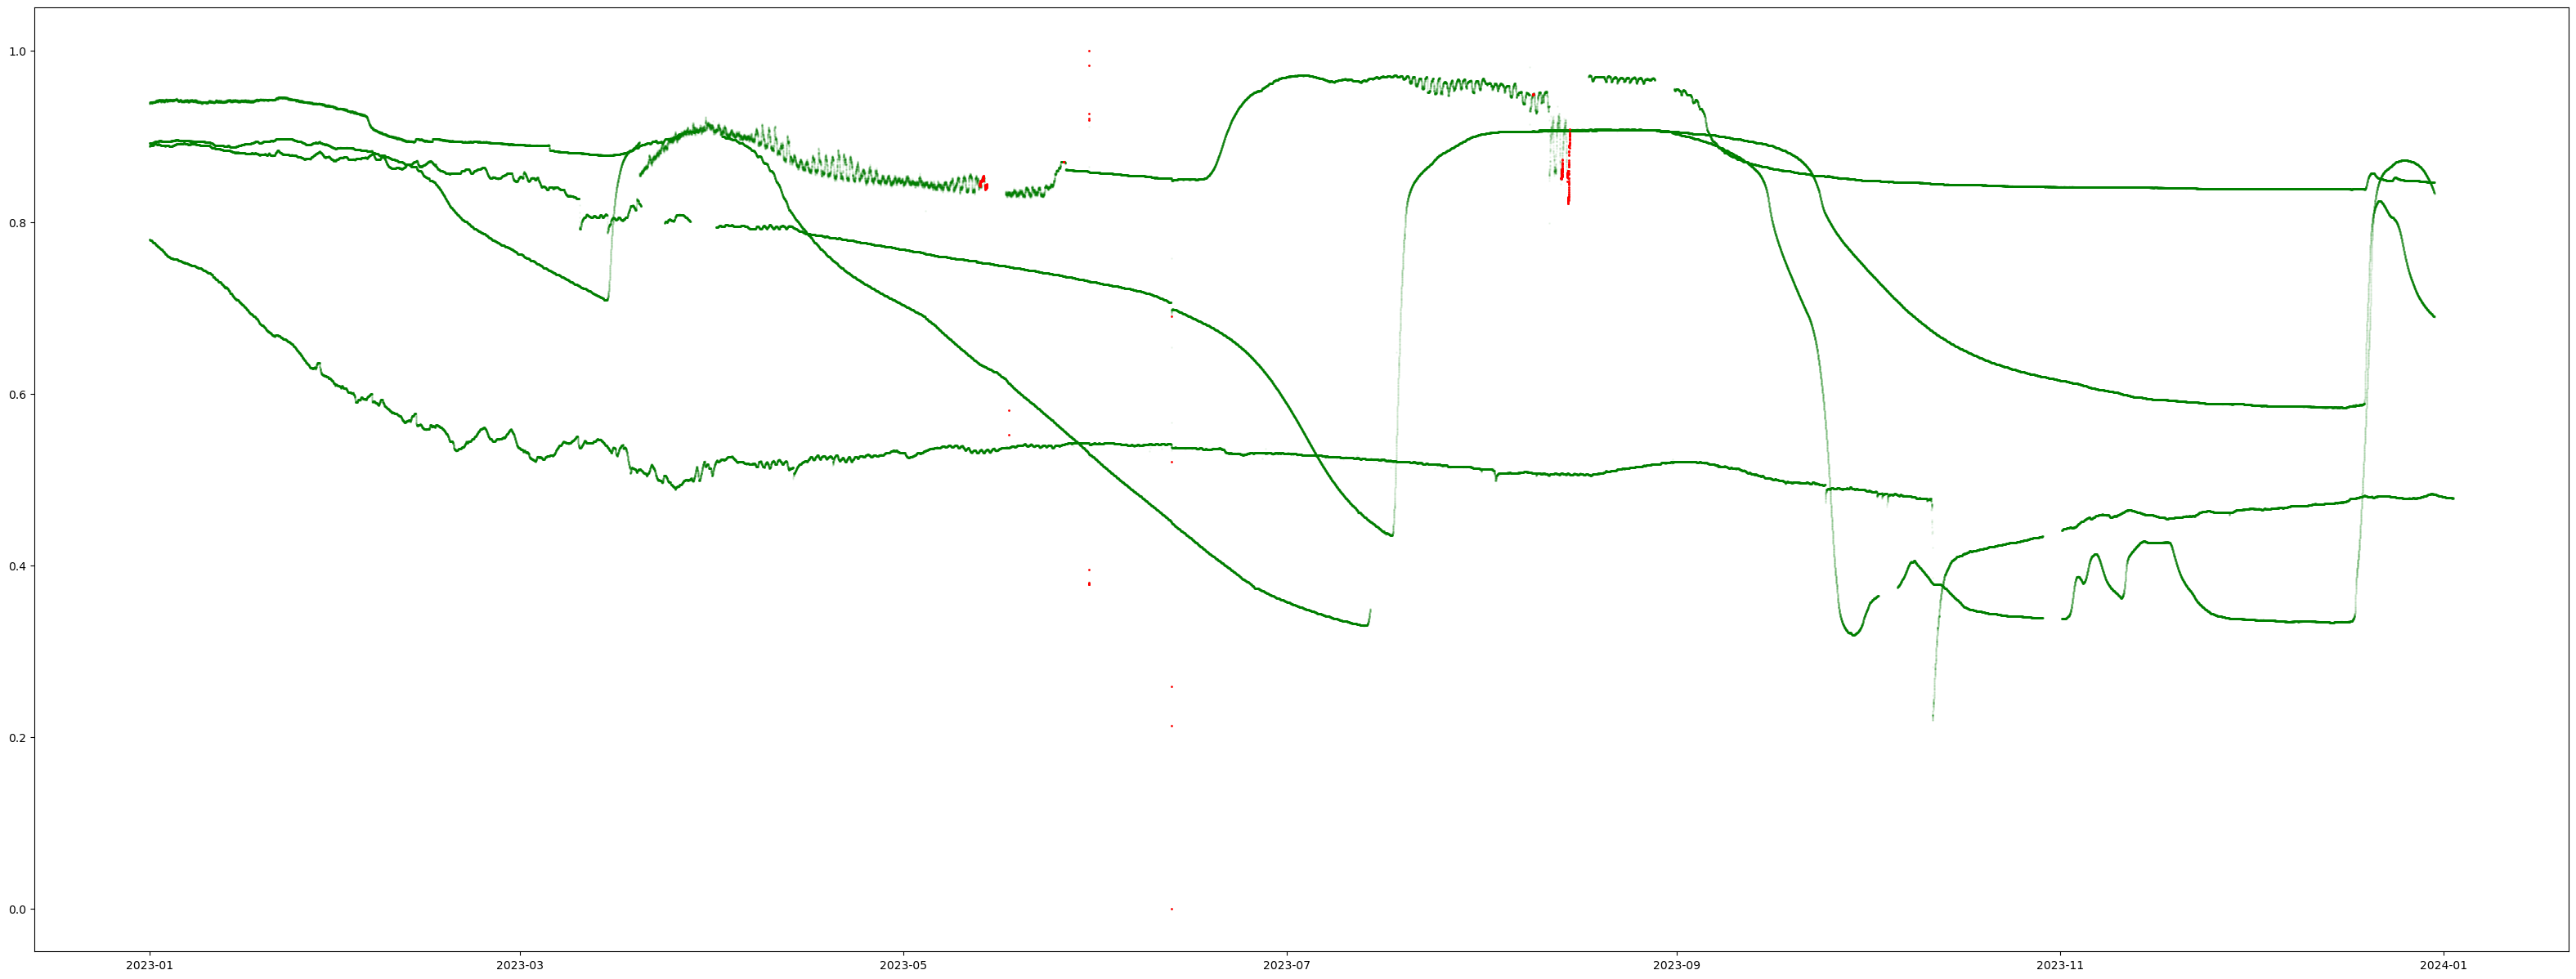

In [98]:
model_opt = models_all_sensors_dict_Adam[Net5, 2.0, 4.0][9]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_all_sensors_2023, sensor = None)

### Sensor specific models trained with Adam, alpha = 0.01 and epochs = 25 

In [116]:
df_Adam = pickle.load(open(results_folder + sensor_specific_folder + "Adam_0.01_results_df_dict", 'rb'))
df_Adam

{1:    architecture  weight_normal  weight_anomaly  number_of_units  ...  train_recall  test_log_likelihood  test_accuracy  test_recall
 0             3            2.0             2.0                3  ...      0.985565             0.000062       0.984415     0.482694
 1             3            2.0             2.0                5  ...      0.951885             0.000153       0.980377     0.233863
 2             3            2.0             2.0                7  ...      0.000000             0.000120       0.974757     0.000000
 3             3            2.0             2.0                9  ...      0.998797             0.000036       0.993601     0.756782
 4             3            2.0             2.0               11  ...      0.998797             0.000029       0.989492     0.591207
 5             3            2.0             2.0               13  ...      0.998797             0.000028       0.991735     0.680075
 6             3            2.0             2.0               15  

In [115]:
df_Adam2 = pickle.load(open(results_folder + sensor_specific_folder + "_Adam_0.01_results_df_dict", 'rb'))
df_Adam2

{1:    architecture  weight_normal  weight_anomaly  number_of_units  ...  train_recall  test_log_likelihood  test_accuracy  test_recall
 0             3            2.0             2.0                3  ...      0.985565             0.000062       0.984415     0.482694
 1             3            2.0             2.0                5  ...      0.951885             0.000153       0.980377     0.233863
 2             3            2.0             2.0                7  ...      0.000000             0.000120       0.974757     0.000000
 3             3            2.0             2.0                9  ...      0.998797             0.000036       0.993601     0.756782
 4             3            2.0             2.0               11  ...      0.998797             0.000029       0.989492     0.591207
 5             3            2.0             2.0               13  ...      0.998797             0.000028       0.991735     0.680075
 6             3            2.0             2.0               15  

In [102]:
models_Adam = pickle.load(open(results_folder + sensor_specific_folder + "all_models_Adam_0.01", 'rb'))

## Sensor 1

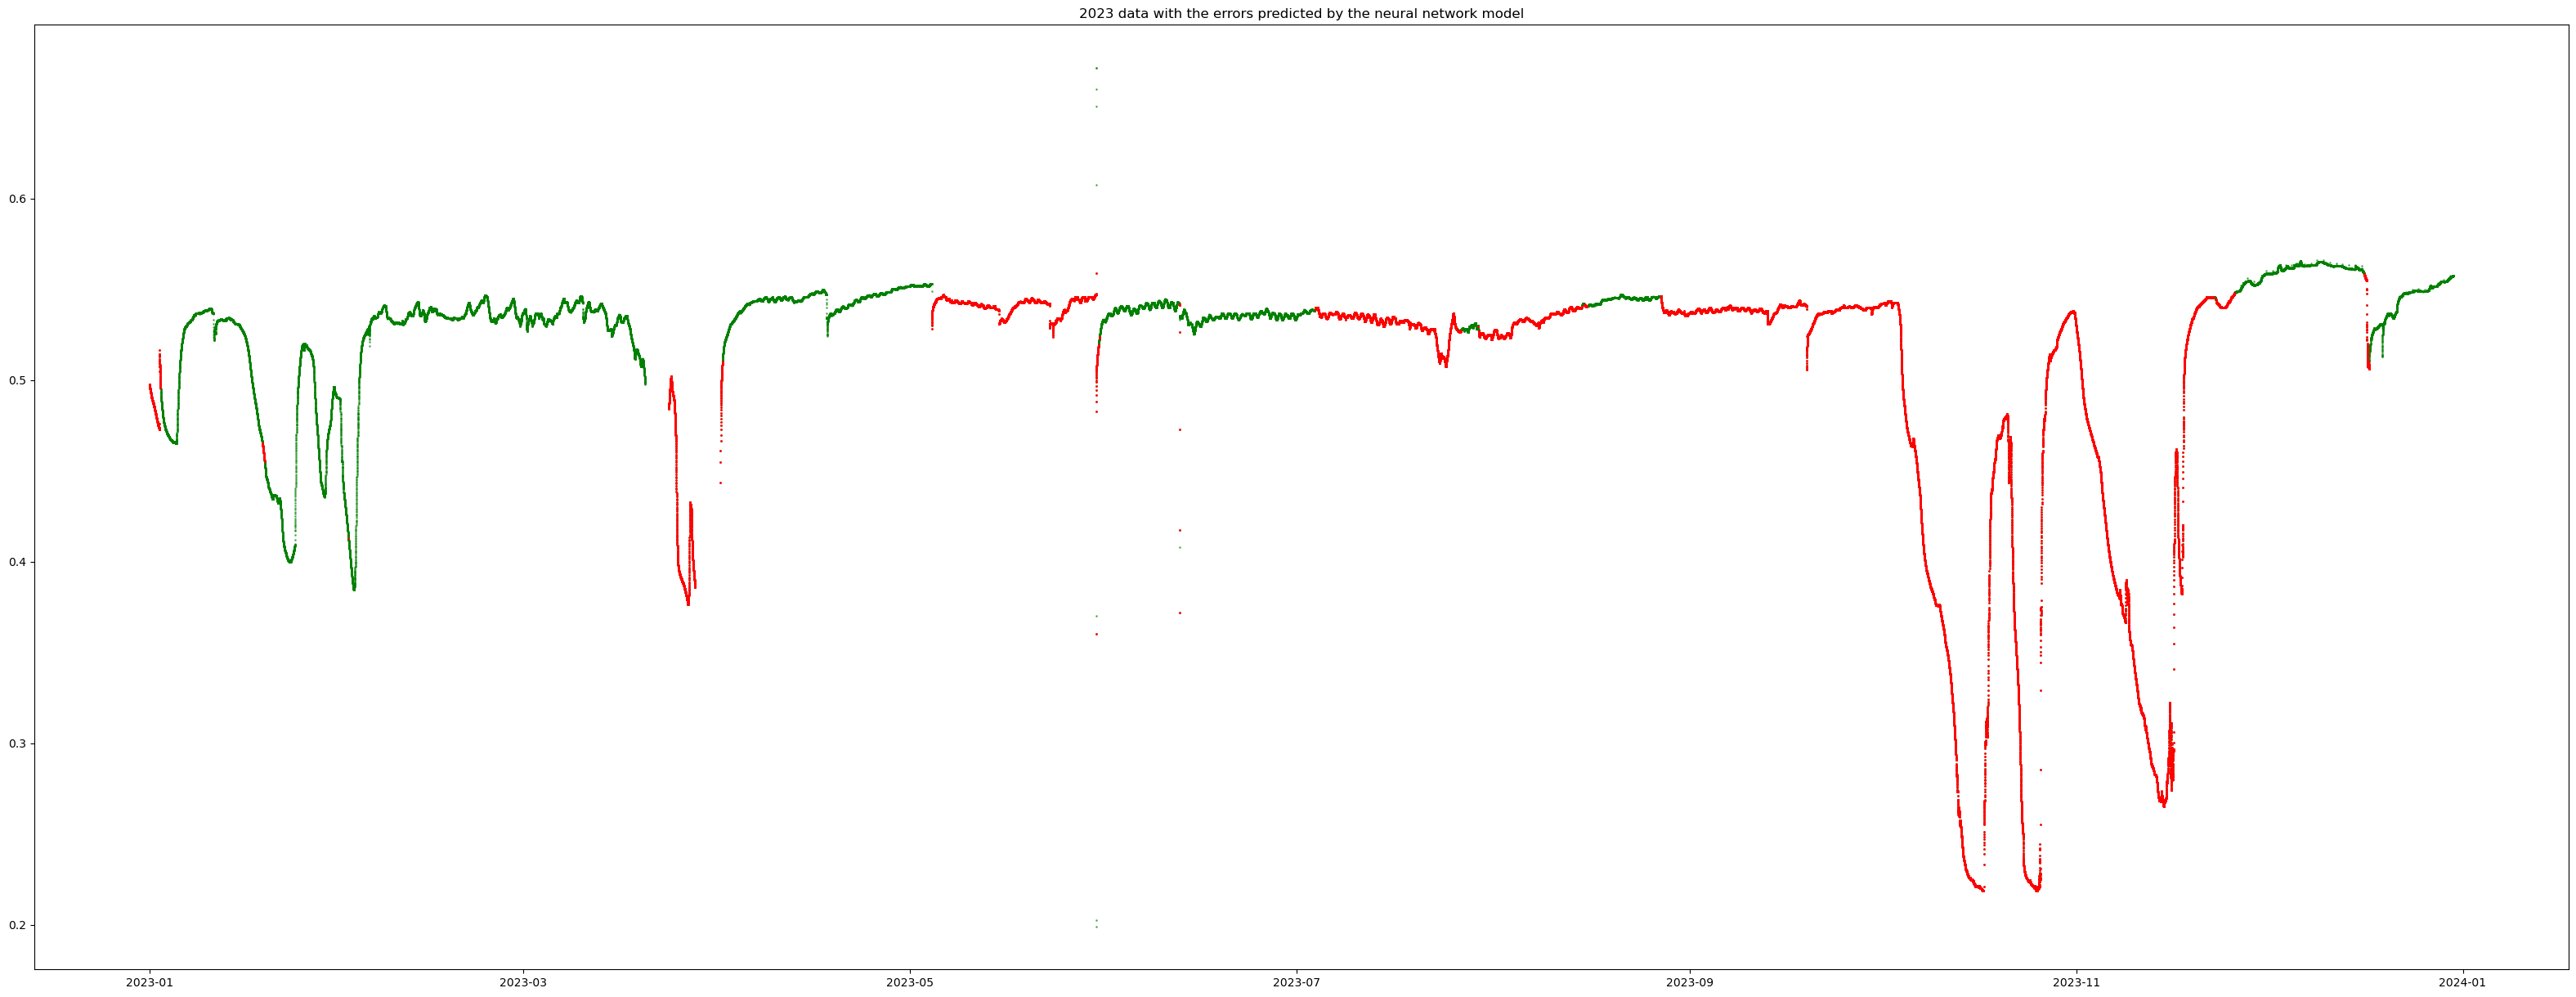

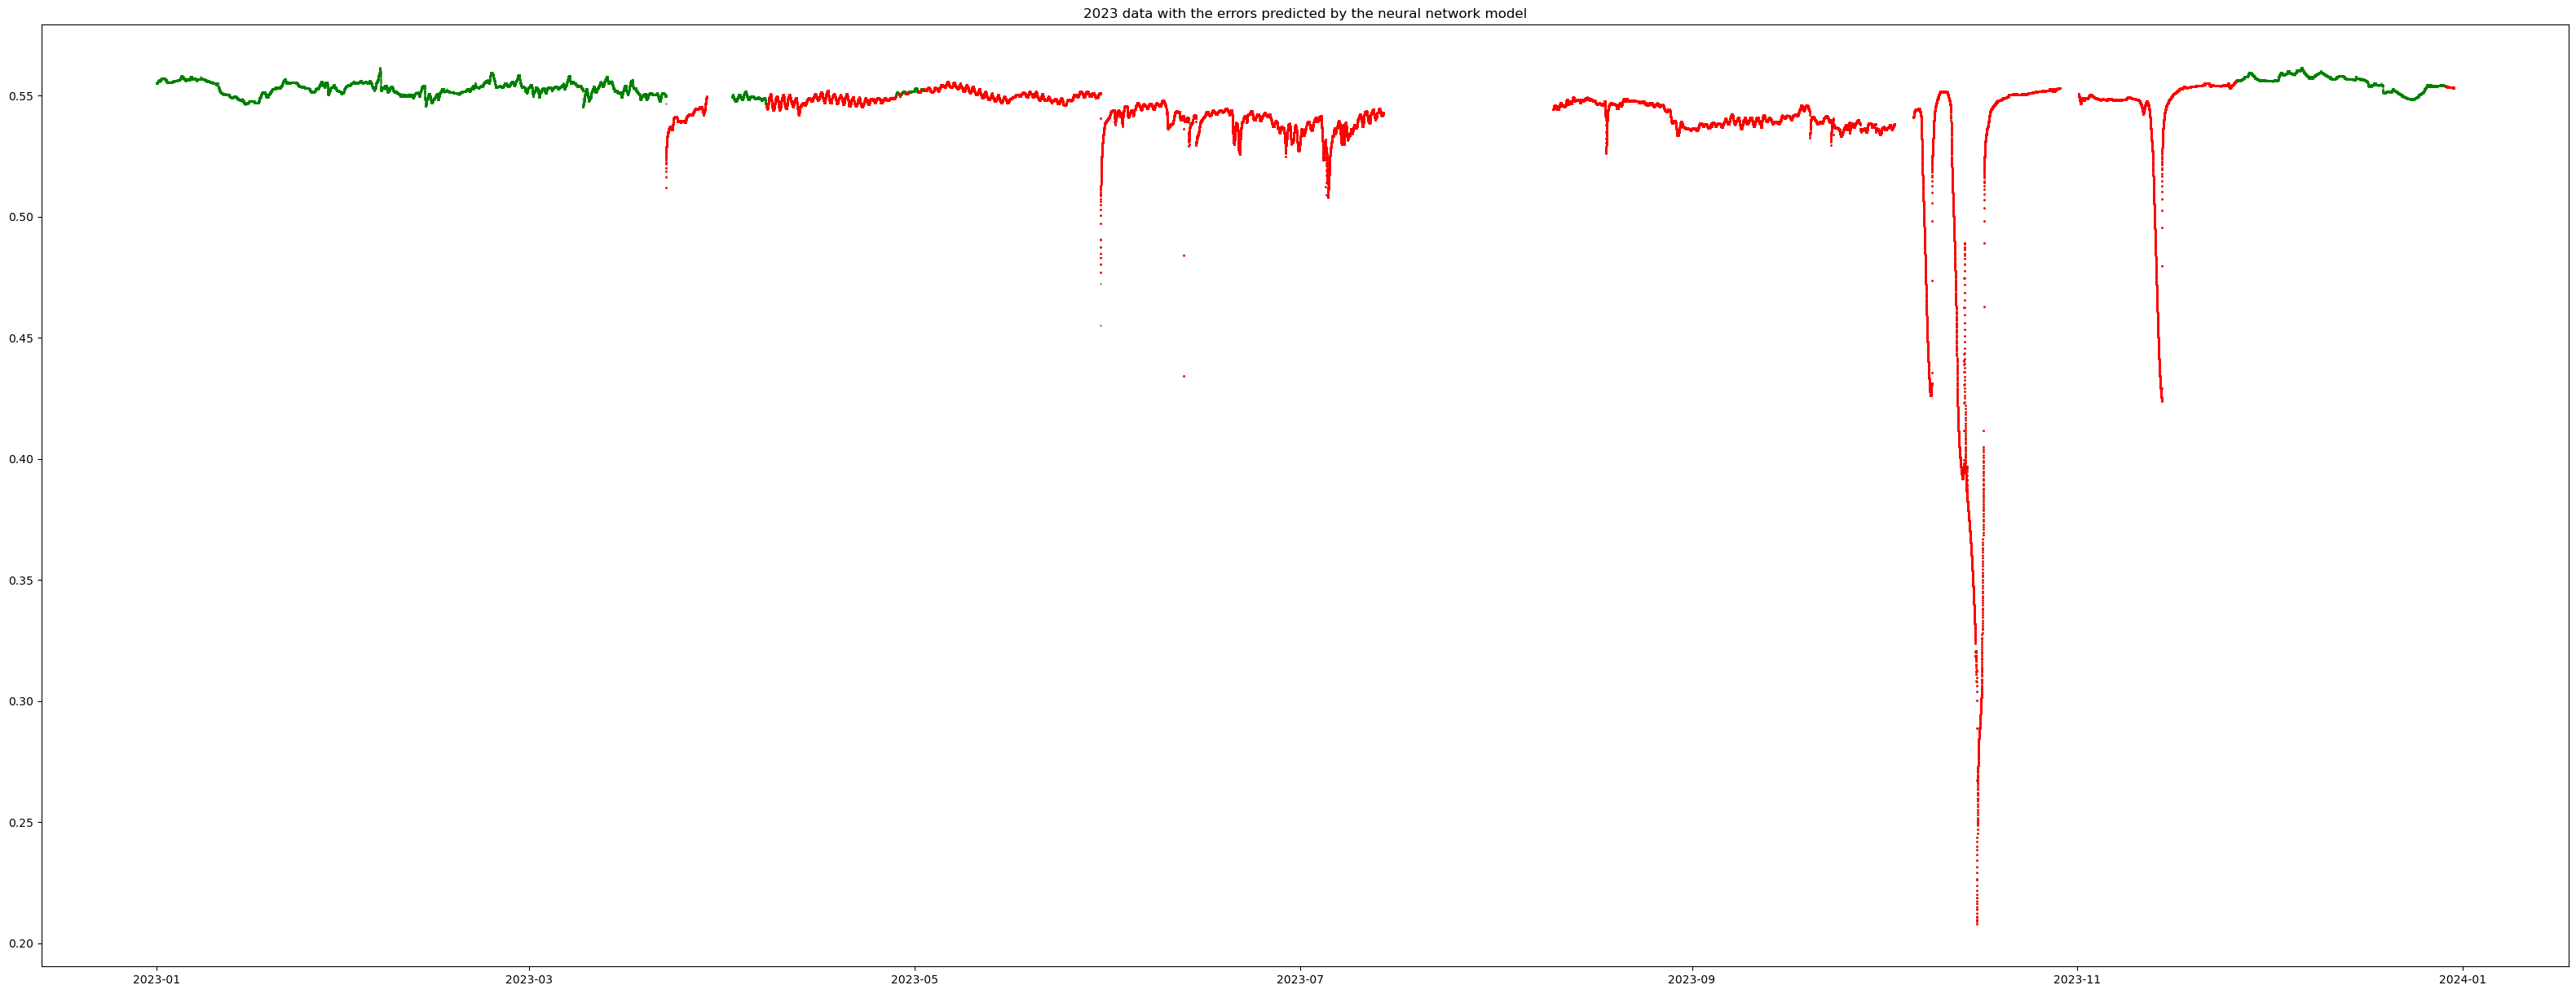

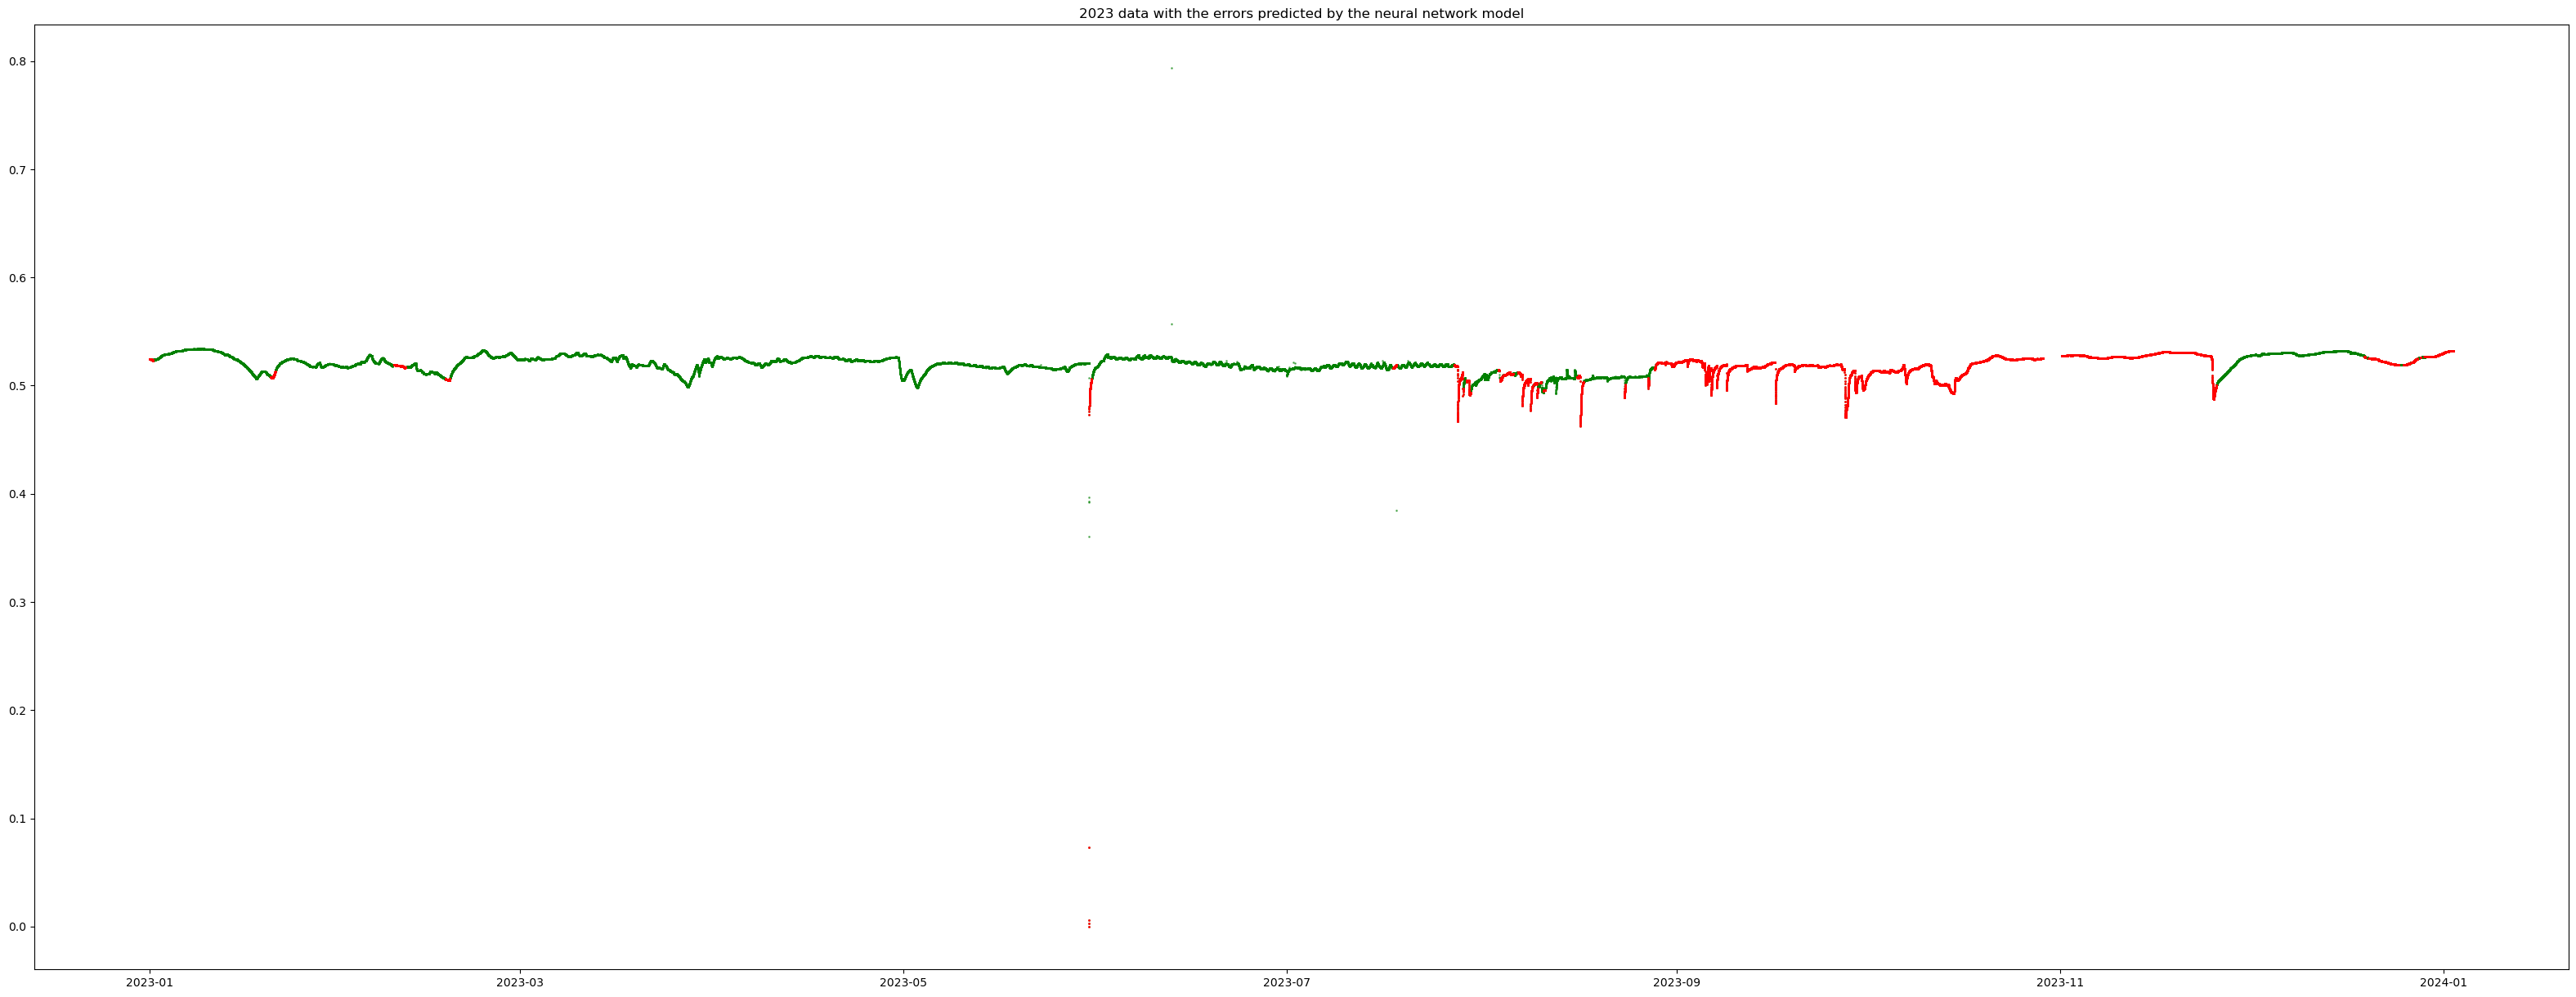

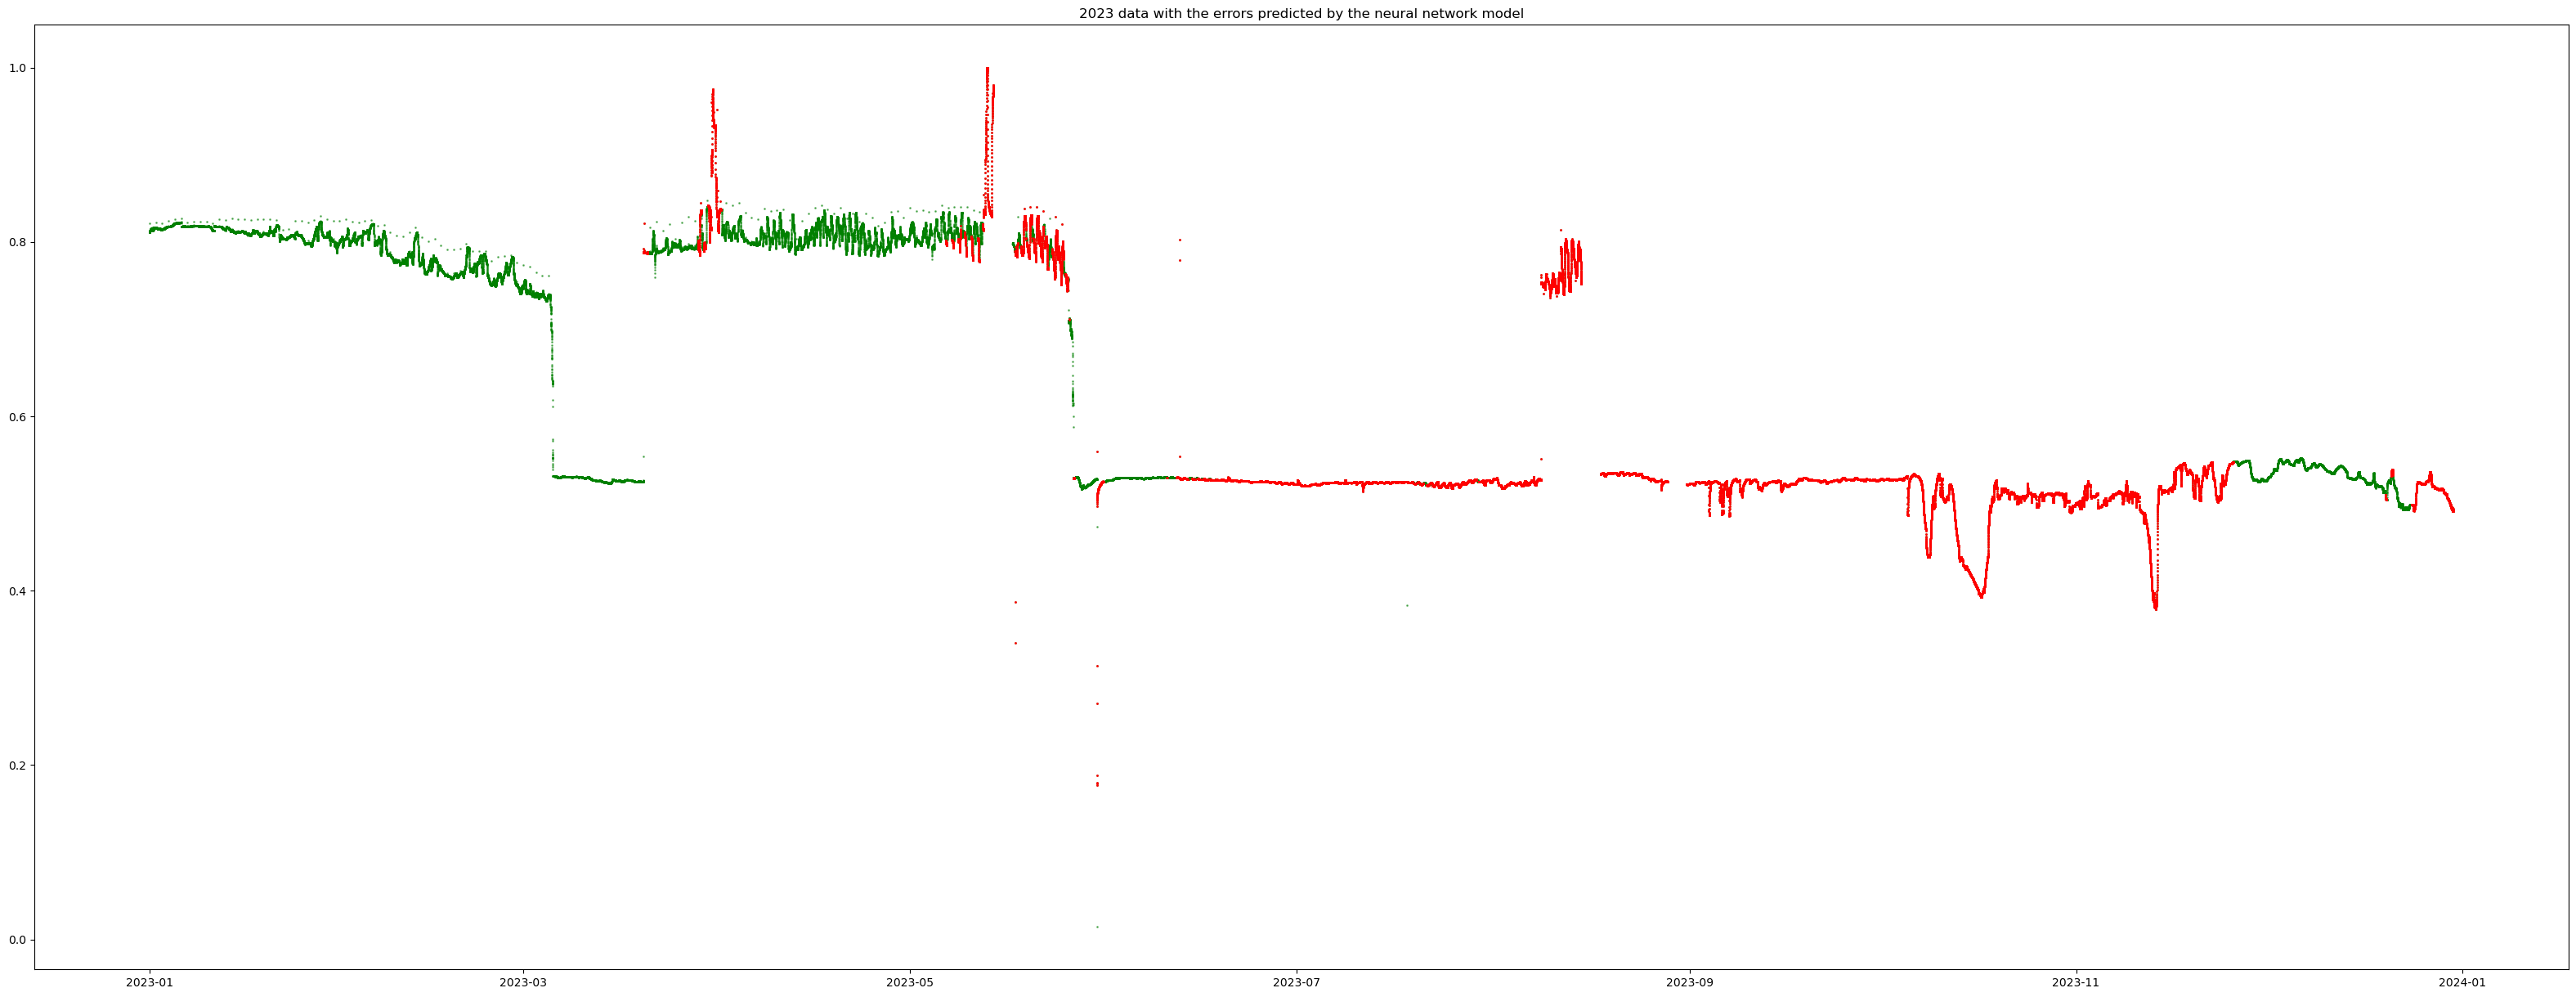

In [103]:
test_scaled_2023 = sensor_data[f'sensor_{1}']["test_scaled_2023"]
model_opt = models_Adam[1, Net3, 2.0, 4.0][13]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 1)

## Sensor 2

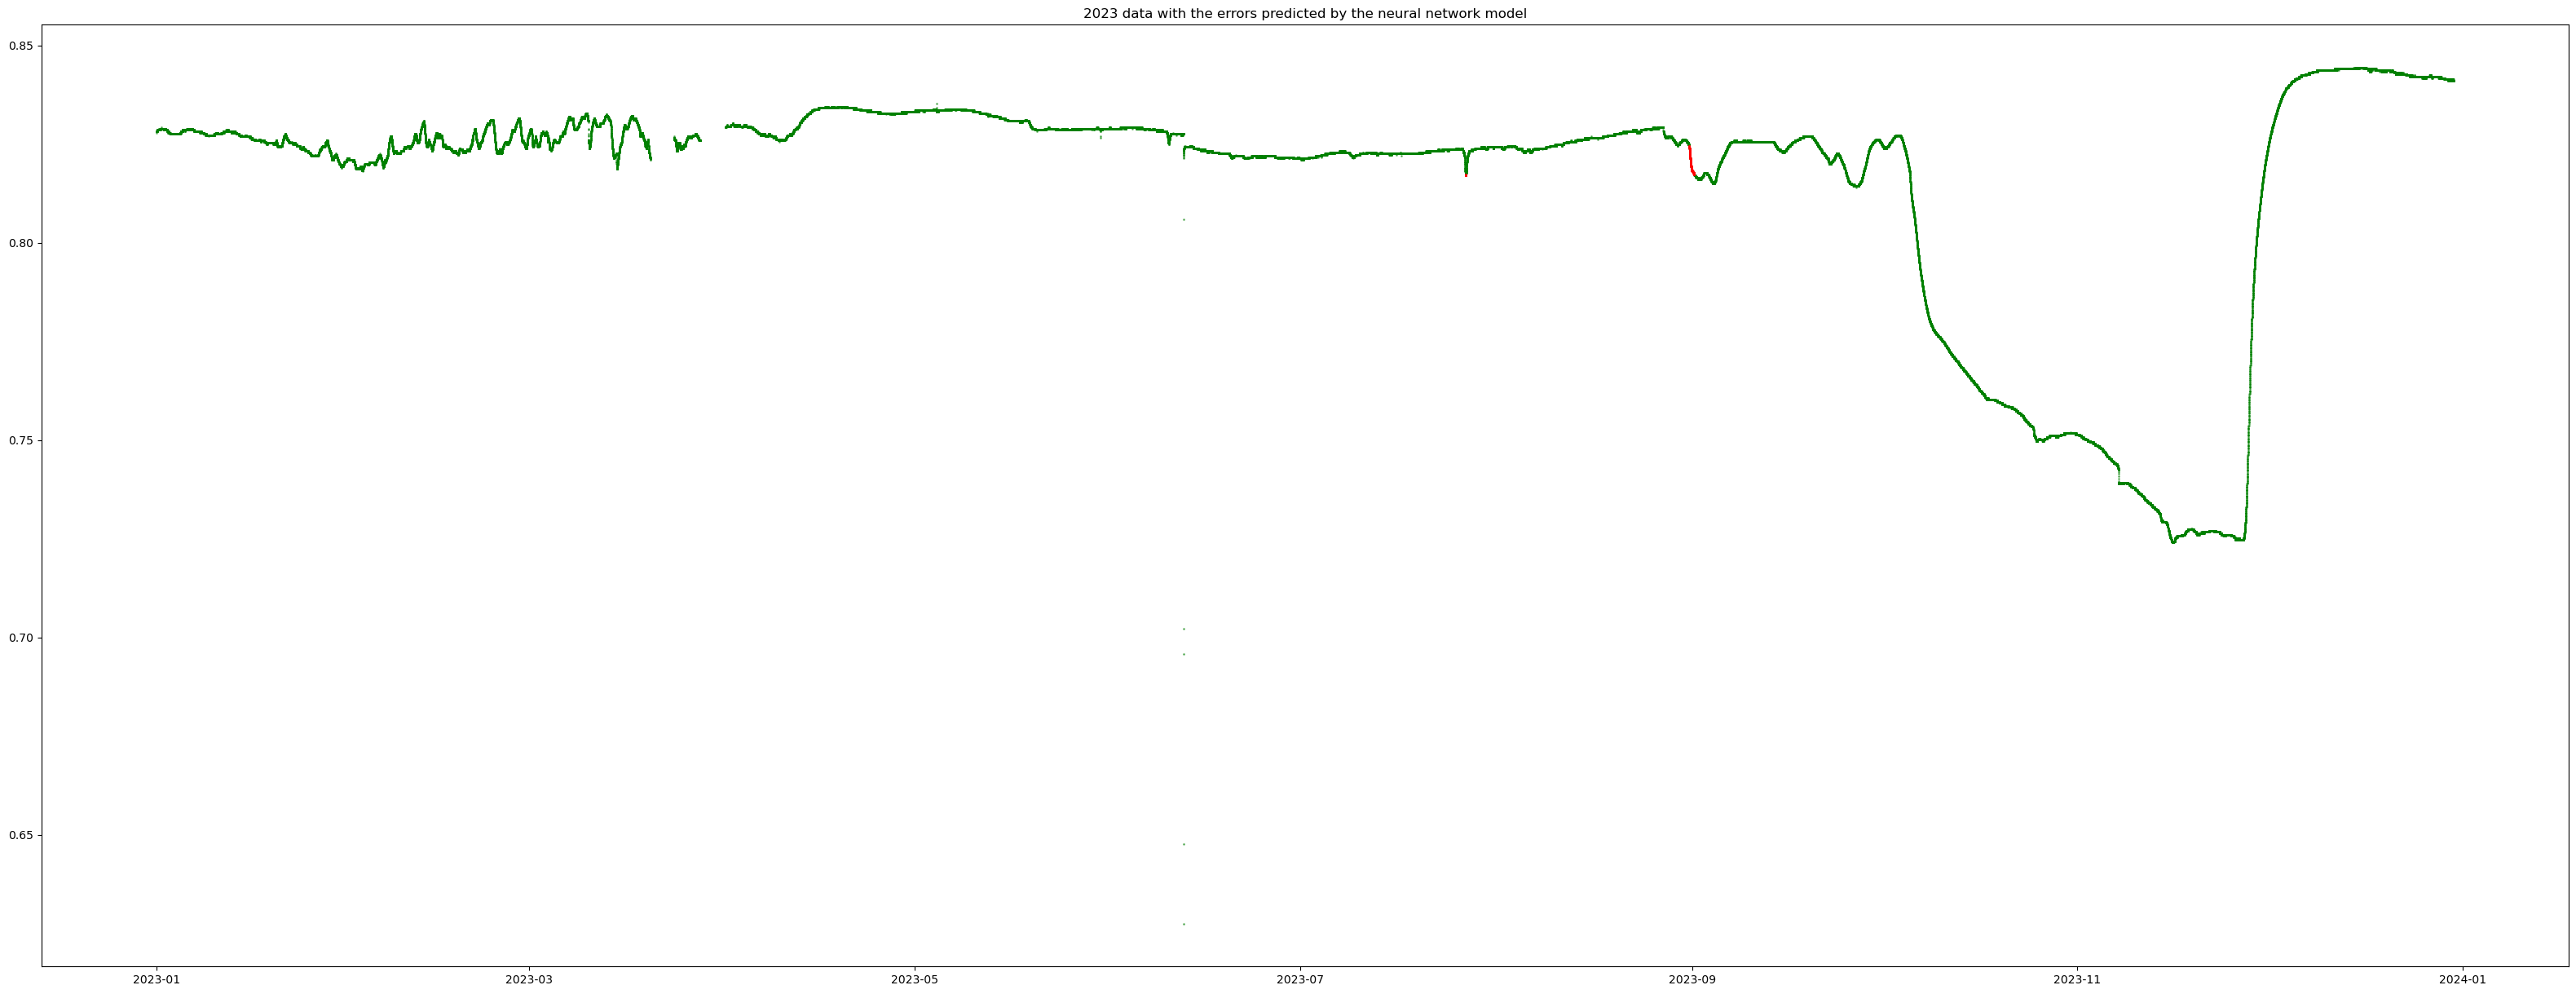

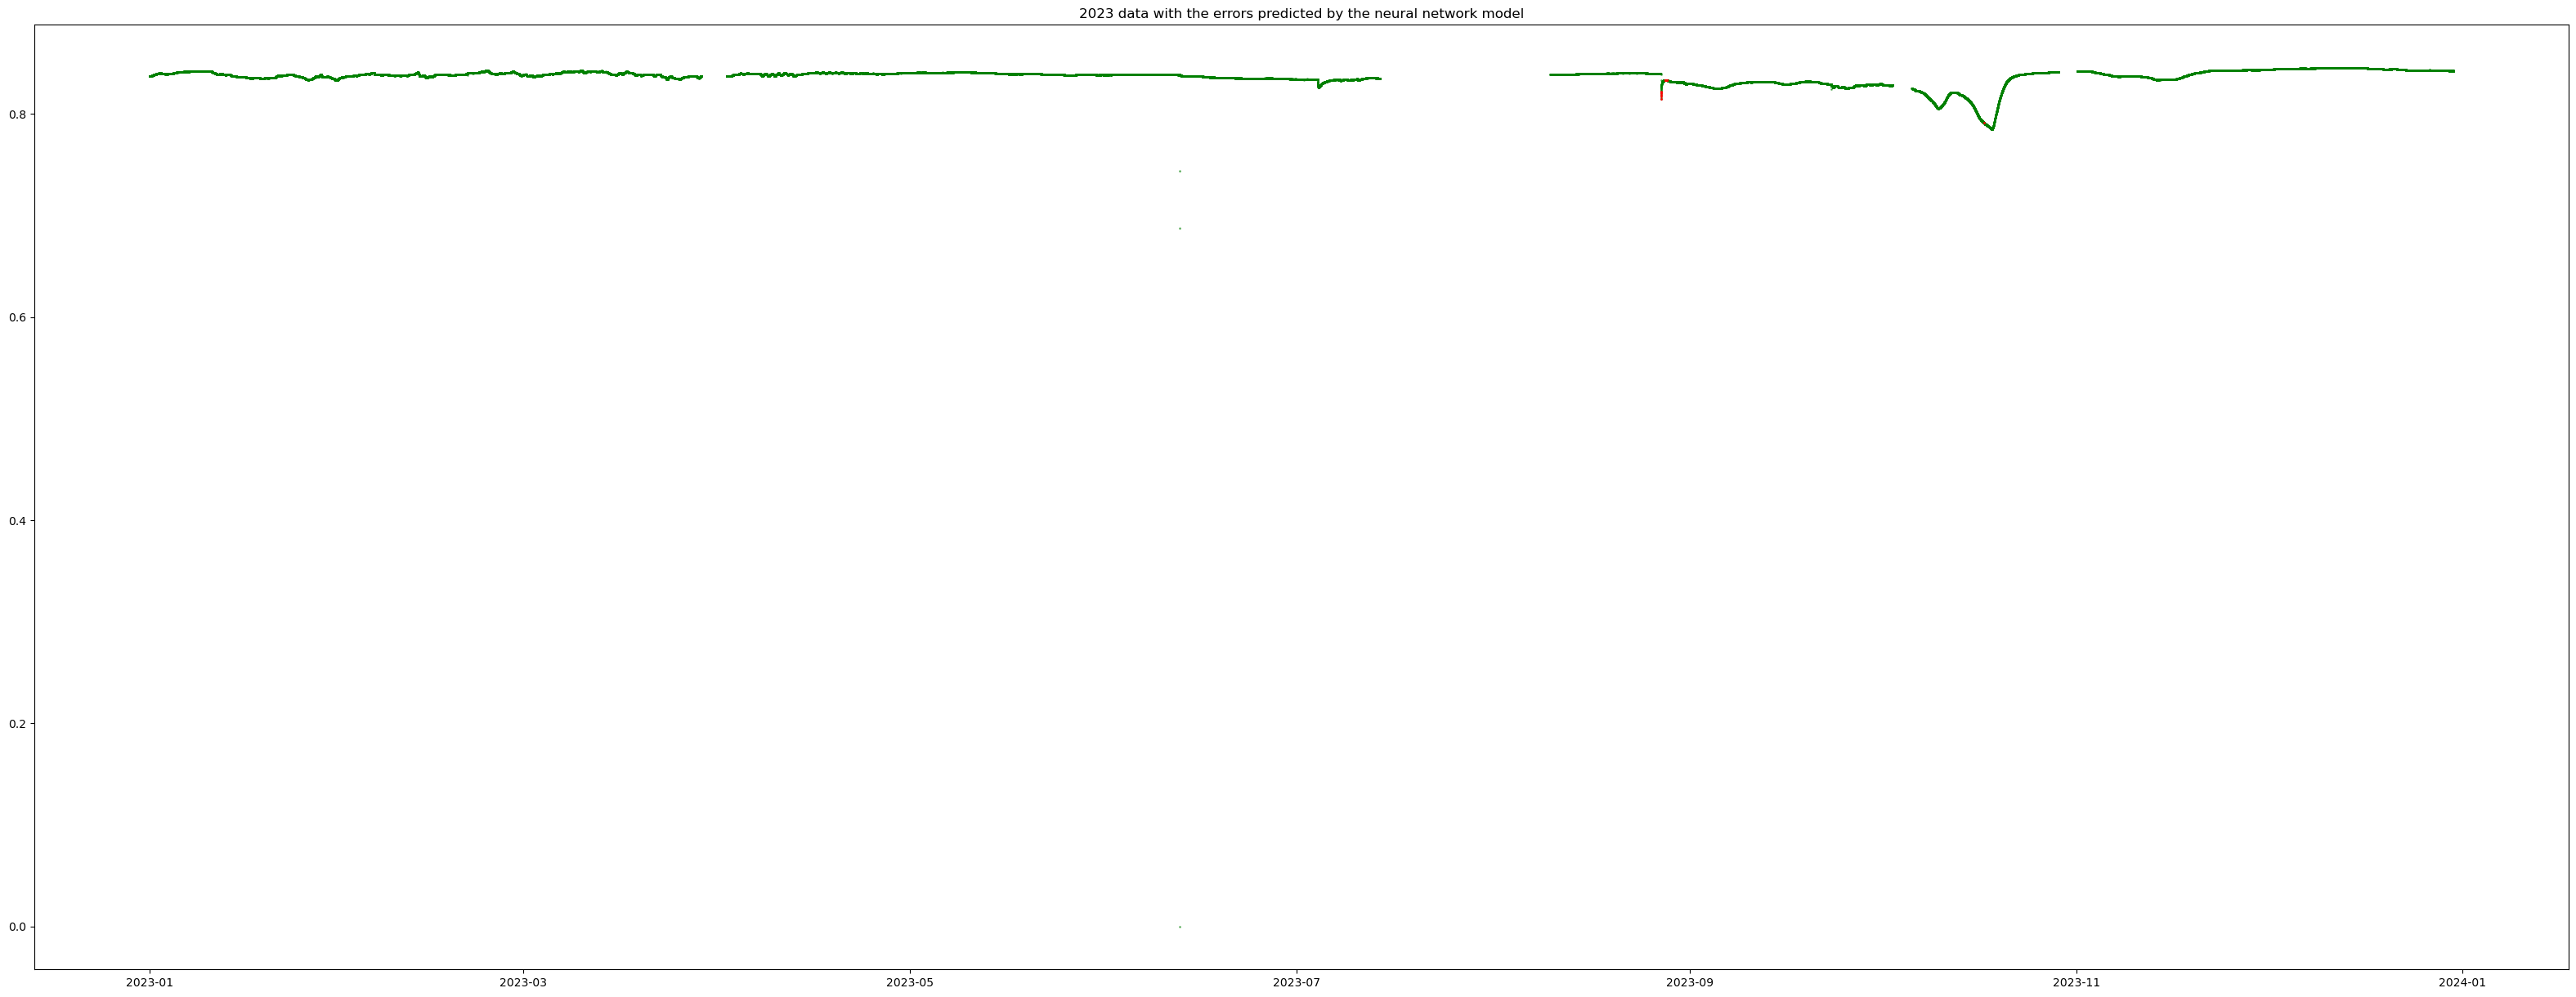

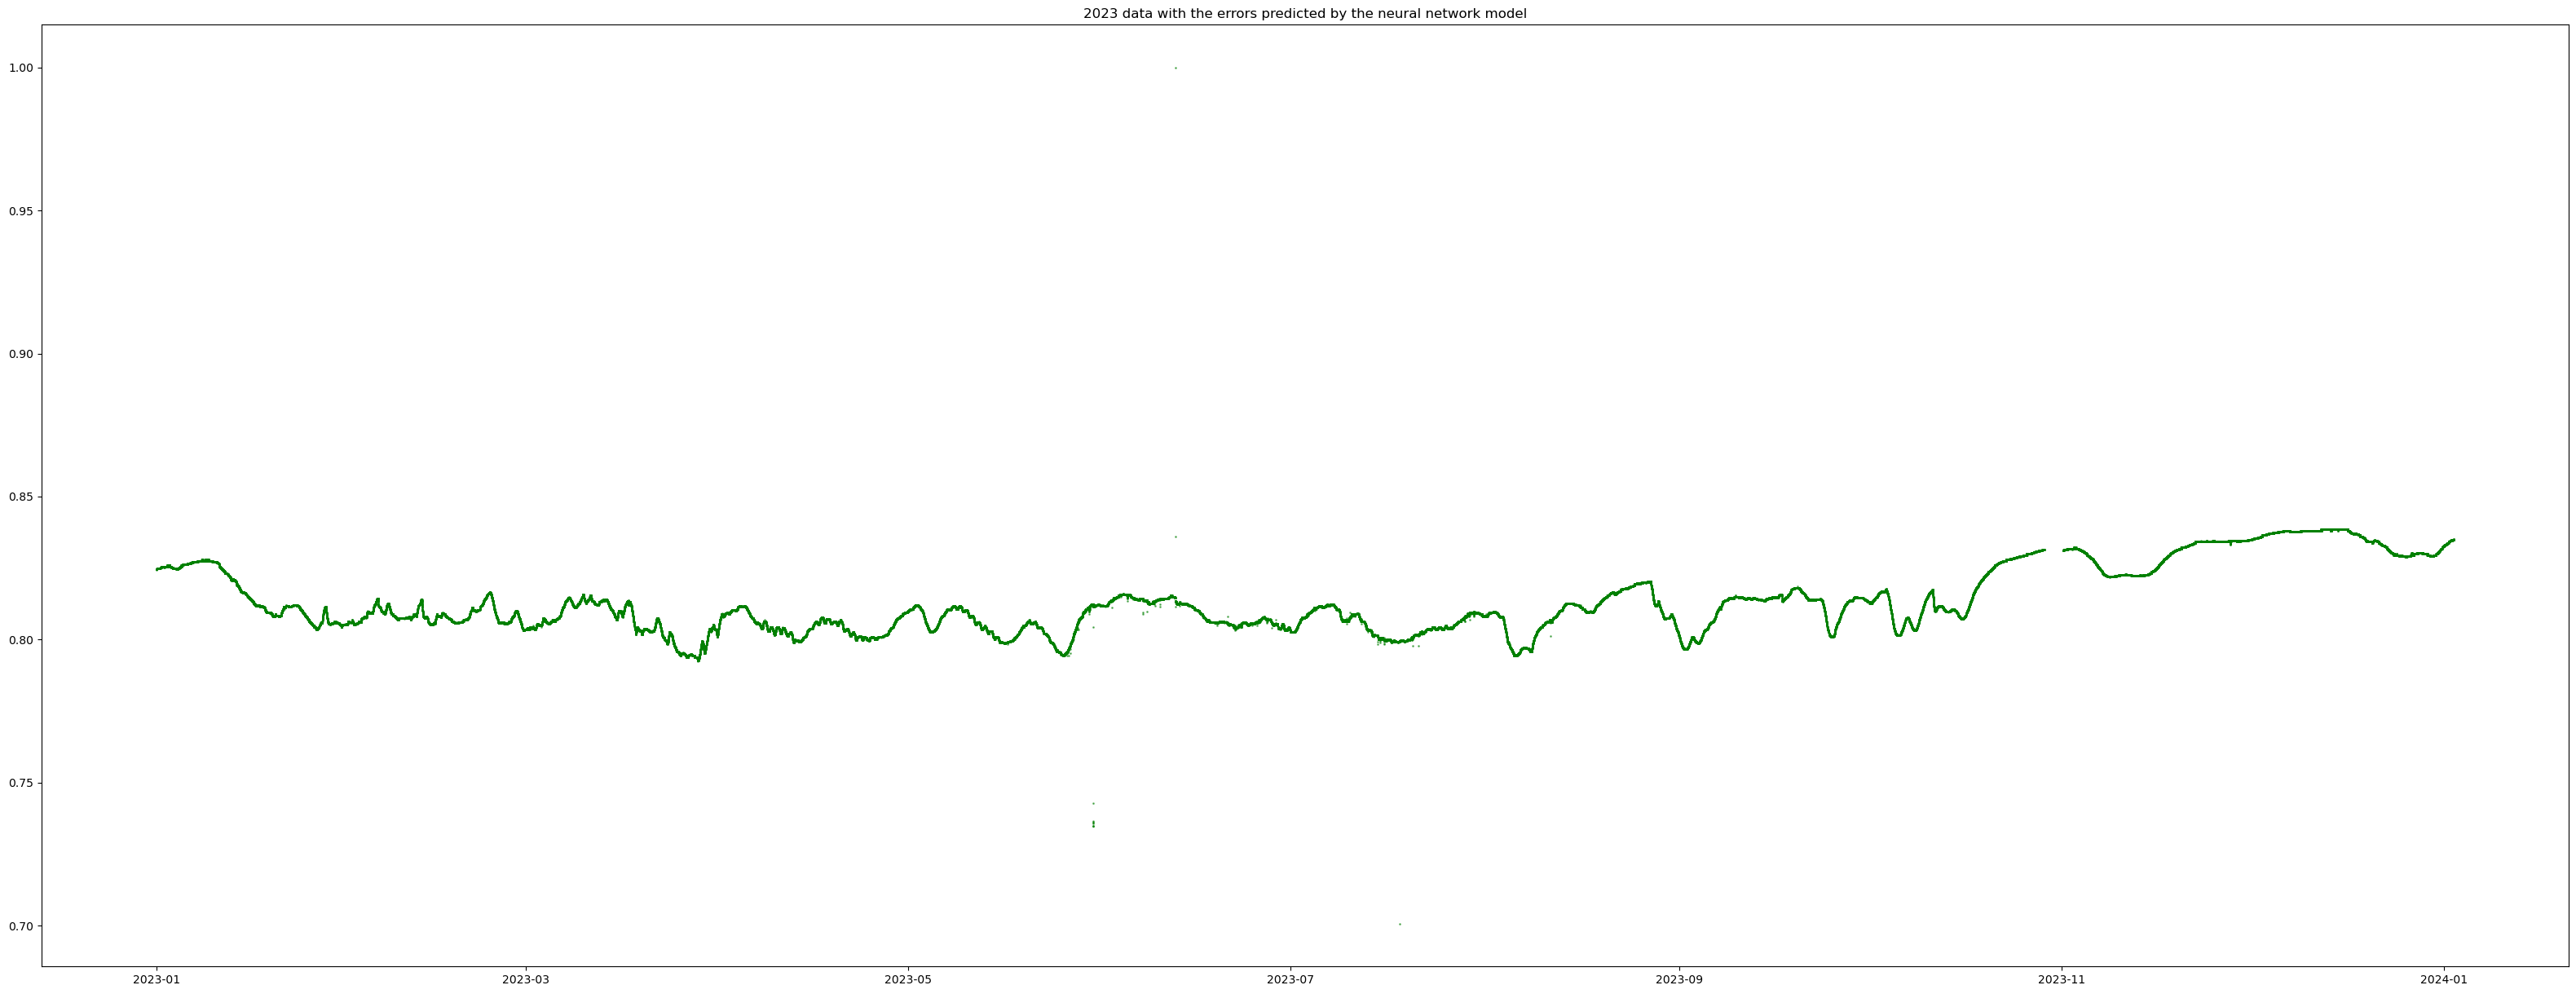

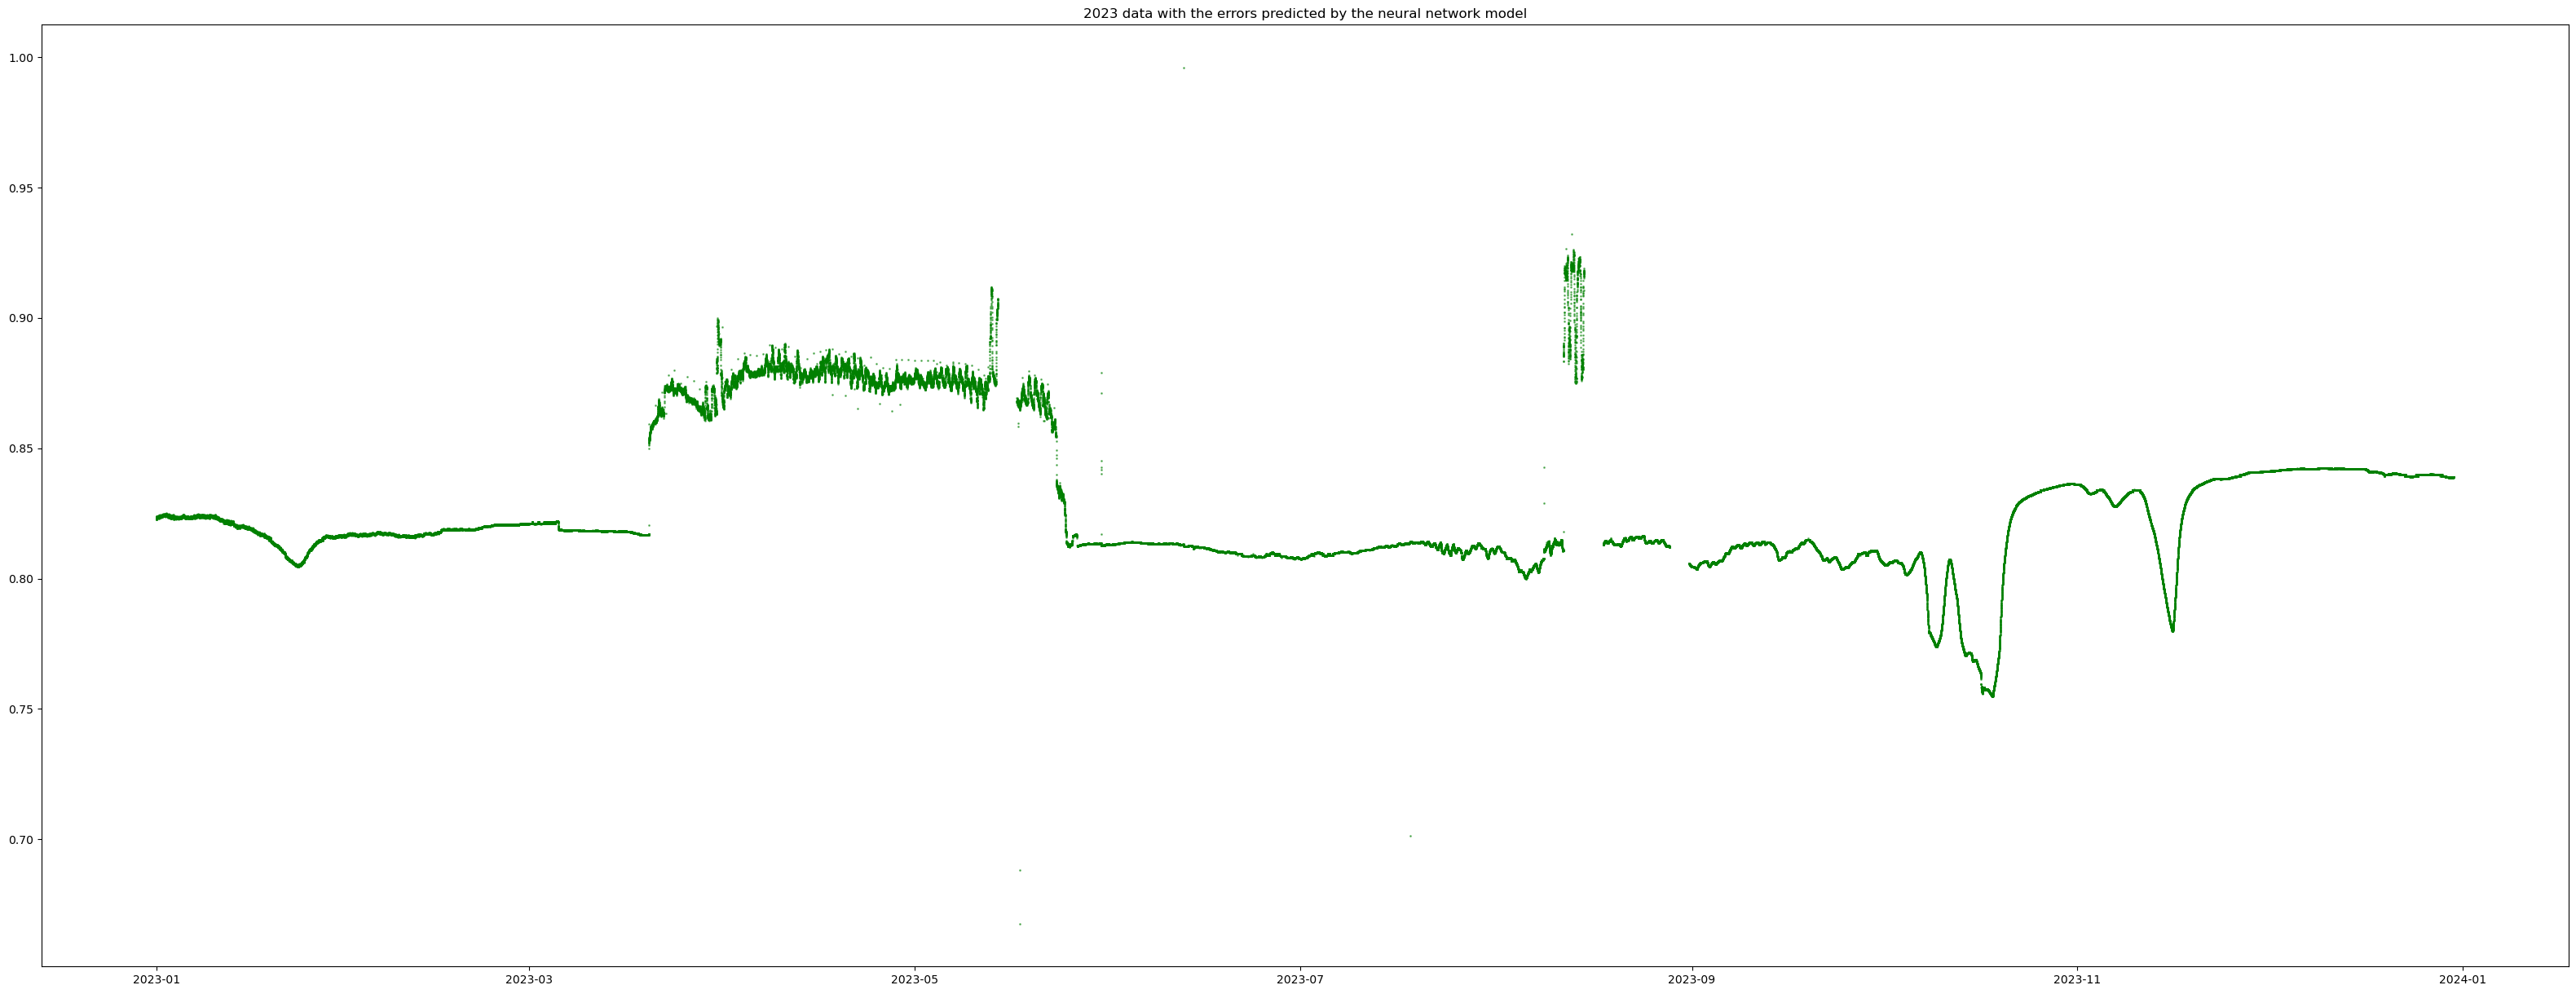

In [104]:
test_scaled_2023 = sensor_data[f'sensor_{2}']["test_scaled_2023"]
model_opt = models_Adam[2, Net3, 2.0, 4.0][11]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 2)

## Sensor 3

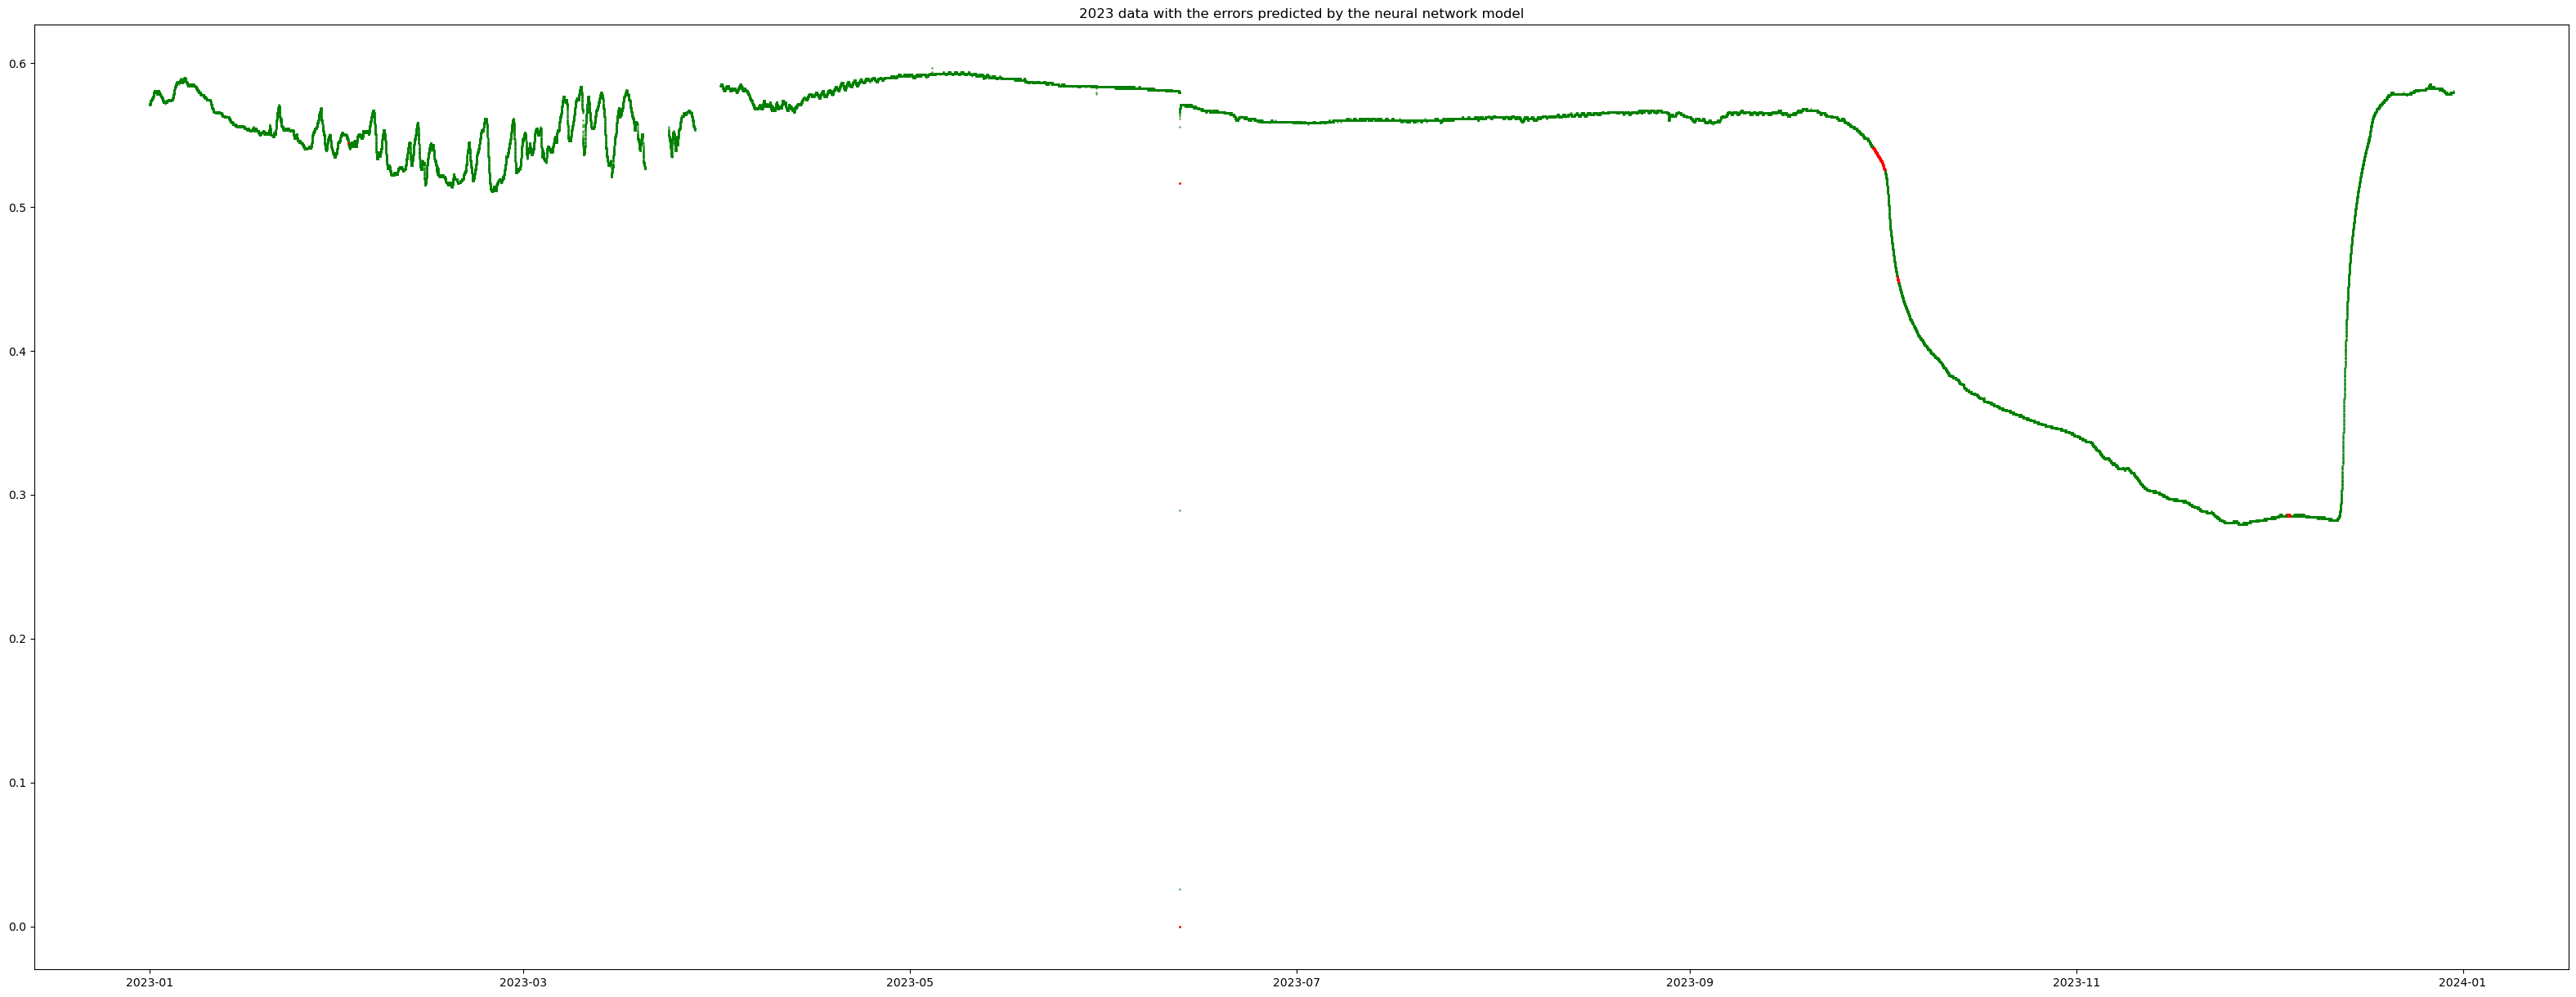

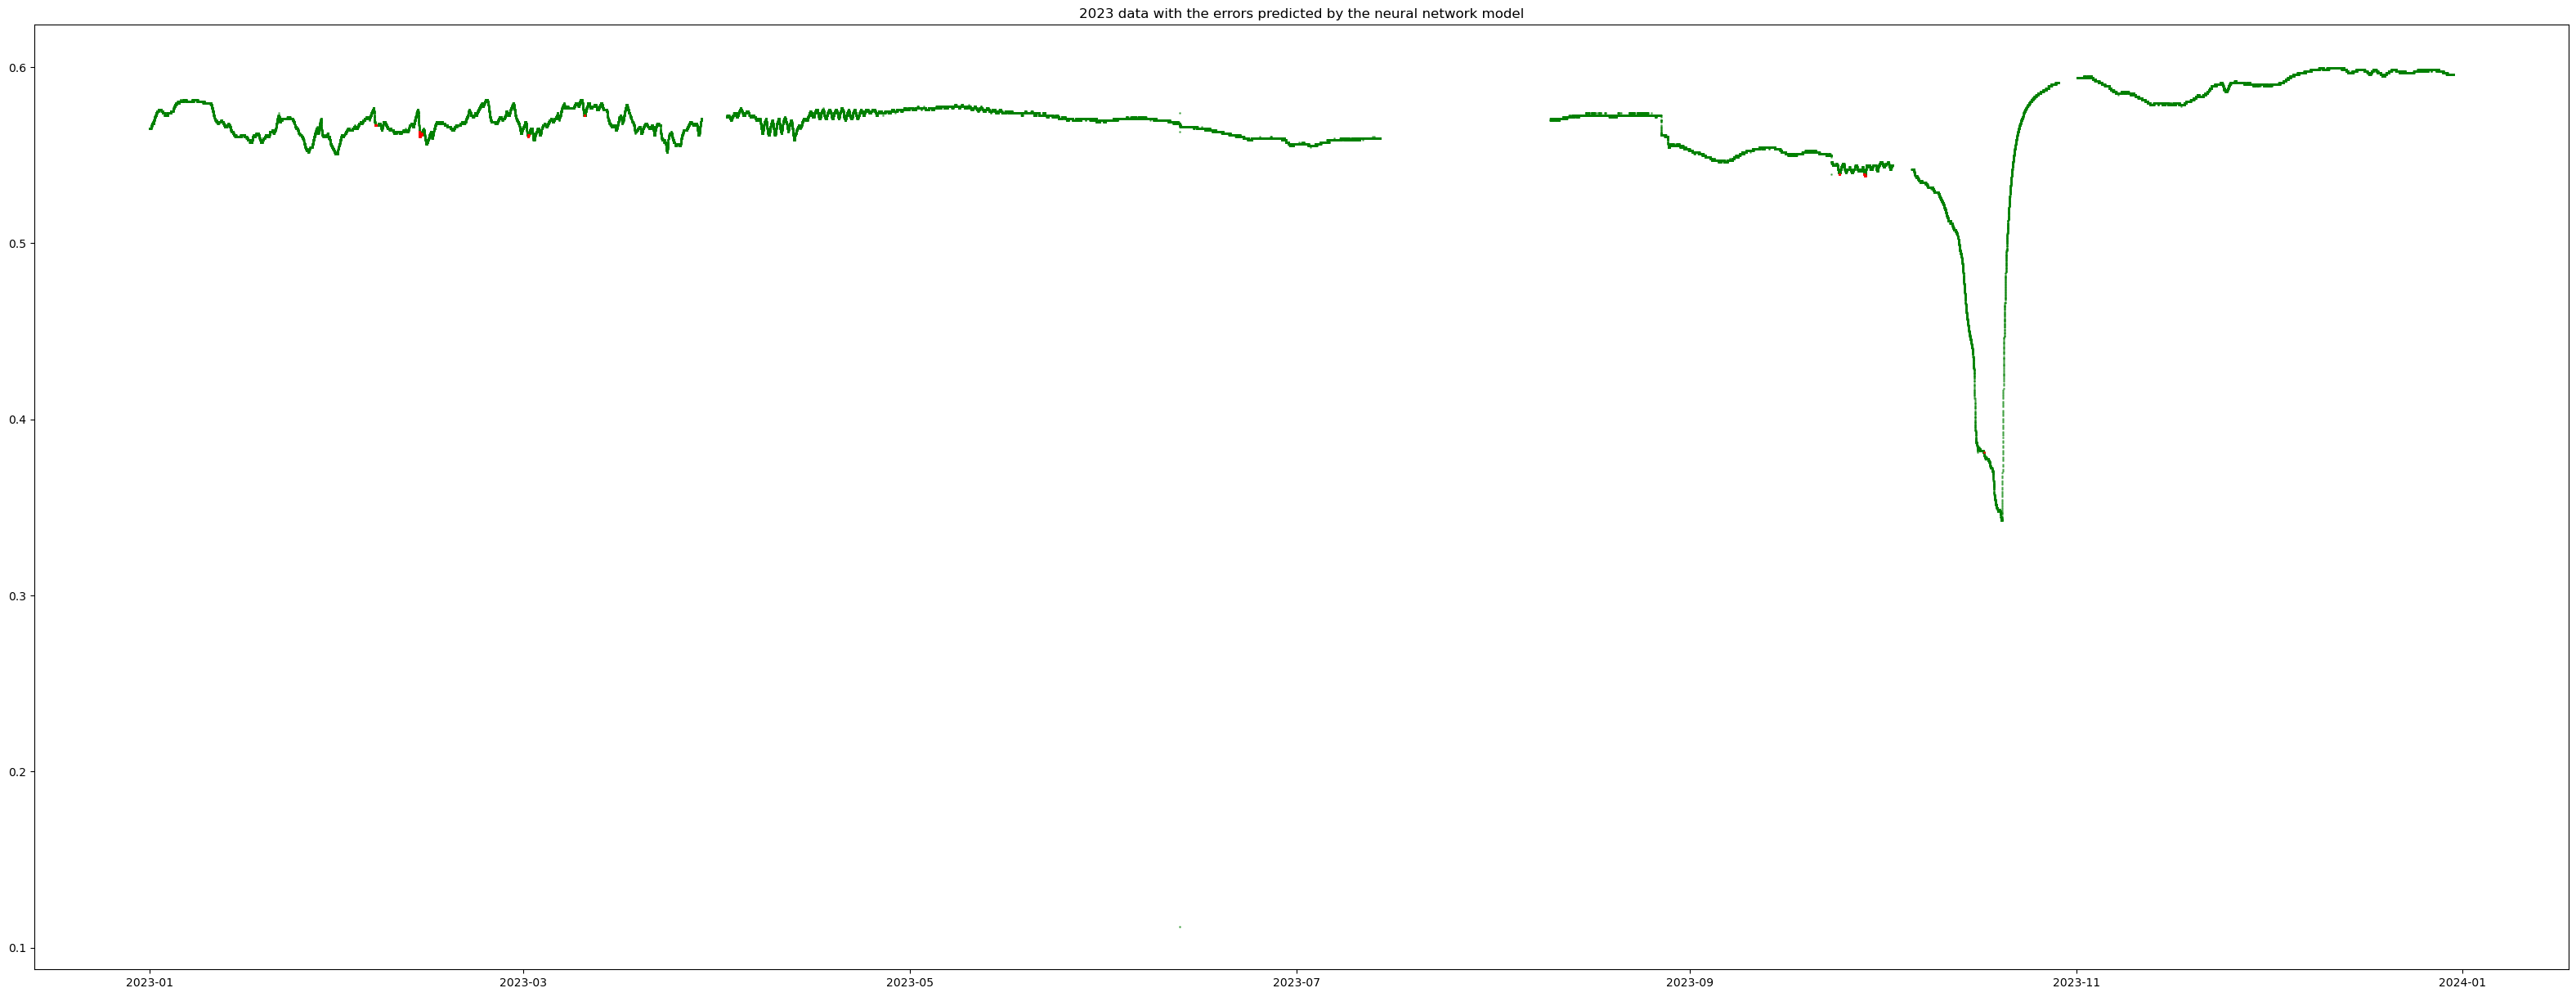

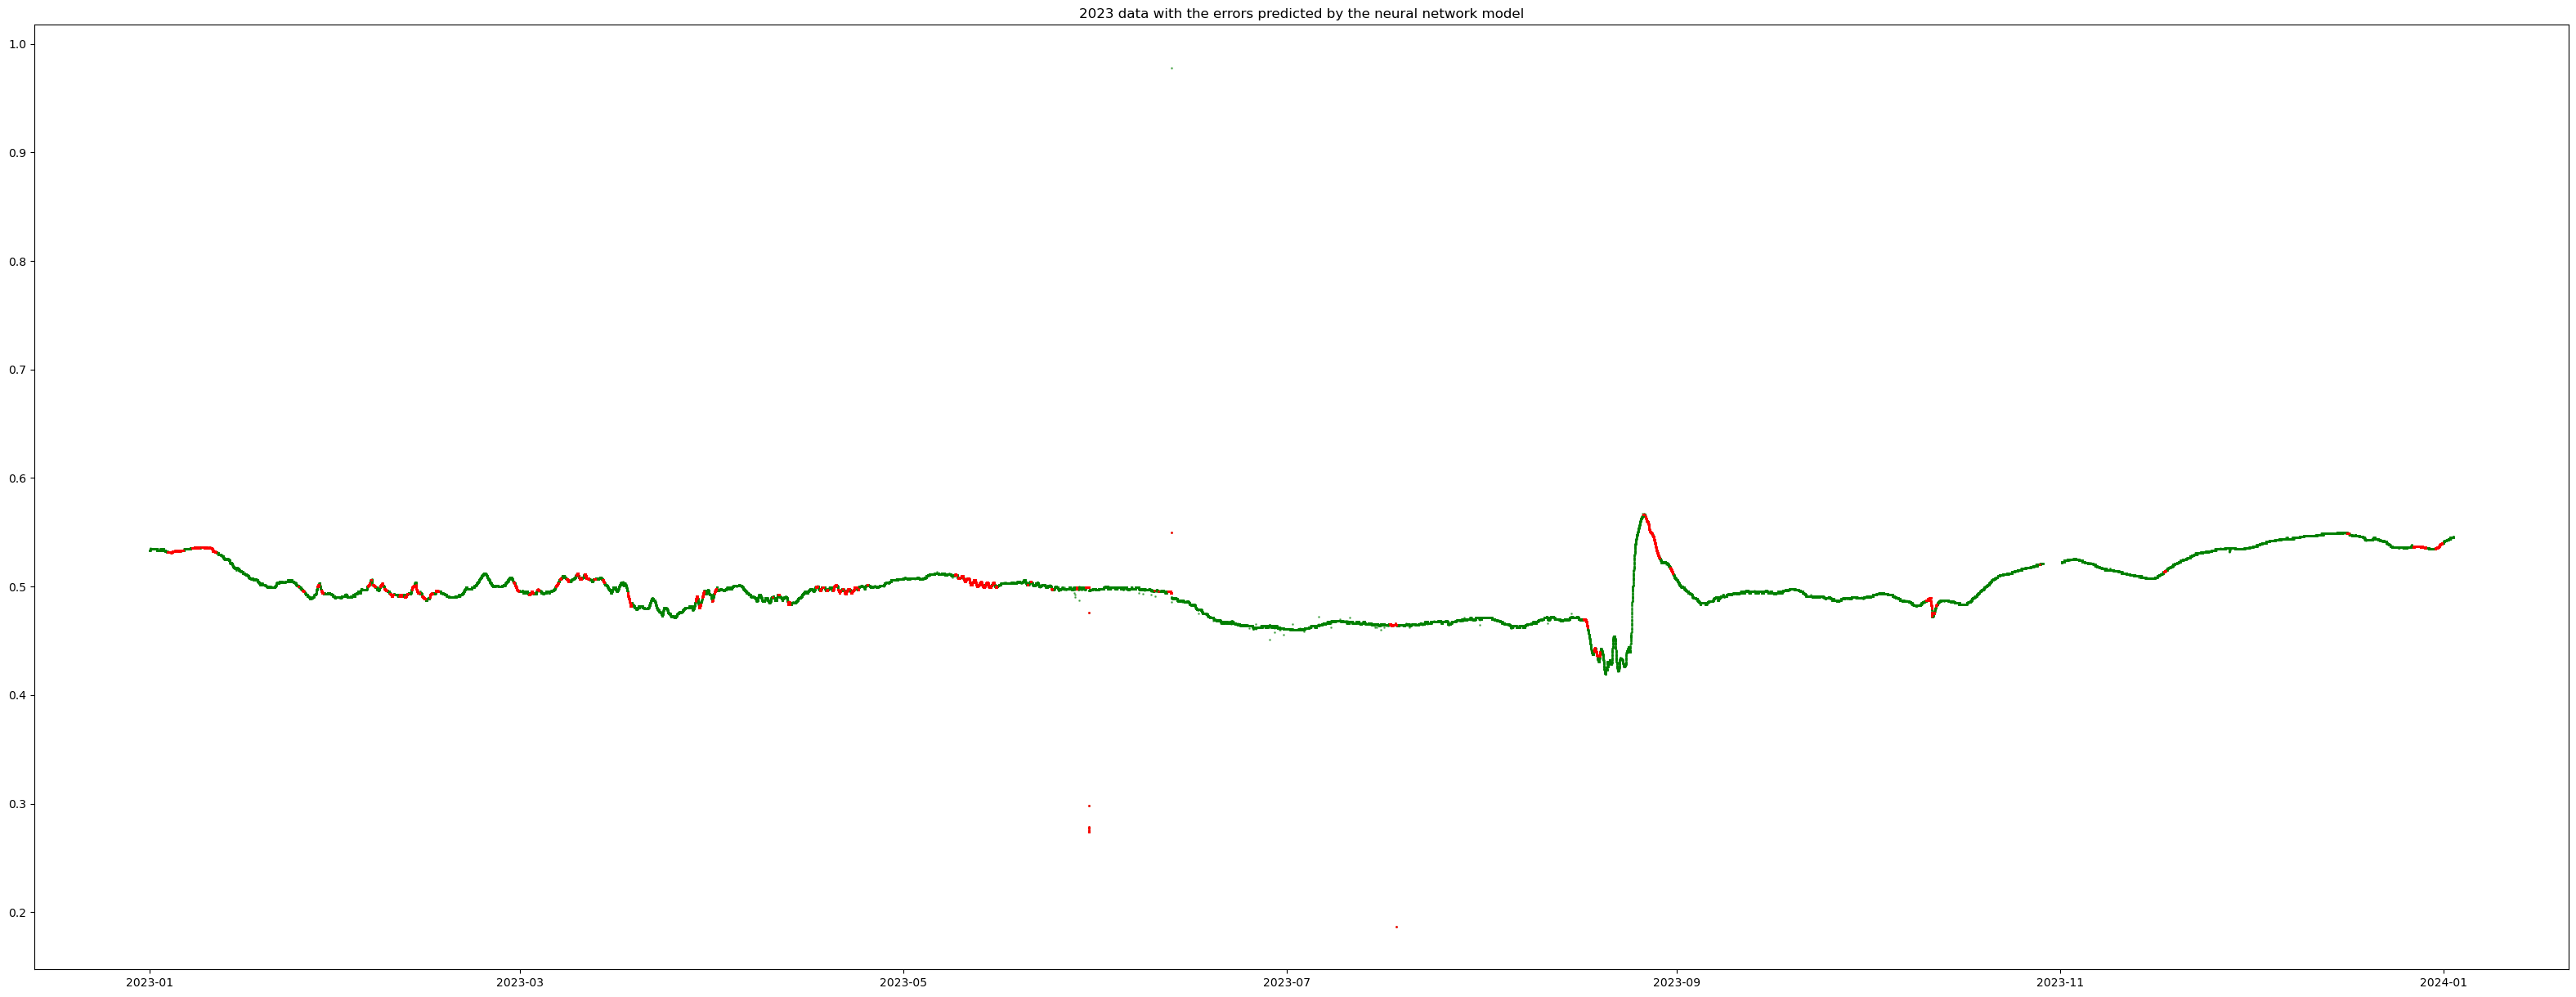

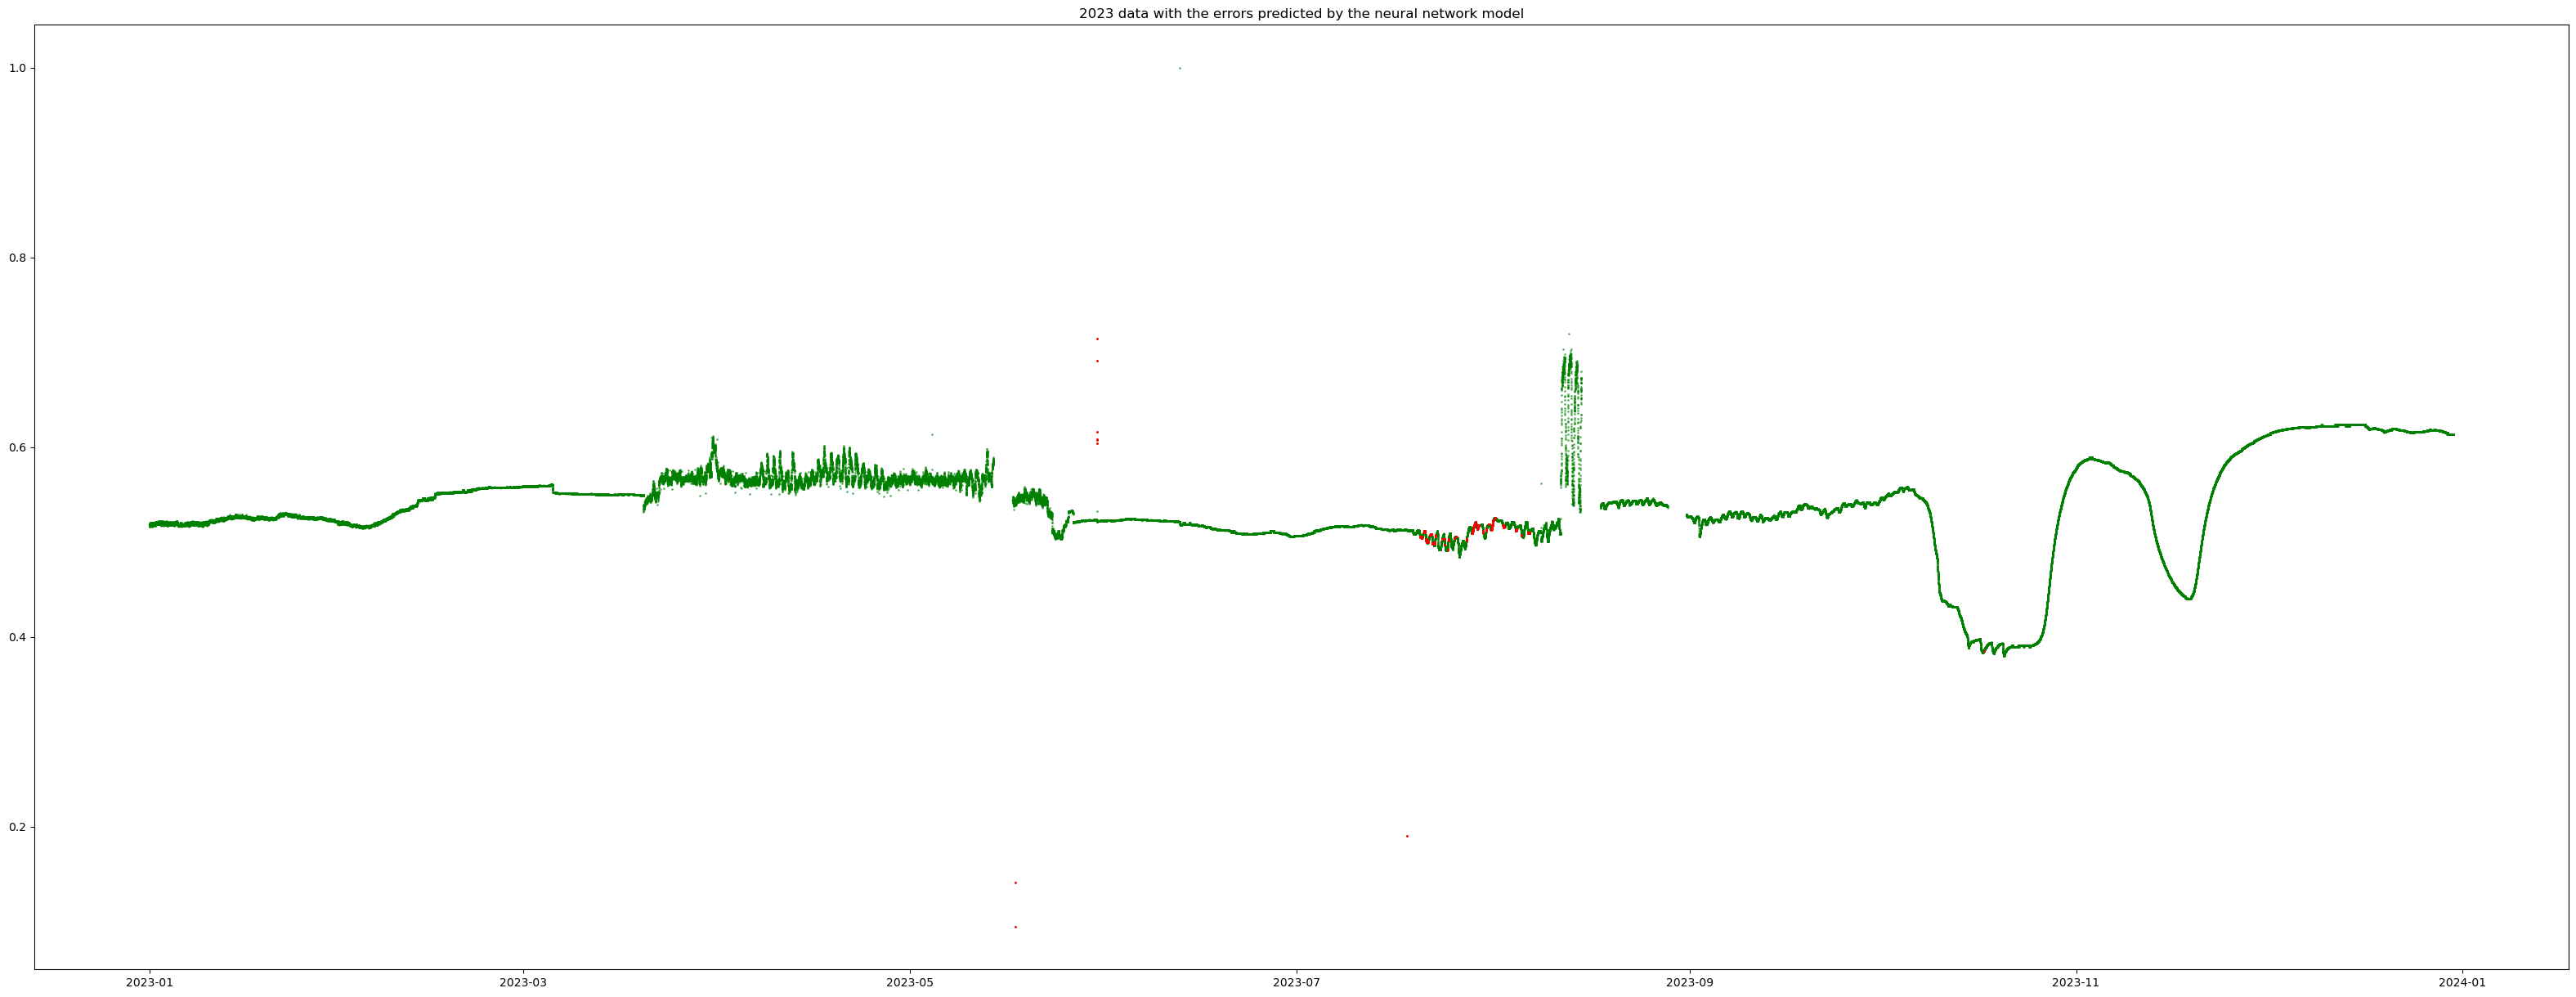

In [105]:
test_scaled_2023 = sensor_data[f'sensor_{3}']["test_scaled_2023"]
model_opt = models_Adam[3, Net5, 2.0, 4.0][15]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 3)

## Sensor 4

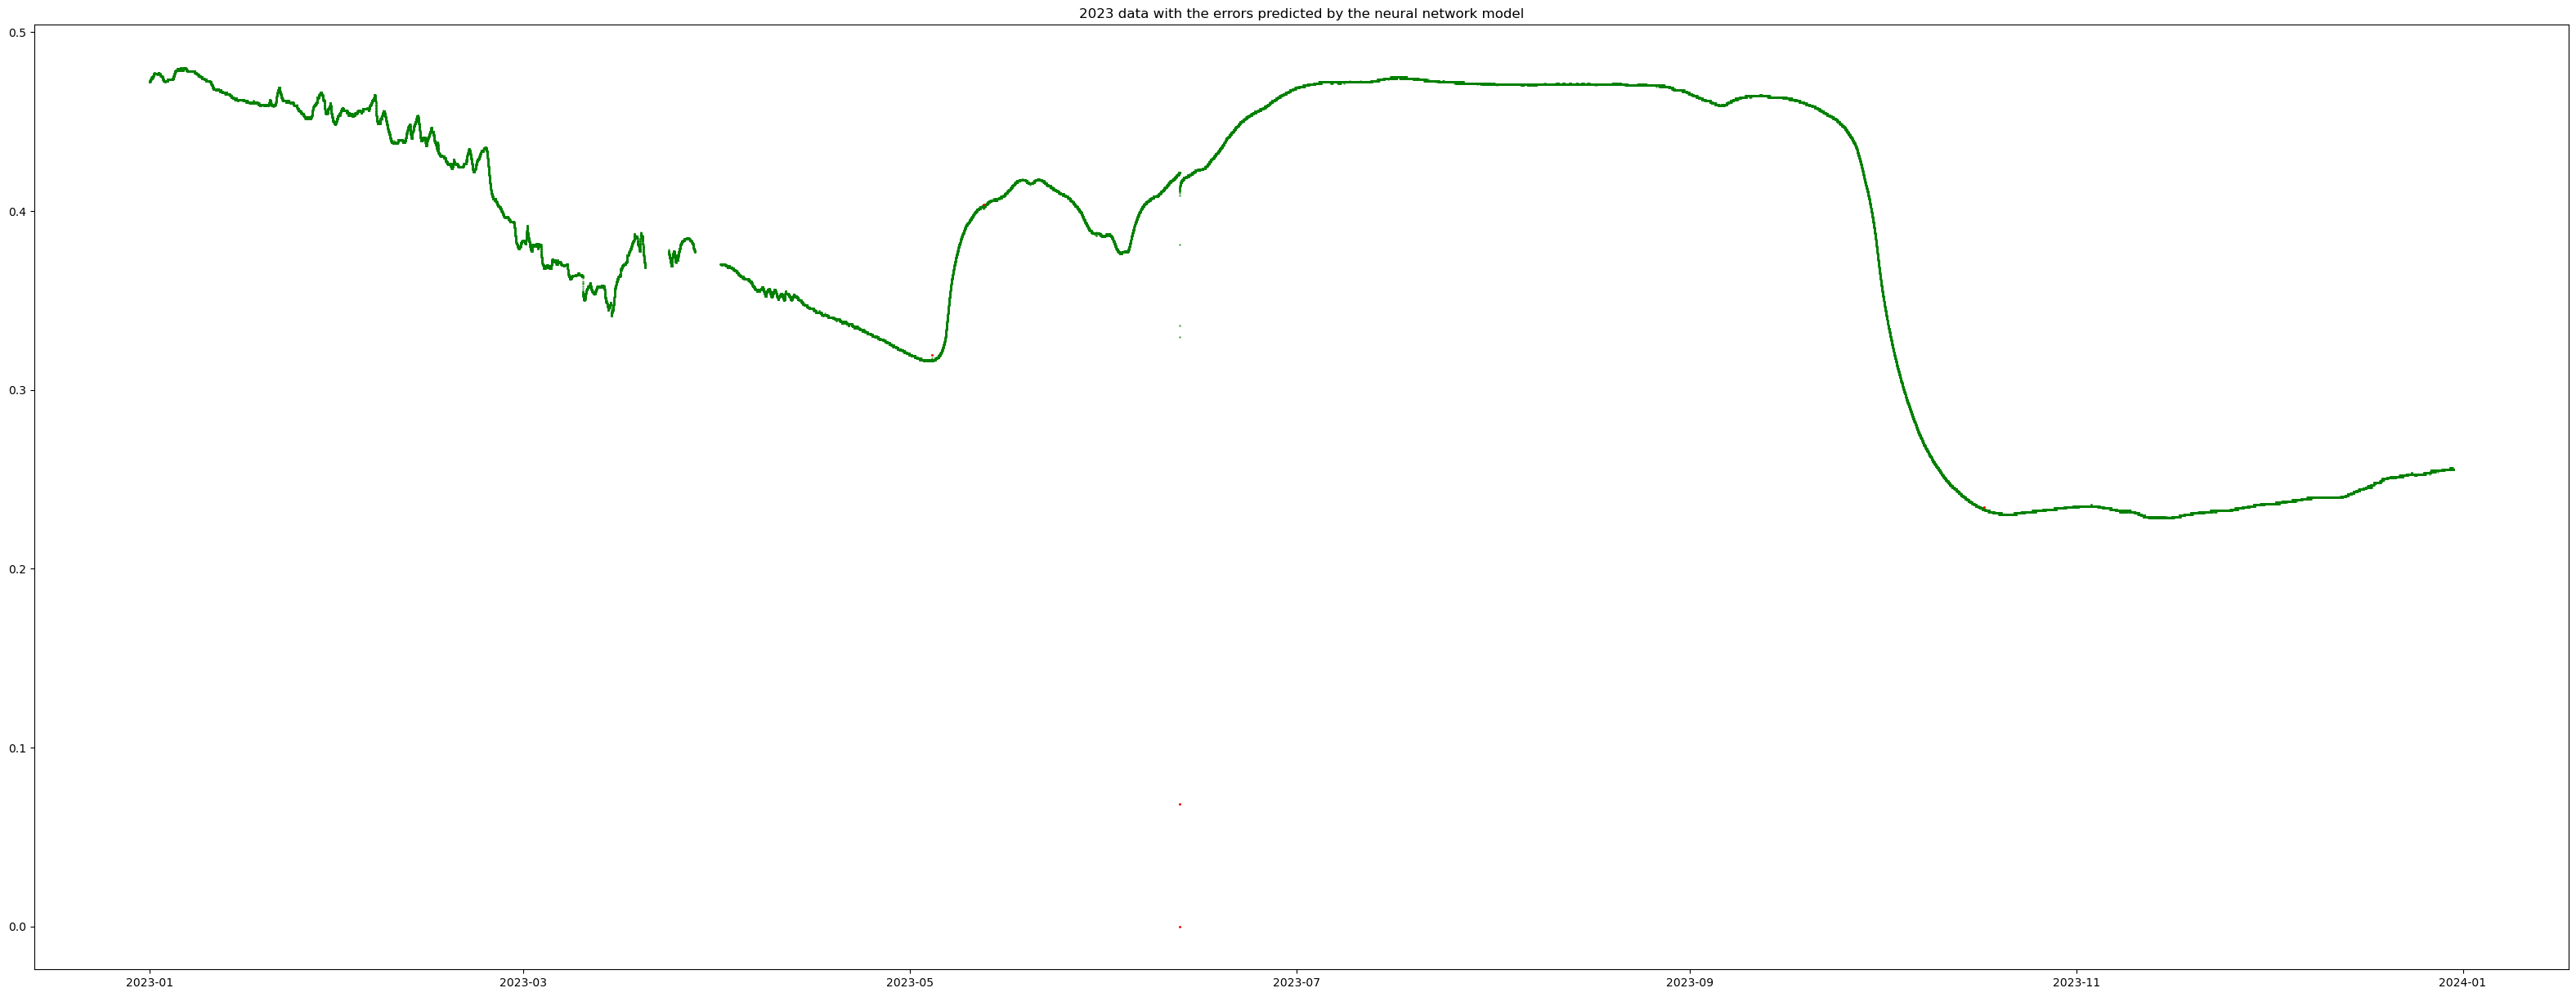

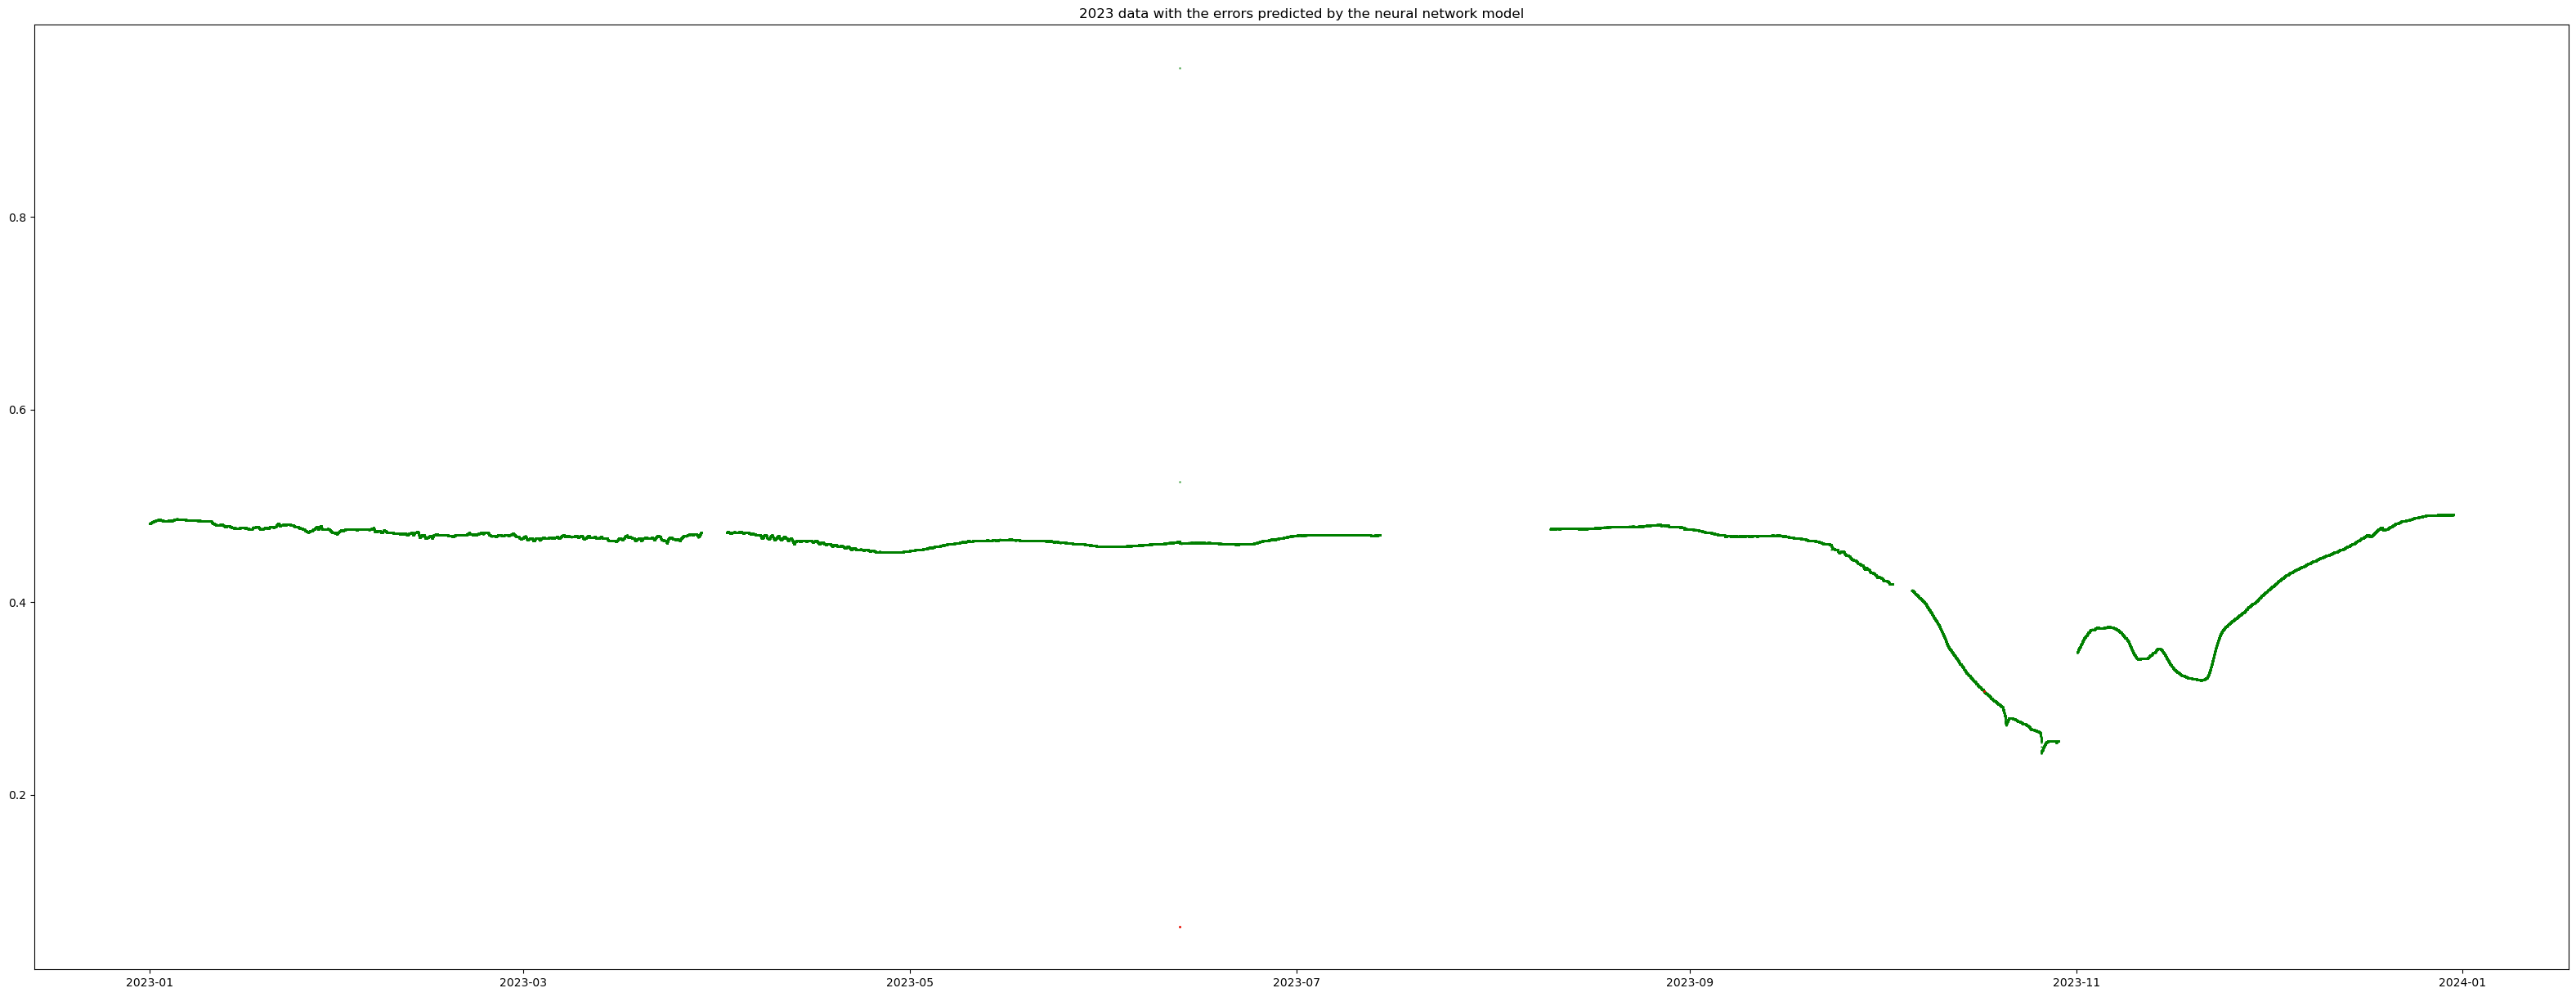

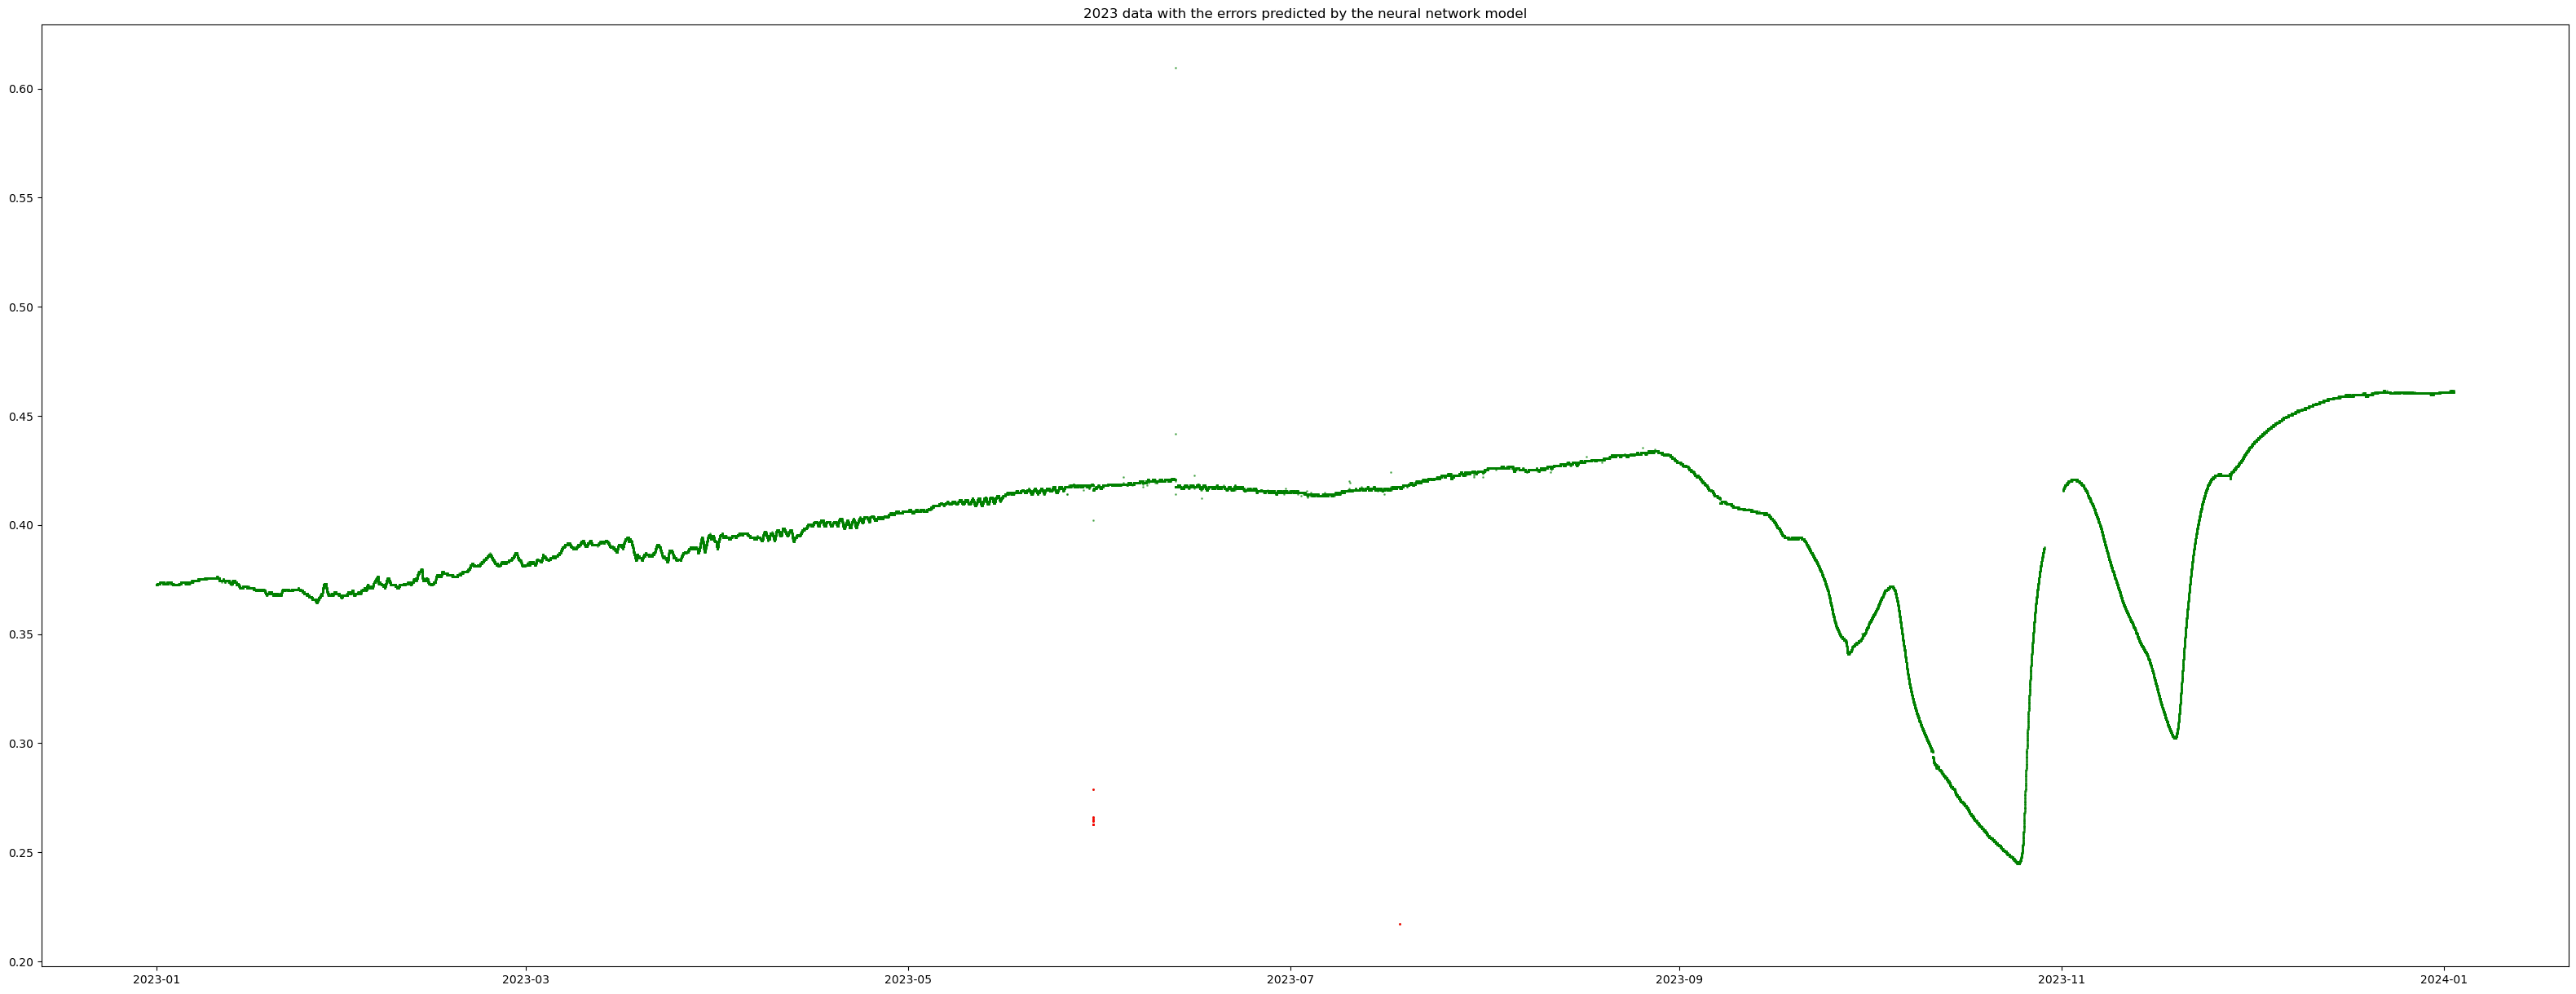

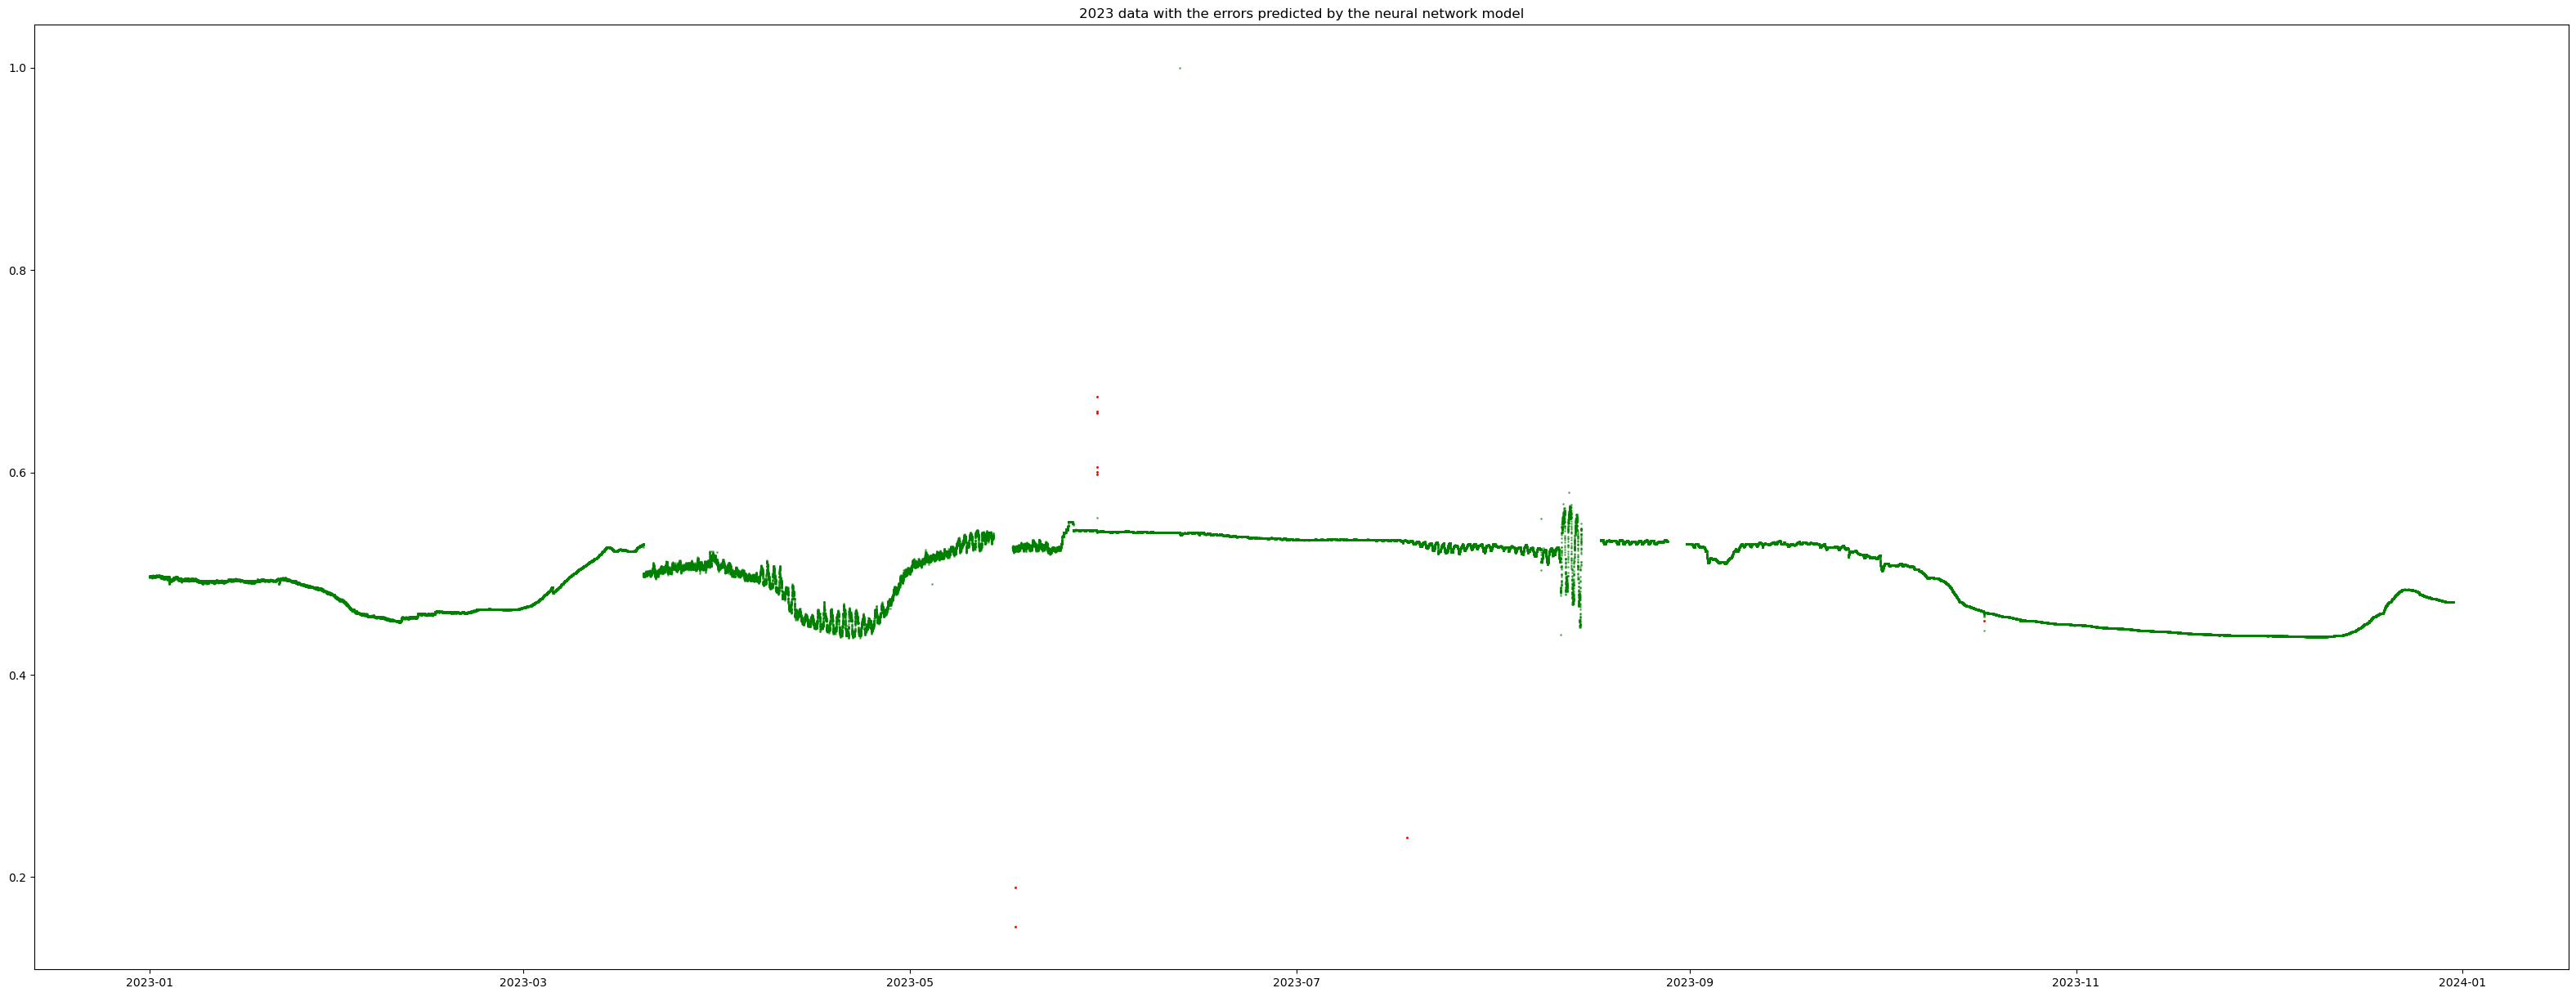

In [106]:
test_scaled_2023 = sensor_data[f'sensor_{4}']["test_scaled_2023"]
model_opt = models_Adam[4, Net5, 2.0, 2.0][11]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 4)

## Sensor 5

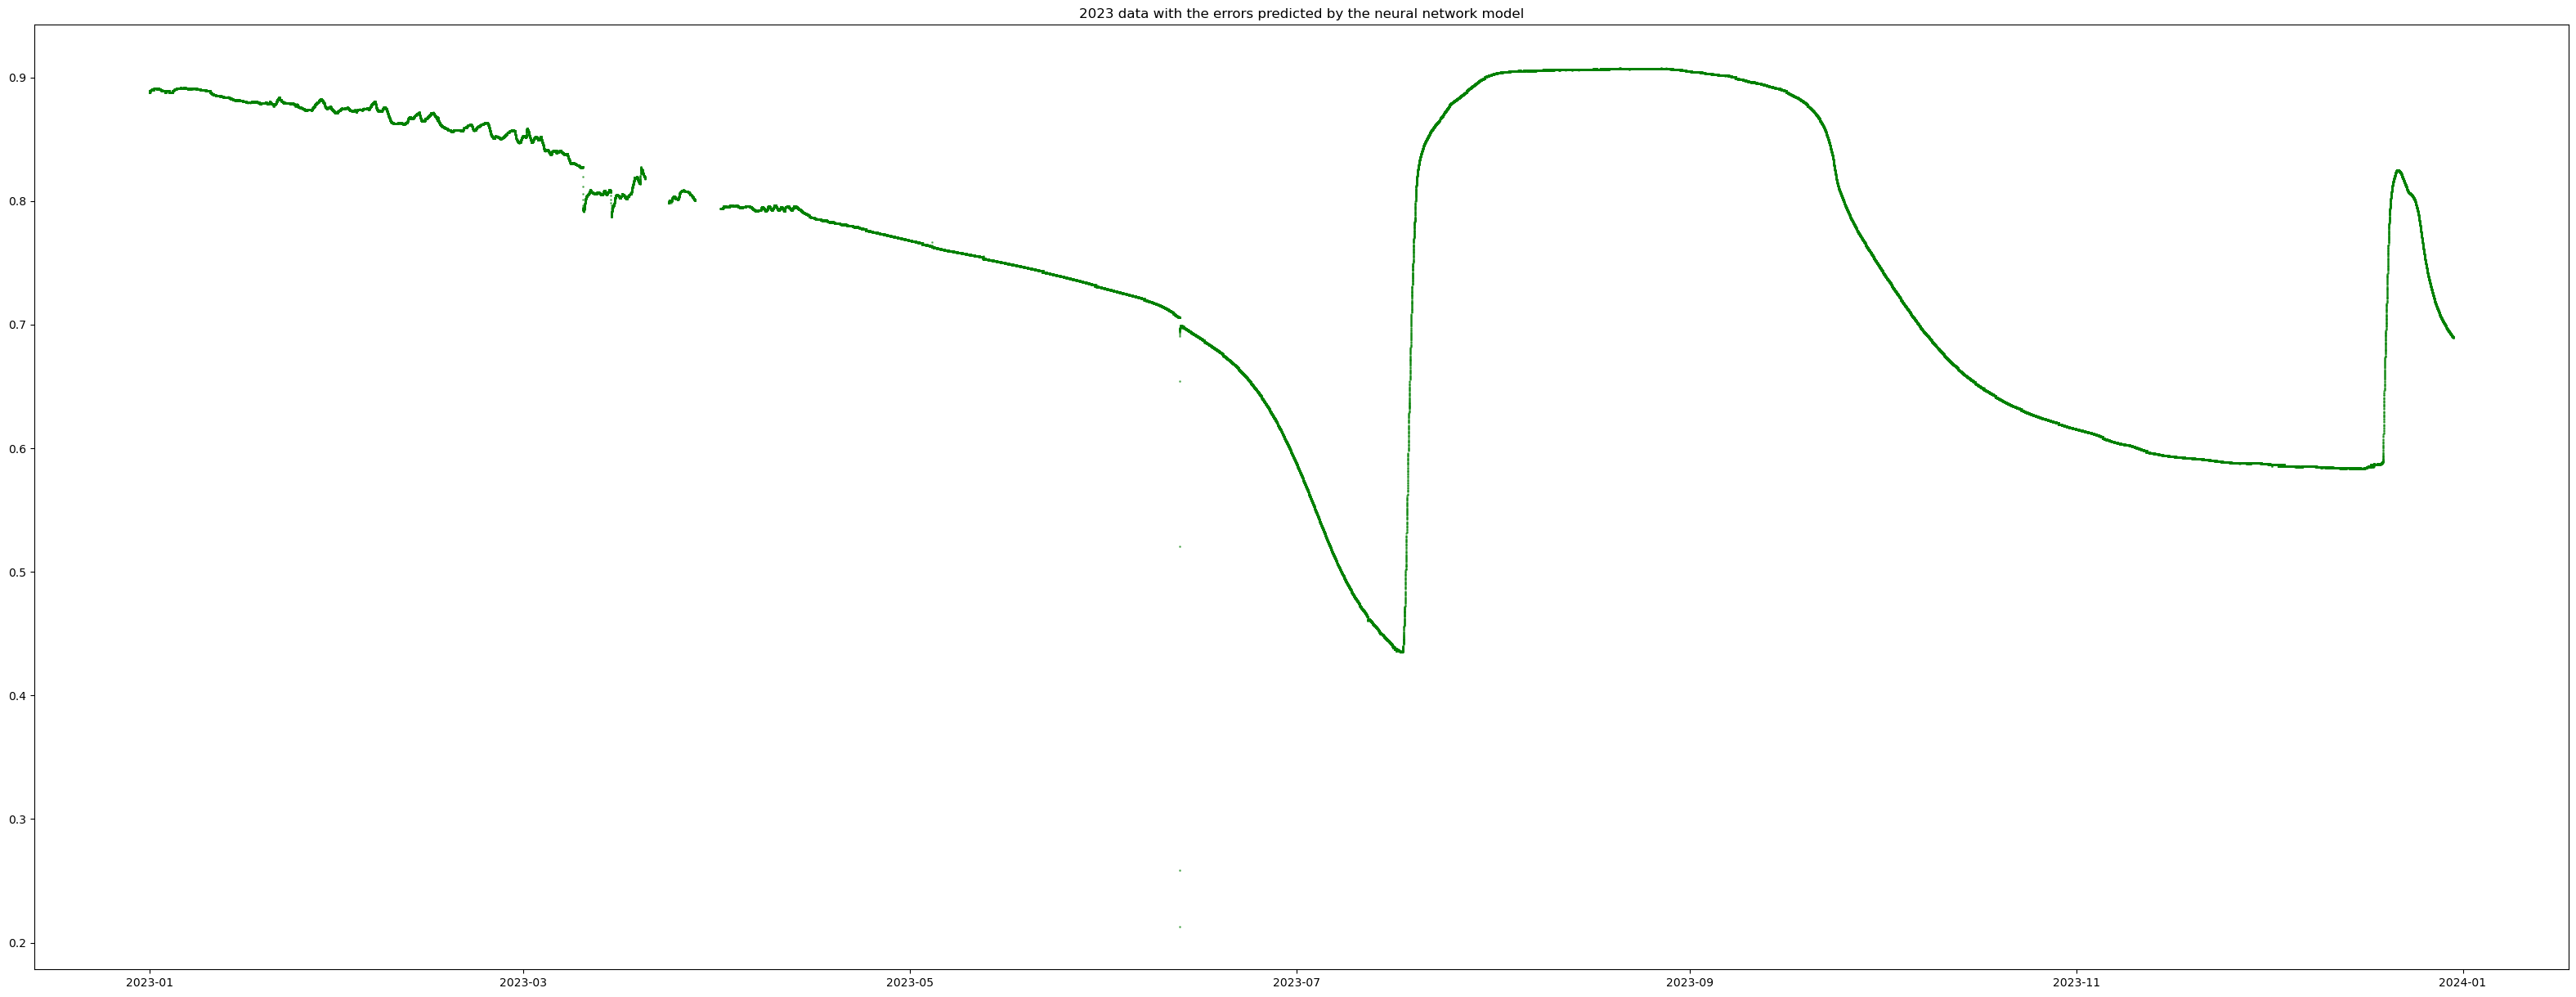

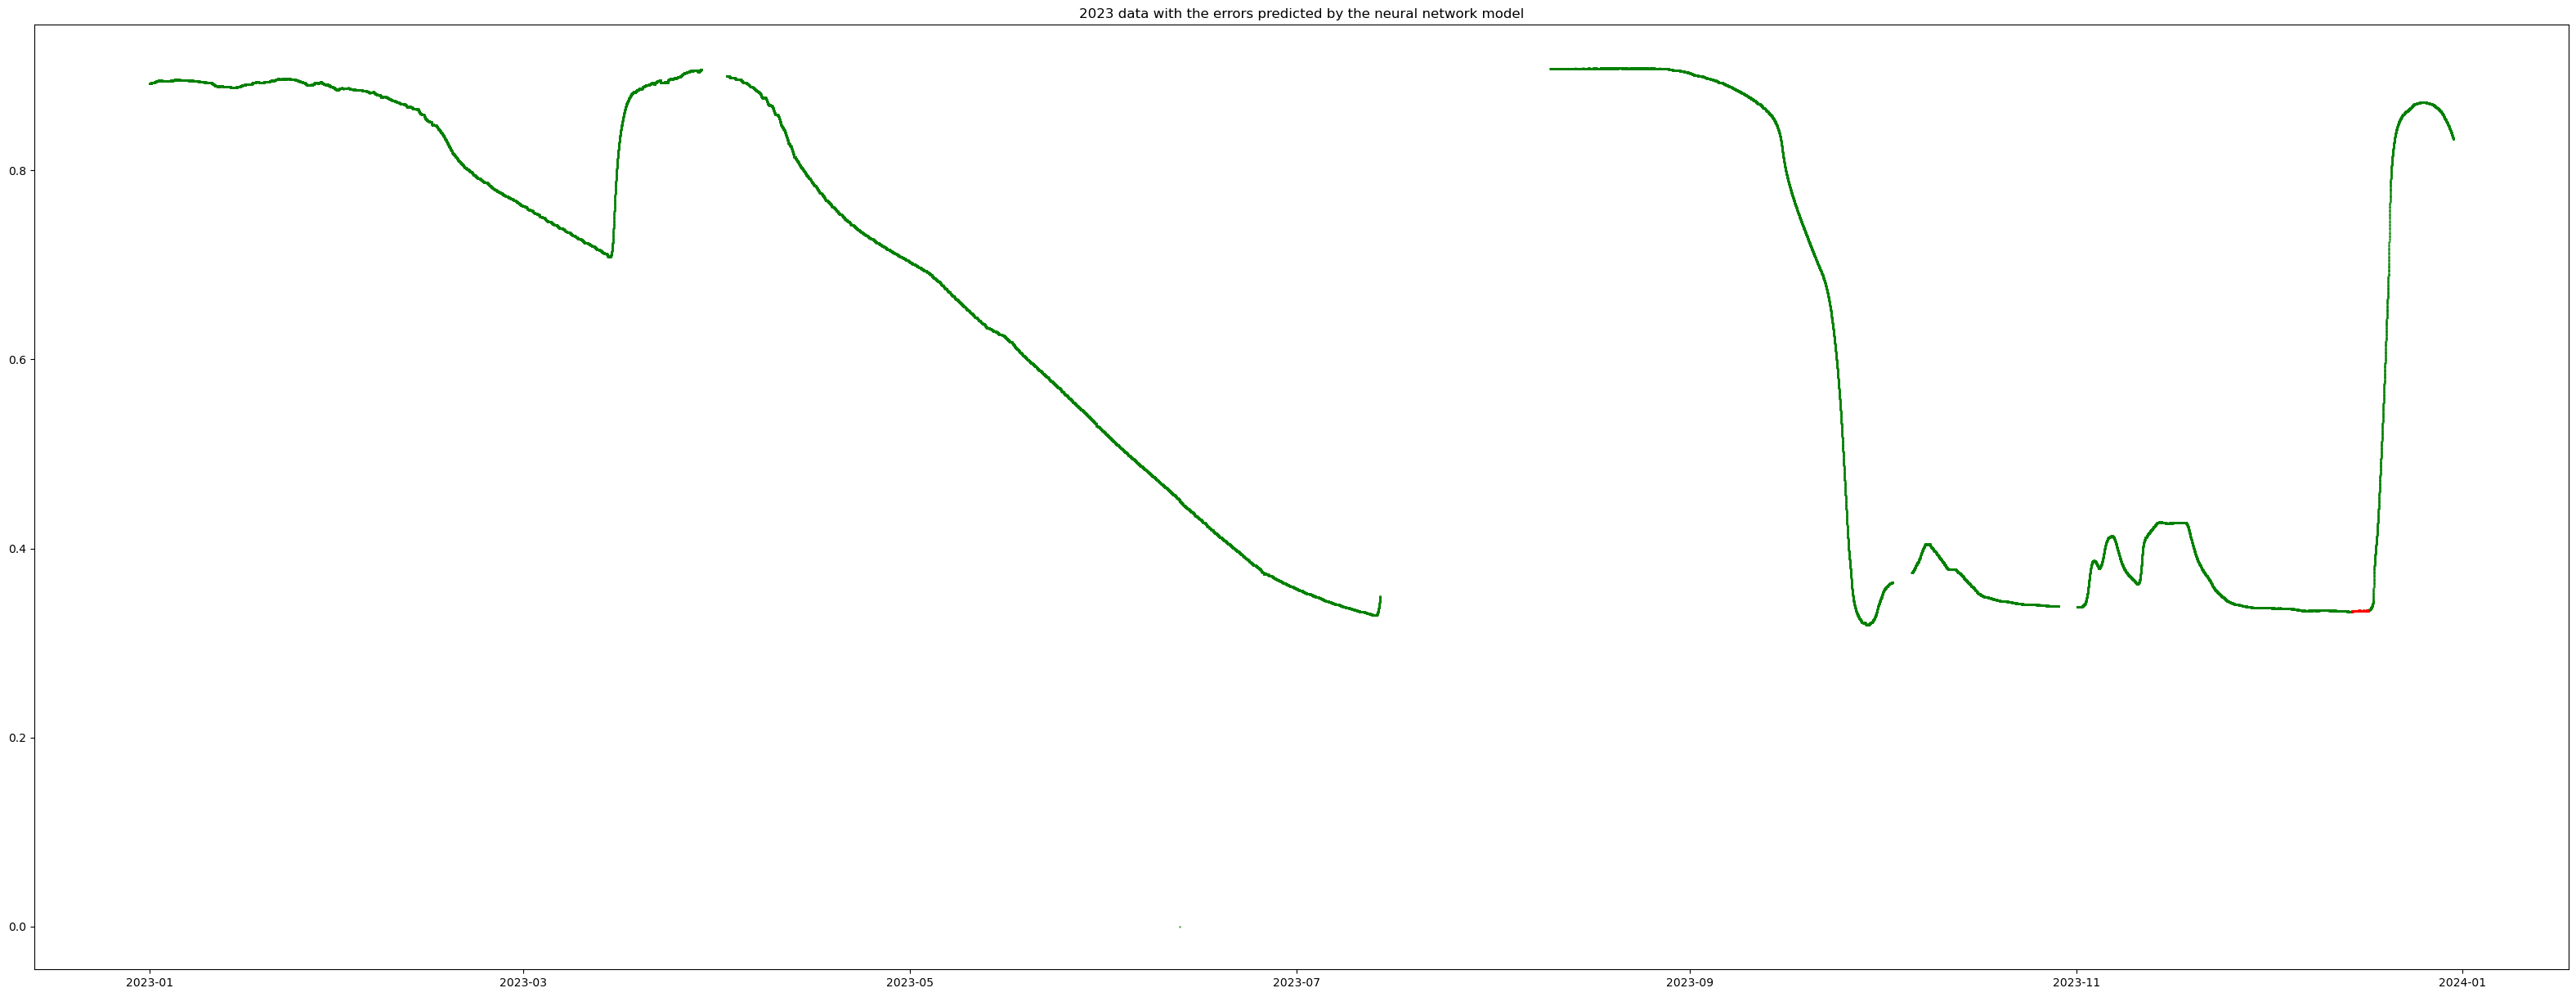

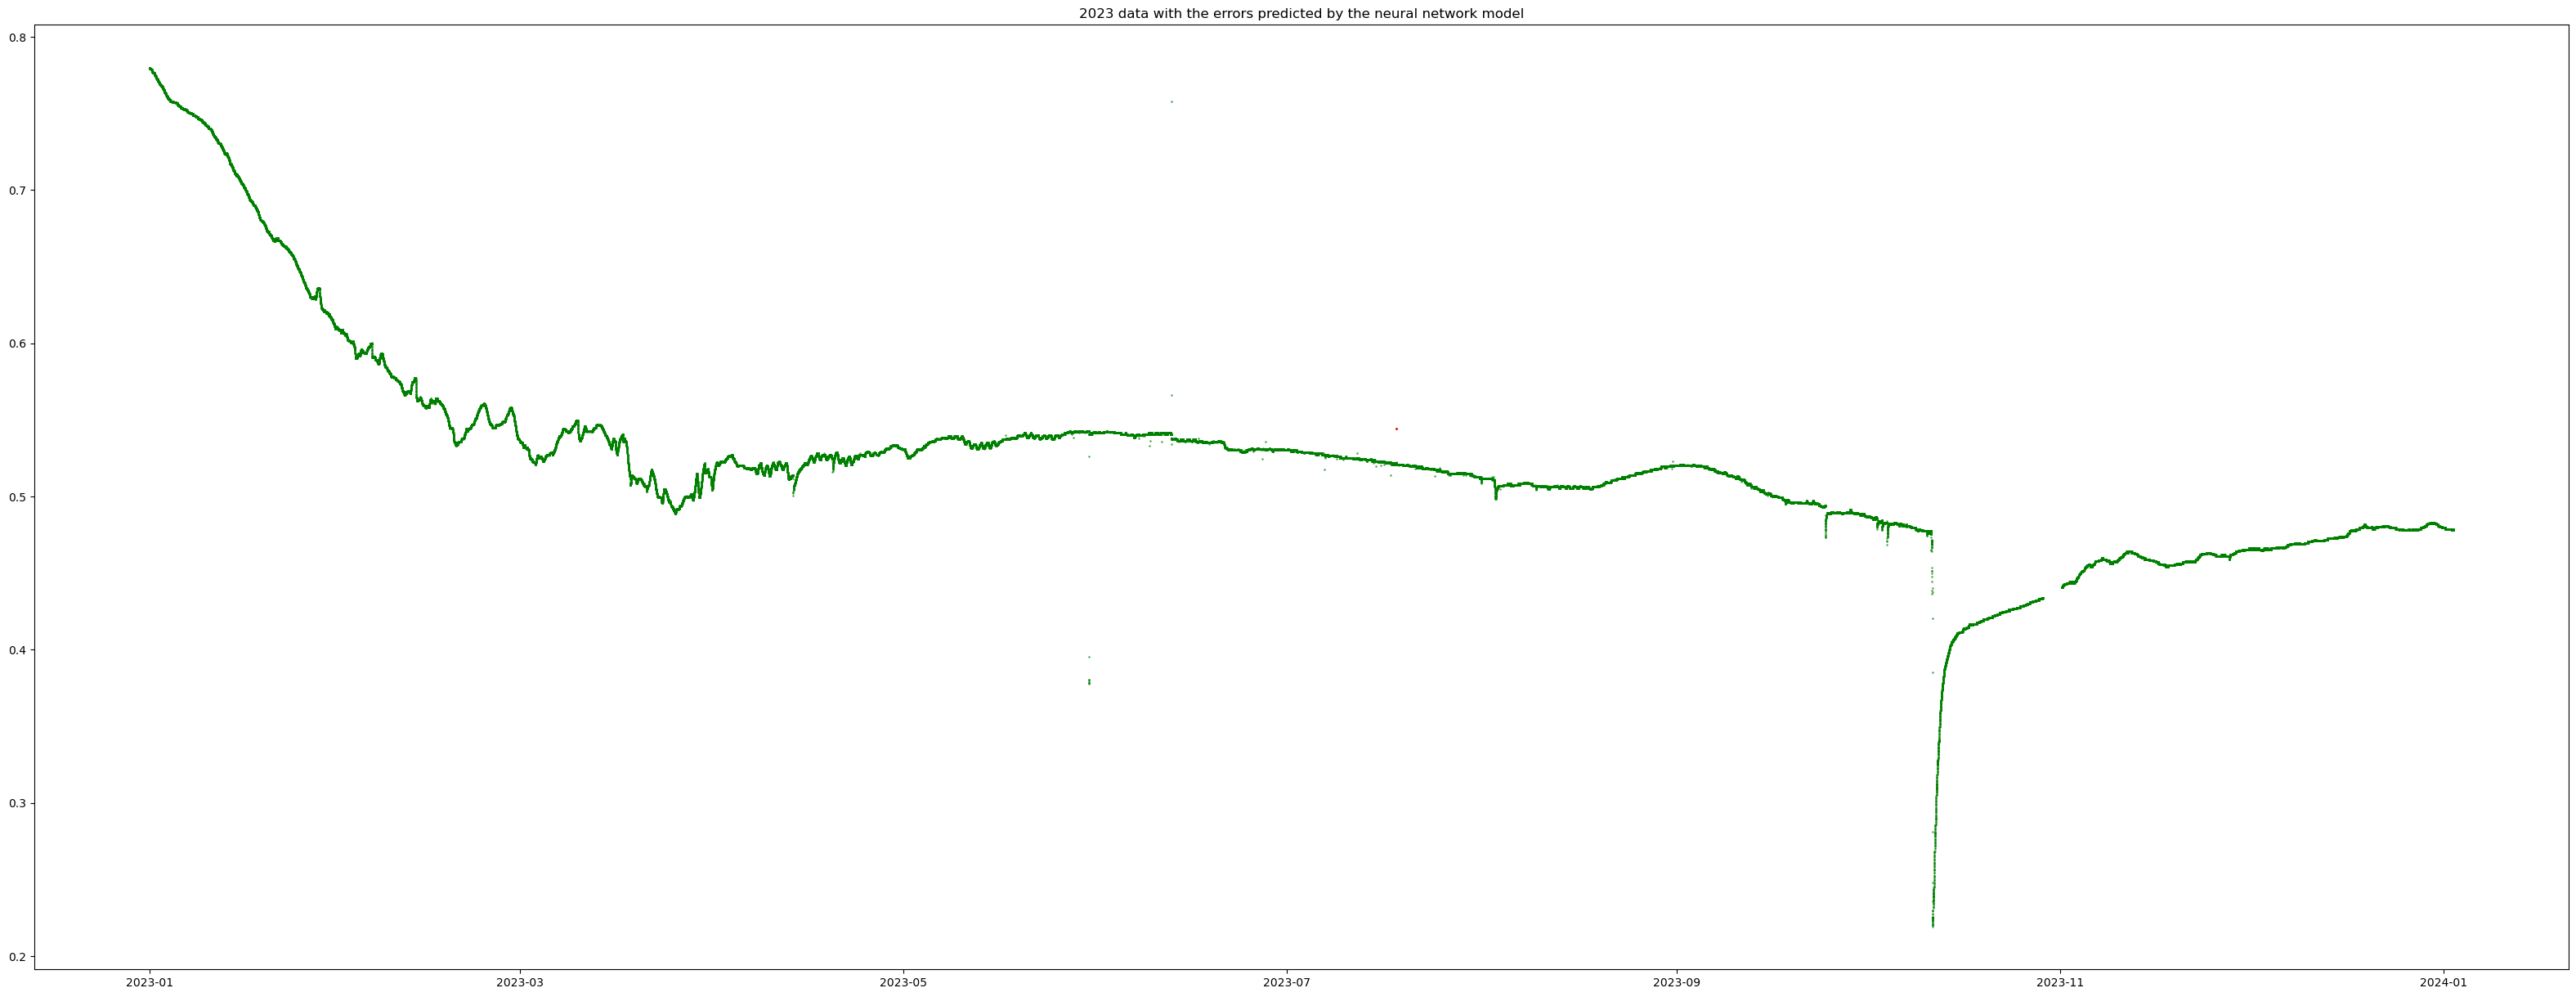

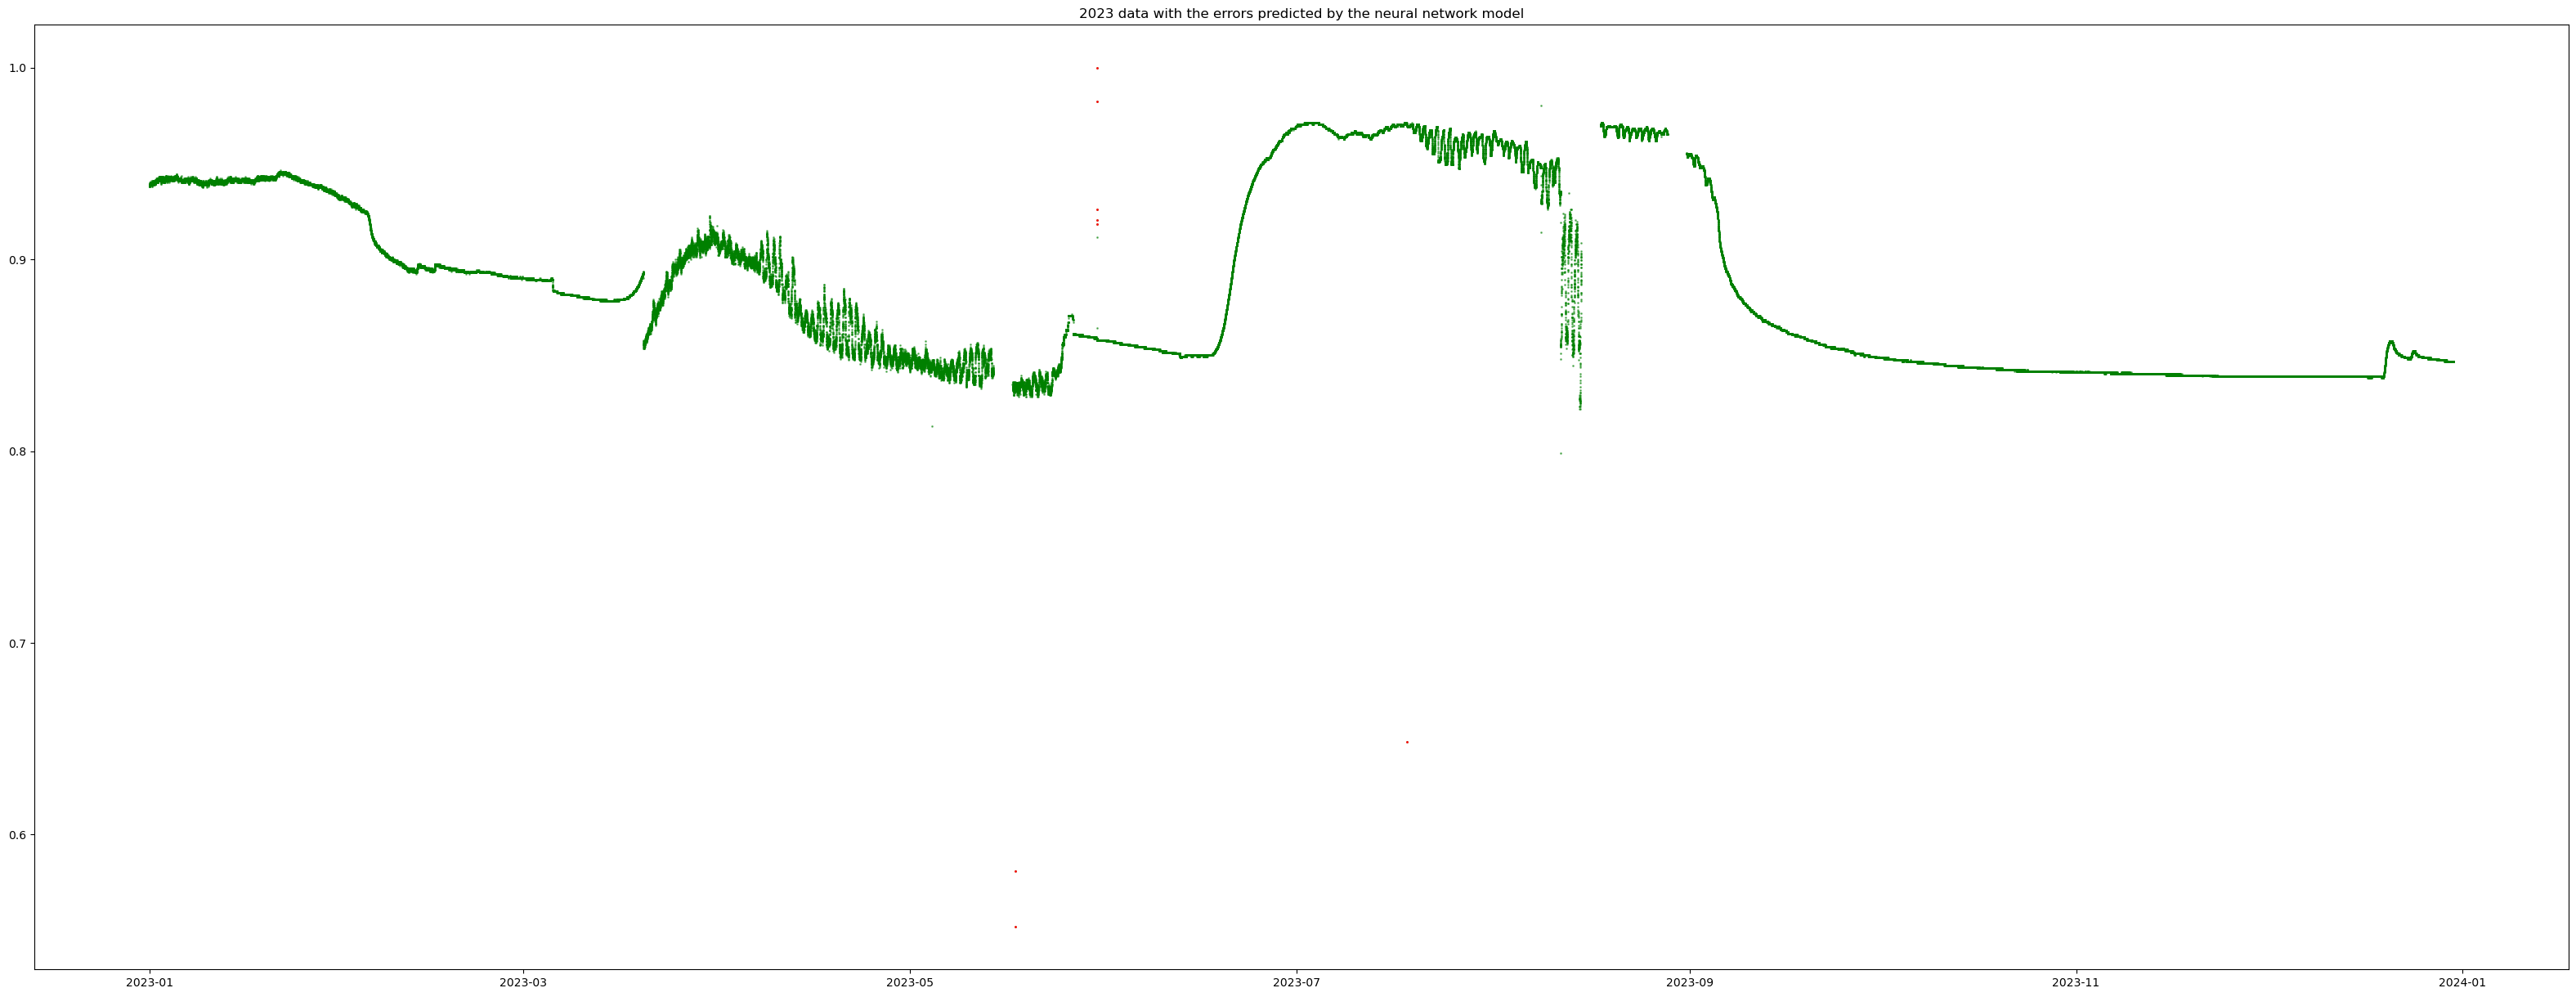

In [107]:
test_scaled_2023 = sensor_data[f'sensor_{5}']["test_scaled_2023"]
model_opt = models_Adam[5, Net5, 2.0, 2.0][9]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = 5)

## "Archive"

In [ ]:
def load(sensor, results_folder = results_folder, sensor_specific_folder = sensor_specific_folder, architecture = Net3, optimizer = "Adam", lr = 0.01, weight = [2, 7]):
    if architecture == Net3: 
        arch = 3
    else: arch = 5
    filename = f"df_sensor_{sensor}_" + str(arch) + "_layers_" + optimizer + "_" + str(lr) + "_weights_" + str(weight[0]) + "_" + str(weight[1])
    df = pickle.load(open(results_folder + sensor_specific_folder + filename, 'rb'))
    return df

In [82]:
for sensor in np.arange(1,6):
    print("\n")
    print(f"SENSOR {sensor} RESULTS")
    parameters_options = itertools.product(architecture_parameters, weight_parameters)
    for parameters in parameters_options:
        print("\n")
        print(f"Results for models with diff number of units for sensor {sensor}, architecture - {architecture} with weight - {weight}")
        print("\n")
        architecture = parameters[0]
        weight = parameters[1]
        df = load(sensor, optimizer = "Adam", lr = learning_rate, architecture = architecture, weight = weight)
        print(df)



SENSOR 1 RESULTS


Results for models with diff number of units for sensor 1, architecture - <class 'Net5.Net5'> with weight - [2.0, 7.0]


   number_of_units  train_log_likelihood  train_accuracy  train_recall  test_log_likelihood  test_accuracy  test_recall
0                3          1.195758e-06        0.974733      0.000000         2.784781e-06       0.974757     0.000000
1                4          3.576801e-07        0.985259      0.628709         3.455982e-06       0.973648     0.105706
2                5          3.579702e-07        0.987994      0.892943         3.014044e-06       0.974049     0.050514
3                6          3.333907e-08        0.999372      0.992382         7.230564e-07       0.990389     0.626754
4                7          2.310390e-08        0.999656      0.998797         8.517519e-07       0.990602     0.635173
5                9          6.384774e-08        0.998784      0.977947         1.239473e-06       0.987249     0.504210
6               11